In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import cv2
import h5py
import os
import random

import warnings
warnings.filterwarnings("ignore")

# Create Pairs

In [2]:
ground_truth = pd.read_csv('.\COMP90086_2023_TLLdataset\\train.csv')

# Create a dictionary for lookup
gt_dict = ground_truth.set_index('left').to_dict()['right']

def create_training_dataset(left_folder, right_folder, ground_truth, num_foils=5, seed=123):
    random.seed(seed)
    left_images = [img_name.replace('.jpg', '') for img_name in os.listdir(left_folder)]
    right_images = [img_name.replace('.jpg', '') for img_name in os.listdir(right_folder)]

    paired_data = []
    labels = []

    for left_img_name in left_images:
        true_match = ground_truth[left_img_name]

        foils = [img for img in right_images if img != true_match]
        random.shuffle(foils)
        foils = foils[:num_foils]

        paired_data.append((left_img_name, true_match))
        labels.append(1)  # 1 indicates a true match

        for foil in foils:
            paired_data.append((left_img_name, foil))
            labels.append(0)  # 0 indicates a non-match

    return paired_data, labels

# Creating paired data and labels
paired_data, labels = create_training_dataset(".\COMP90086_2023_TLLdataset\\train\\left",
                                              ".\COMP90086_2023_TLLdataset\\train\\right",
                                              gt_dict)

labels = np.array(labels)

# L1 Distance

## vgg

In [3]:
left_train = np.load('vgg_train_left.npy')
right_train = np.load('vgg_train_right.npy')
left_test = np.load('vgg_test_left.npy')
right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [4]:
path = ".\COMP90086_2023_TLLdataset\\train\\left"
dir_list = os.listdir(path)
train_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\train\\right"
dir_list = os.listdir(path)
train_right_images_list = dir_list

left_array_dict = {}
for i in range(len(train_left_images_list)):
    left_array_dict[train_left_images_list[i][:3]] = left_train[i]
    
right_array_dict = {}
for i in range(len(train_right_images_list)):
    right_array_dict[train_right_images_list[i][:3]] = right_train[i]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [5]:
input_shape = (512,)
# input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model

# Reference:
# https://keras.io/examples/vision/siamese_contrastive/?fbclid=IwAR0d0p7eAw2zZDUiyaPhkt-ZQuDQ32U7rRIHxv4ErsSn9yVkBFbfzBC42fQ
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_network(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    shared_network = create_shared_network(input_shape)
    left_features = shared_network(left_input)
    right_features = shared_network(right_input)

    distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([left_features, right_features])
    normal_layer = tf.keras.layers.BatchNormalization()(distance)
    similarity_score = Dense(1, activation='sigmoid')(distance)
    
#     distance = Lambda(euclidean_distance)([left_features, right_features])
#     normal_layer = tf.keras.layers.BatchNormalization()(distance)
#     similarity_score = layers.Dense(1, activation="sigmoid")(normal_layer)

    siamese_net = Model(inputs=[left_input, right_input], outputs=1-similarity_score)
    return siamese_net
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1\\vgg_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1\\vgg_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [6]:
# Reference:
# https://keras.io/examples/vision/siamese_contrastive/?fbclid=IwAR0d0p7eAw2zZDUiyaPhkt-ZQuDQ32U7rRIHxv4ErsSn9yVkBFbfzBC42fQ
def loss():
    margin=1
    def contrastive_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [7]:
batch_size = 16
no_layer = 1
lr = 0.001
model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

epochs = 100
history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1347 - accuracy: 0.8317 - recall: 0.0063 - val_loss: 0.1288 - val_accuracy: 0.8338 - val_recall: 0.0025 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1205 - accuracy: 0.8357 - recall: 0.0300 - val_loss: 0.1300 - val_accuracy: 0.8317 - val_recall: 0.0300 - 749ms/epoch - 1ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1085 - accuracy: 0.8510 - recall: 0.1331 - val_loss: 0.1291 - val_accuracy: 0.8317 - val_recall: 0.1025 - 701ms/epoch - 1ms/step
Epoch 4/100
600/600 - 1s - loss: 0.0946 - accuracy: 0.8773 - recall: 0.3256 - val_loss: 0.1383 - val_accuracy: 0.8150 - val_recall: 0.2100 - 638ms/epoch - 1ms/step
Epoch 5/100
600/600 - 1s - loss: 0.0812 - accuracy: 0.9022 - recall: 0.4787 - val_loss: 0.1415 - val_accuracy: 0.8083 - val_recall: 0.1525 - 678ms/epoch - 1ms/step
Epoch 6/100
600/600 - 1s - loss: 0.0670 - accuracy: 0.9247 - recall: 0.6037 - val_loss: 0.1474 - val_accuracy: 0.8050 - val_recall: 0.1725 - 604ms/epoch - 1ms/step
Epoch 7/100
600/600

Epoch 51/100
600/600 - 1s - loss: 0.0156 - accuracy: 0.9840 - recall: 0.9100 - val_loss: 0.1921 - val_accuracy: 0.7900 - val_recall: 0.1825 - 646ms/epoch - 1ms/step
Epoch 52/100
600/600 - 1s - loss: 0.0158 - accuracy: 0.9837 - recall: 0.9094 - val_loss: 0.2135 - val_accuracy: 0.7667 - val_recall: 0.2250 - 607ms/epoch - 1ms/step
Epoch 53/100
600/600 - 1s - loss: 0.0146 - accuracy: 0.9857 - recall: 0.9156 - val_loss: 0.2067 - val_accuracy: 0.7763 - val_recall: 0.2225 - 623ms/epoch - 1ms/step
Epoch 54/100
600/600 - 1s - loss: 0.0152 - accuracy: 0.9847 - recall: 0.9125 - val_loss: 0.2068 - val_accuracy: 0.7742 - val_recall: 0.2300 - 566ms/epoch - 944us/step
Epoch 55/100
600/600 - 1s - loss: 0.0175 - accuracy: 0.9812 - recall: 0.9025 - val_loss: 0.2044 - val_accuracy: 0.7779 - val_recall: 0.2075 - 558ms/epoch - 931us/step
Epoch 56/100
600/600 - 1s - loss: 0.0174 - accuracy: 0.9816 - recall: 0.9006 - val_loss: 0.2035 - val_accuracy: 0.7788 - val_recall: 0.2000 - 670ms/epoch - 1ms/step
Epoch 

#### Predict

In [8]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

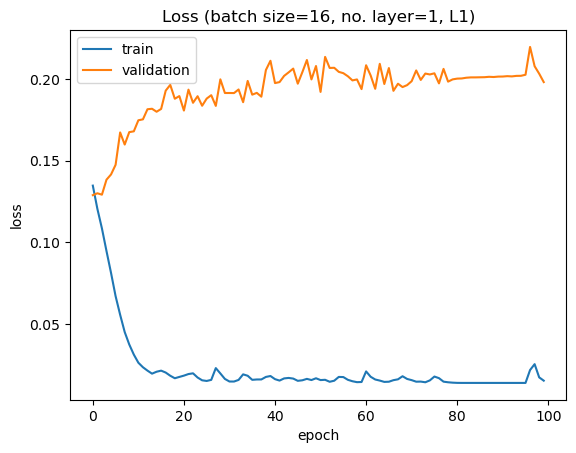

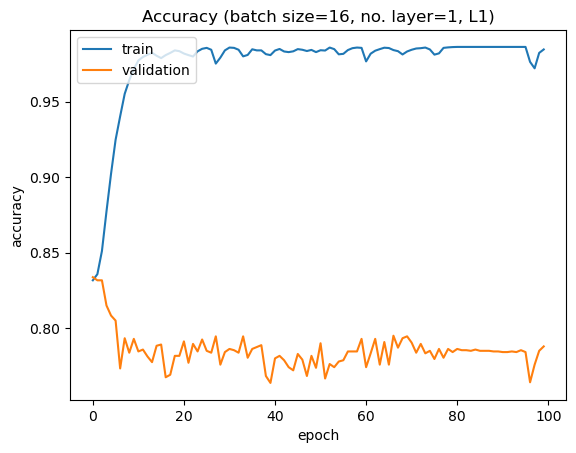

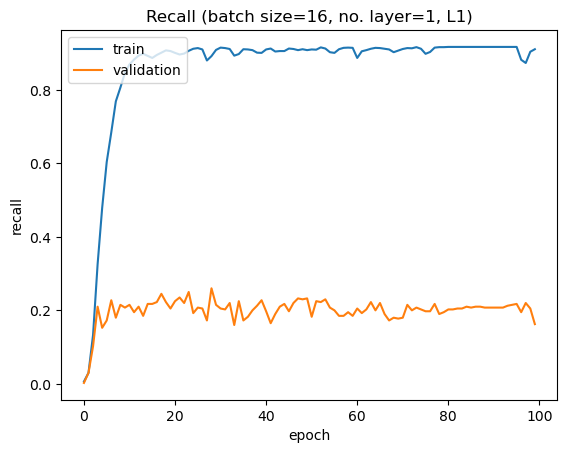

In [9]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [10]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.015
Training Accuracy: 0.984
Training Recall: 0.911


Validation Loss: 0.198
Validation Accuracy: 0.788
Validation Recall: 0.162


### batch size = 32, number of layer = 1

In [11]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.1420 - accuracy: 0.8296 - recall_1: 0.0050 - val_loss: 0.1332 - val_accuracy: 0.8342 - val_recall_1: 0.0100 - 993ms/epoch - 3ms/step
Epoch 2/100
300/300 - 0s - loss: 0.1206 - accuracy: 0.8391 - recall_1: 0.0544 - val_loss: 0.1327 - val_accuracy: 0.8321 - val_recall_1: 0.0075 - 384ms/epoch - 1ms/step
Epoch 3/100
300/300 - 0s - loss: 0.1050 - accuracy: 0.8594 - recall_1: 0.1881 - val_loss: 0.1337 - val_accuracy: 0.8221 - val_recall_1: 0.0725 - 355ms/epoch - 1ms/step
Epoch 4/100
300/300 - 0s - loss: 0.0899 - accuracy: 0.8890 - recall_1: 0.3837 - val_loss: 0.1383 - val_accuracy: 0.8196 - val_recall_1: 0.1100 - 365ms/epoch - 1ms/step
Epoch 5/100
300/300 - 0s - loss: 0.0750 - accuracy: 0.9133 - recall_1: 0.5194 - val_loss: 0.1471 - val_accuracy: 0.8067 - val_recall_1: 0.1325 - 414ms/epoch - 1ms/step
Epoch 6/100
300/300 - 0s - loss: 0.0620 - accuracy: 0.9329 - recall_1: 0.6356 - val_loss: 0.1564 - val_accuracy: 0.7883 - val_recall_1: 0.2025 - 384ms/epoch - 1

Epoch 50/100
300/300 - 0s - loss: 0.0082 - accuracy: 0.9919 - recall_1: 0.9513 - val_loss: 0.2082 - val_accuracy: 0.7621 - val_recall_1: 0.1950 - 397ms/epoch - 1ms/step
Epoch 51/100
300/300 - 0s - loss: 0.0082 - accuracy: 0.9919 - recall_1: 0.9513 - val_loss: 0.2077 - val_accuracy: 0.7625 - val_recall_1: 0.1950 - 398ms/epoch - 1ms/step
Epoch 52/100
300/300 - 0s - loss: 0.0082 - accuracy: 0.9919 - recall_1: 0.9513 - val_loss: 0.2082 - val_accuracy: 0.7608 - val_recall_1: 0.1950 - 434ms/epoch - 1ms/step
Epoch 53/100
300/300 - 0s - loss: 0.0082 - accuracy: 0.9919 - recall_1: 0.9513 - val_loss: 0.2074 - val_accuracy: 0.7625 - val_recall_1: 0.1950 - 419ms/epoch - 1ms/step
Epoch 54/100
300/300 - 0s - loss: 0.0082 - accuracy: 0.9919 - recall_1: 0.9513 - val_loss: 0.2079 - val_accuracy: 0.7625 - val_recall_1: 0.1975 - 401ms/epoch - 1ms/step
Epoch 55/100
300/300 - 0s - loss: 0.0082 - accuracy: 0.9919 - recall_1: 0.9513 - val_loss: 0.2078 - val_accuracy: 0.7633 - val_recall_1: 0.1975 - 397ms/epo

Epoch 99/100
300/300 - 0s - loss: 0.0153 - accuracy: 0.9836 - recall_1: 0.9231 - val_loss: 0.2157 - val_accuracy: 0.7646 - val_recall_1: 0.2025 - 401ms/epoch - 1ms/step
Epoch 100/100
300/300 - 0s - loss: 0.0114 - accuracy: 0.9885 - recall_1: 0.9375 - val_loss: 0.2160 - val_accuracy: 0.7658 - val_recall_1: 0.2325 - 331ms/epoch - 1ms/step


#### Predict

In [12]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

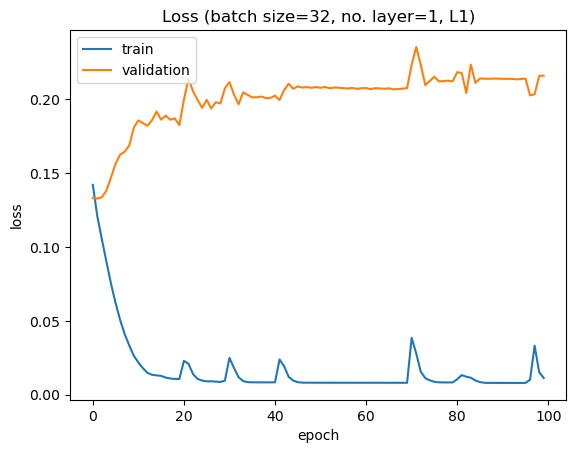

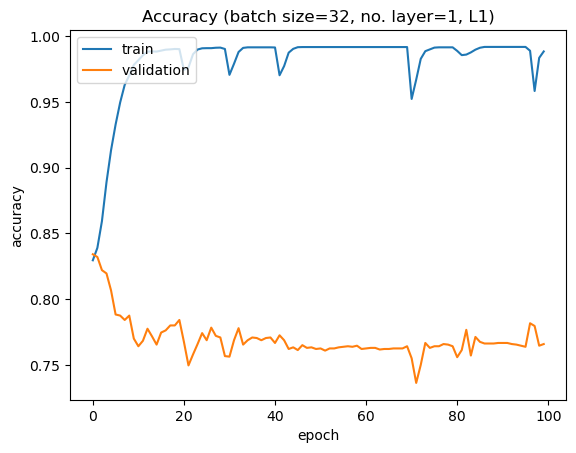

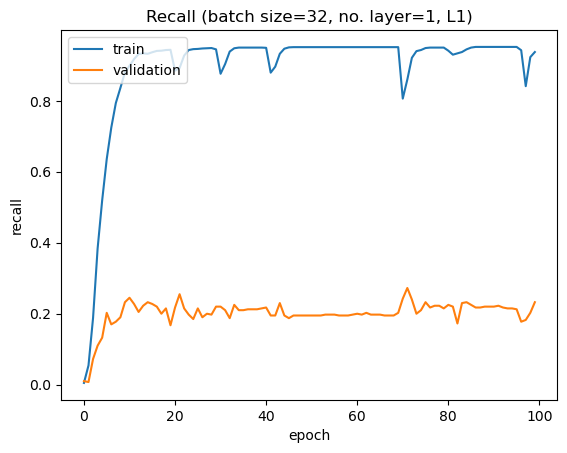

In [13]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [14]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.011
Training Accuracy: 0.989
Training Recall: 0.938


Validation Loss: 0.216
Validation Accuracy: 0.766
Validation Recall: 0.233


### batch size = 64, number of layer = 1

In [15]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.1408 - accuracy: 0.8313 - recall_2: 0.0037 - val_loss: 0.1360 - val_accuracy: 0.8333 - val_recall_2: 0.0000e+00 - 931ms/epoch - 6ms/step
Epoch 2/100
150/150 - 0s - loss: 0.1231 - accuracy: 0.8375 - recall_2: 0.0319 - val_loss: 0.1331 - val_accuracy: 0.8333 - val_recall_2: 0.0075 - 209ms/epoch - 1ms/step
Epoch 3/100
150/150 - 0s - loss: 0.1116 - accuracy: 0.8491 - recall_2: 0.1069 - val_loss: 0.1343 - val_accuracy: 0.8279 - val_recall_2: 0.0350 - 232ms/epoch - 2ms/step
Epoch 4/100
150/150 - 0s - loss: 0.1002 - accuracy: 0.8696 - recall_2: 0.2444 - val_loss: 0.1390 - val_accuracy: 0.8146 - val_recall_2: 0.0975 - 234ms/epoch - 2ms/step
Epoch 5/100
150/150 - 0s - loss: 0.0886 - accuracy: 0.8905 - recall_2: 0.3837 - val_loss: 0.1413 - val_accuracy: 0.8104 - val_recall_2: 0.1075 - 239ms/epoch - 2ms/step
Epoch 6/100
150/150 - 0s - loss: 0.0765 - accuracy: 0.9123 - recall_2: 0.5075 - val_loss: 0.1434 - val_accuracy: 0.8121 - val_recall_2: 0.1150 - 234ms/epoch

Epoch 50/100
150/150 - 0s - loss: 0.0083 - accuracy: 0.9918 - recall_2: 0.9506 - val_loss: 0.1949 - val_accuracy: 0.7767 - val_recall_2: 0.2075 - 221ms/epoch - 1ms/step
Epoch 51/100
150/150 - 0s - loss: 0.0083 - accuracy: 0.9918 - recall_2: 0.9506 - val_loss: 0.1949 - val_accuracy: 0.7771 - val_recall_2: 0.2075 - 218ms/epoch - 1ms/step
Epoch 52/100
150/150 - 0s - loss: 0.0083 - accuracy: 0.9918 - recall_2: 0.9506 - val_loss: 0.1951 - val_accuracy: 0.7775 - val_recall_2: 0.2100 - 207ms/epoch - 1ms/step
Epoch 53/100
150/150 - 0s - loss: 0.0083 - accuracy: 0.9918 - recall_2: 0.9506 - val_loss: 0.1950 - val_accuracy: 0.7767 - val_recall_2: 0.2050 - 216ms/epoch - 1ms/step
Epoch 54/100
150/150 - 0s - loss: 0.0083 - accuracy: 0.9918 - recall_2: 0.9506 - val_loss: 0.1953 - val_accuracy: 0.7771 - val_recall_2: 0.2050 - 238ms/epoch - 2ms/step
Epoch 55/100
150/150 - 0s - loss: 0.0083 - accuracy: 0.9918 - recall_2: 0.9506 - val_loss: 0.1952 - val_accuracy: 0.7771 - val_recall_2: 0.2050 - 243ms/epo

Epoch 99/100
150/150 - 0s - loss: 0.0080 - accuracy: 0.9920 - recall_2: 0.9519 - val_loss: 0.2005 - val_accuracy: 0.7775 - val_recall_2: 0.2075 - 195ms/epoch - 1ms/step
Epoch 100/100
150/150 - 0s - loss: 0.0080 - accuracy: 0.9920 - recall_2: 0.9519 - val_loss: 0.2005 - val_accuracy: 0.7775 - val_recall_2: 0.2075 - 214ms/epoch - 1ms/step


#### Predict

In [16]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

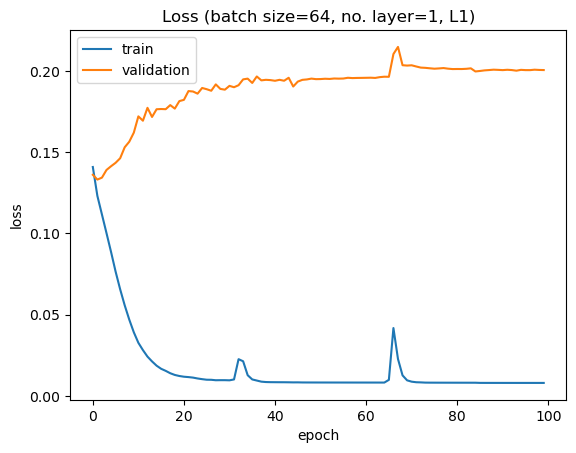

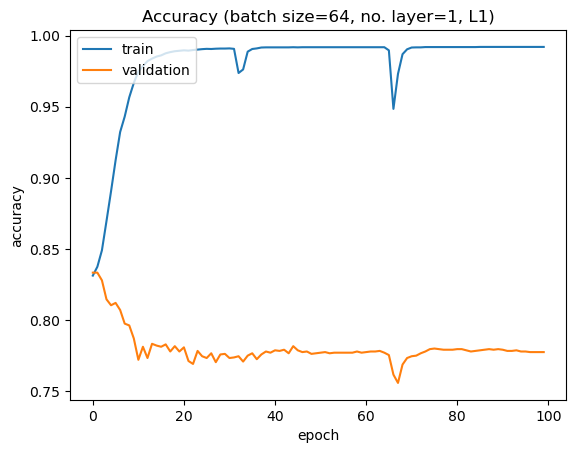

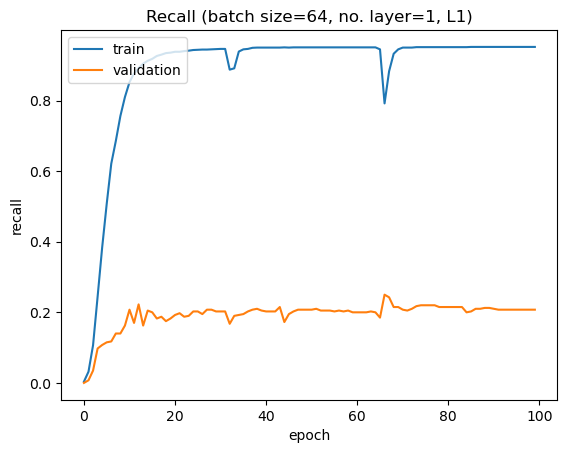

In [17]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [18]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.008
Training Accuracy: 0.992
Training Recall: 0.952


Validation Loss: 0.2
Validation Accuracy: 0.777
Validation Recall: 0.207


### batch size = 16, number of layer = 2

In [19]:
def create_shared_network(input_shape):
    model = keras.Sequential([
        
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1\\vgg_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1\\vgg_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [20]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.1595 - accuracy: 0.8274 - recall_3: 0.0050 - val_loss: 0.1659 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1467 - accuracy: 0.8332 - recall_3: 0.0000e+00 - val_loss: 0.1578 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 659ms/epoch - 1ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1425 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1446 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 649ms/epoch - 1ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1415 - accuracy: 0.8332 - recall_3: 0.0000e+00 - val_loss: 0.1406 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 658ms/epoch - 1ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1414 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1415 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 627ms/epoch - 1ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1405 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1374 - val_accuracy: 0.8333 - v

600/600 - 1s - loss: 0.1342 - accuracy: 0.8334 - recall_3: 0.0119 - val_loss: 0.1365 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 700ms/epoch - 1ms/step
Epoch 49/100
600/600 - 1s - loss: 0.1340 - accuracy: 0.8333 - recall_3: 0.0144 - val_loss: 0.1354 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 699ms/epoch - 1ms/step
Epoch 50/100
600/600 - 1s - loss: 0.1334 - accuracy: 0.8338 - recall_3: 0.0181 - val_loss: 0.1358 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 673ms/epoch - 1ms/step
Epoch 51/100
600/600 - 1s - loss: 0.1353 - accuracy: 0.8333 - recall_3: 0.0081 - val_loss: 0.1353 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 704ms/epoch - 1ms/step
Epoch 52/100
600/600 - 1s - loss: 0.1339 - accuracy: 0.8338 - recall_3: 0.0131 - val_loss: 0.1358 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 695ms/epoch - 1ms/step
Epoch 53/100
600/600 - 1s - loss: 0.1341 - accuracy: 0.8342 - recall_3: 0.0144 - val_loss: 0.1361 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 

Epoch 96/100
600/600 - 1s - loss: 0.1331 - accuracy: 0.8346 - recall_3: 0.0219 - val_loss: 0.1371 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 729ms/epoch - 1ms/step
Epoch 97/100
600/600 - 1s - loss: 0.1330 - accuracy: 0.8326 - recall_3: 0.0219 - val_loss: 0.1363 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 721ms/epoch - 1ms/step
Epoch 98/100
600/600 - 1s - loss: 0.1334 - accuracy: 0.8323 - recall_3: 0.0113 - val_loss: 0.1363 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 739ms/epoch - 1ms/step
Epoch 99/100
600/600 - 1s - loss: 0.1326 - accuracy: 0.8352 - recall_3: 0.0281 - val_loss: 0.1367 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 708ms/epoch - 1ms/step
Epoch 100/100
600/600 - 1s - loss: 0.1329 - accuracy: 0.8332 - recall_3: 0.0244 - val_loss: 0.1369 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 741ms/epoch - 1ms/step


#### Predict

In [21]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

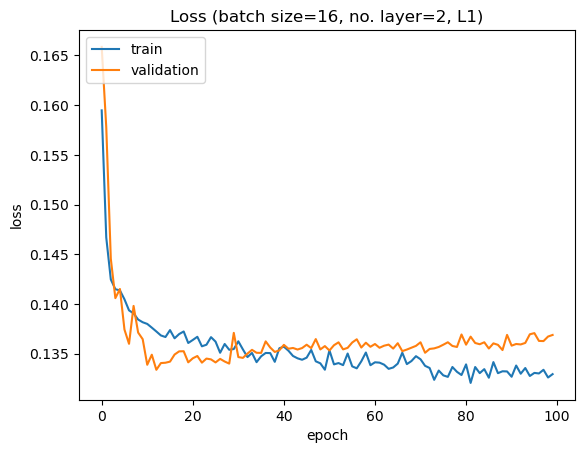

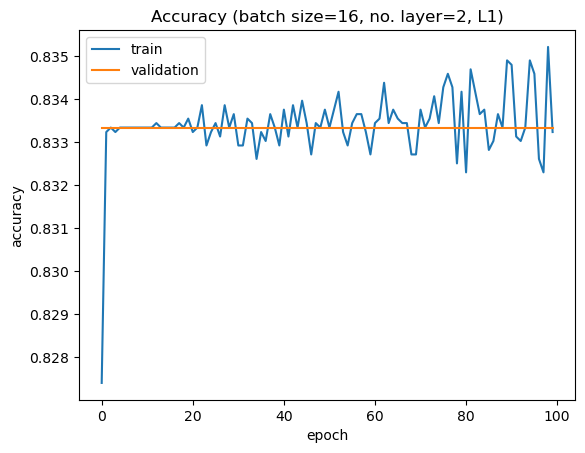

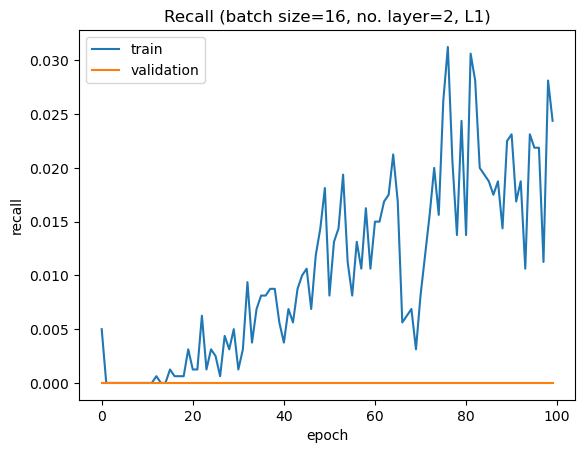

In [22]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [23]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.133
Training Accuracy: 0.833
Training Recall: 0.024


Validation Loss: 0.137
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [24]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.1522 - accuracy: 0.8294 - recall_4: 0.0094 - val_loss: 0.1753 - val_accuracy: 0.8329 - val_recall_4: 0.0050 - 1s/epoch - 4ms/step
Epoch 2/100
300/300 - 0s - loss: 0.1462 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1595 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 401ms/epoch - 1ms/step
Epoch 3/100
300/300 - 0s - loss: 0.1442 - accuracy: 0.8332 - recall_4: 0.0000e+00 - val_loss: 0.1477 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 419ms/epoch - 1ms/step
Epoch 4/100
300/300 - 0s - loss: 0.1428 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1636 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 388ms/epoch - 1ms/step
Epoch 5/100
300/300 - 0s - loss: 0.1418 - accuracy: 0.8332 - recall_4: 0.0000e+00 - val_loss: 0.1558 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 409ms/epoch - 1ms/step
Epoch 6/100
300/300 - 0s - loss: 0.1425 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1465 - val_accuracy: 0.8333 - val_r

Epoch 49/100
300/300 - 0s - loss: 0.1332 - accuracy: 0.8336 - recall_4: 0.0088 - val_loss: 0.1336 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 353ms/epoch - 1ms/step
Epoch 50/100
300/300 - 0s - loss: 0.1327 - accuracy: 0.8335 - recall_4: 0.0156 - val_loss: 0.1331 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 348ms/epoch - 1ms/step
Epoch 51/100
300/300 - 0s - loss: 0.1329 - accuracy: 0.8333 - recall_4: 0.0125 - val_loss: 0.1332 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 372ms/epoch - 1ms/step
Epoch 52/100
300/300 - 0s - loss: 0.1326 - accuracy: 0.8341 - recall_4: 0.0188 - val_loss: 0.1340 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 370ms/epoch - 1ms/step
Epoch 53/100
300/300 - 0s - loss: 0.1317 - accuracy: 0.8347 - recall_4: 0.0300 - val_loss: 0.1336 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 371ms/epoch - 1ms/step
Epoch 54/100
300/300 - 0s - loss: 0.1322 - accuracy: 0.8338 - recall_4: 0.0194 - val_loss: 0.1338 - val_accuracy: 0.8333 - val_recall_4

Epoch 97/100
300/300 - 0s - loss: 0.1300 - accuracy: 0.8352 - recall_4: 0.0344 - val_loss: 0.1337 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 368ms/epoch - 1ms/step
Epoch 98/100
300/300 - 0s - loss: 0.1305 - accuracy: 0.8344 - recall_4: 0.0331 - val_loss: 0.1334 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 363ms/epoch - 1ms/step
Epoch 99/100
300/300 - 0s - loss: 0.1306 - accuracy: 0.8341 - recall_4: 0.0288 - val_loss: 0.1335 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 367ms/epoch - 1ms/step
Epoch 100/100
300/300 - 0s - loss: 0.1300 - accuracy: 0.8368 - recall_4: 0.0369 - val_loss: 0.1336 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 383ms/epoch - 1ms/step


#### Predict

In [25]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

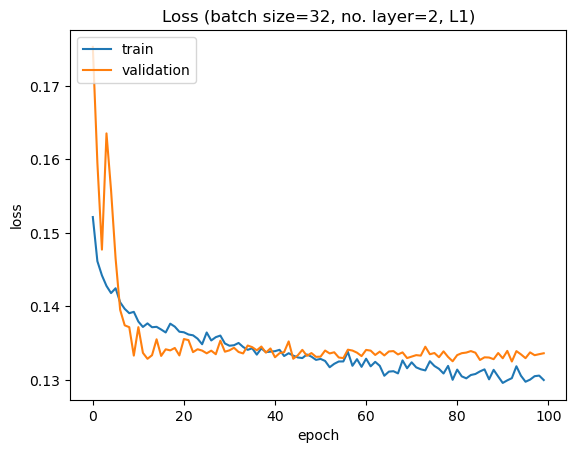

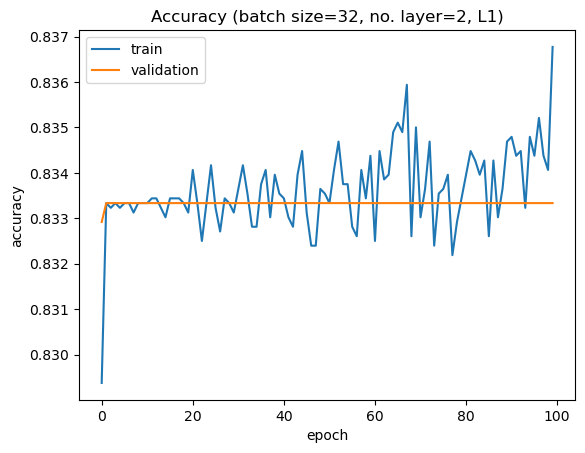

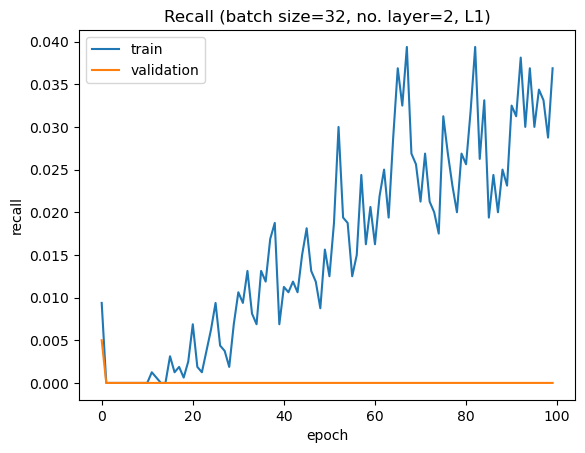

In [26]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [27]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.13
Training Accuracy: 0.837
Training Recall: 0.037


Validation Loss: 0.134
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [28]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.1551 - accuracy: 0.8281 - recall_5: 0.0094 - val_loss: 0.1491 - val_accuracy: 0.8321 - val_recall_5: 0.0000e+00 - 895ms/epoch - 6ms/step
Epoch 2/100
150/150 - 0s - loss: 0.1468 - accuracy: 0.8323 - recall_5: 0.0000e+00 - val_loss: 0.1518 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 203ms/epoch - 1ms/step
Epoch 3/100
150/150 - 0s - loss: 0.1435 - accuracy: 0.8332 - recall_5: 0.0000e+00 - val_loss: 0.1485 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 215ms/epoch - 1ms/step
Epoch 4/100
150/150 - 0s - loss: 0.1437 - accuracy: 0.8332 - recall_5: 0.0000e+00 - val_loss: 0.1460 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 209ms/epoch - 1ms/step
Epoch 5/100
150/150 - 0s - loss: 0.1411 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1451 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 200ms/epoch - 1ms/step
Epoch 6/100
150/150 - 0s - loss: 0.1404 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1436 - val_accuracy: 0.8333 

Epoch 48/100
150/150 - 0s - loss: 0.1303 - accuracy: 0.8338 - recall_5: 0.0131 - val_loss: 0.1321 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 202ms/epoch - 1ms/step
Epoch 49/100
150/150 - 0s - loss: 0.1310 - accuracy: 0.8332 - recall_5: 0.0106 - val_loss: 0.1323 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 225ms/epoch - 1ms/step
Epoch 50/100
150/150 - 0s - loss: 0.1301 - accuracy: 0.8322 - recall_5: 0.0156 - val_loss: 0.1312 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 230ms/epoch - 2ms/step
Epoch 51/100
150/150 - 0s - loss: 0.1302 - accuracy: 0.8341 - recall_5: 0.0162 - val_loss: 0.1326 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 206ms/epoch - 1ms/step
Epoch 52/100
150/150 - 0s - loss: 0.1300 - accuracy: 0.8331 - recall_5: 0.0194 - val_loss: 0.1316 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 213ms/epoch - 1ms/step
Epoch 53/100
150/150 - 0s - loss: 0.1301 - accuracy: 0.8351 - recall_5: 0.0237 - val_loss: 0.1313 - val_accuracy: 0.8333 - val_recall_5

Epoch 96/100
150/150 - 0s - loss: 0.1259 - accuracy: 0.8351 - recall_5: 0.0362 - val_loss: 0.1317 - val_accuracy: 0.8329 - val_recall_5: 0.0000e+00 - 221ms/epoch - 1ms/step
Epoch 97/100
150/150 - 0s - loss: 0.1261 - accuracy: 0.8324 - recall_5: 0.0275 - val_loss: 0.1319 - val_accuracy: 0.8329 - val_recall_5: 0.0000e+00 - 201ms/epoch - 1ms/step
Epoch 98/100
150/150 - 0s - loss: 0.1262 - accuracy: 0.8333 - recall_5: 0.0206 - val_loss: 0.1310 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 203ms/epoch - 1ms/step
Epoch 99/100
150/150 - 0s - loss: 0.1244 - accuracy: 0.8329 - recall_5: 0.0262 - val_loss: 0.1315 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 230ms/epoch - 2ms/step
Epoch 100/100
150/150 - 0s - loss: 0.1281 - accuracy: 0.8325 - recall_5: 0.0181 - val_loss: 0.1313 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 205ms/epoch - 1ms/step


#### Predict

In [29]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

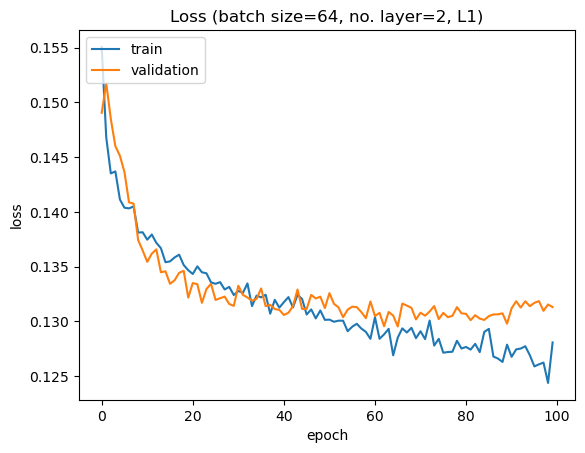

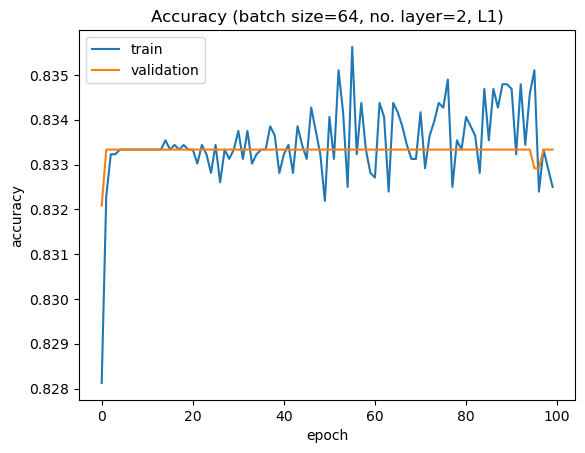

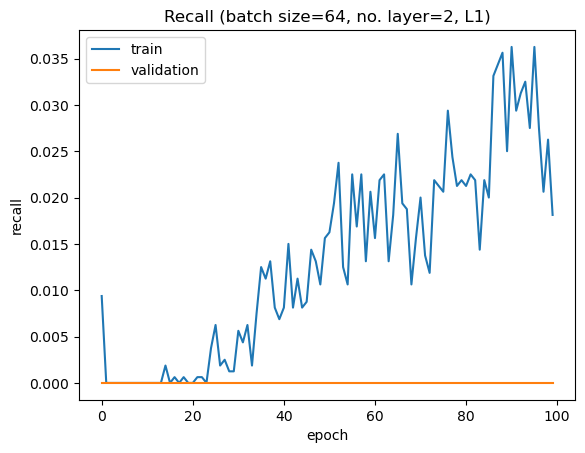

In [30]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [31]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.128
Training Accuracy: 0.832
Training Recall: 0.018


Validation Loss: 0.131
Validation Accuracy: 0.833
Validation Recall: 0.0


## resnet

In [32]:
# left_train = np.load('vgg_train_left.npy')
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

left_train = np.load('resnet_train_left.npy')
right_train = np.load('resnet_train_right.npy')
left_test = np.load('resnet_test_left.npy')
right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [33]:
path = ".\COMP90086_2023_TLLdataset\\train\\left"
dir_list = os.listdir(path)
train_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\train\\right"
dir_list = os.listdir(path)
train_right_images_list = dir_list

left_array_dict = {}
for i in range(len(train_left_images_list)):
    left_array_dict[train_left_images_list[i][:3]] = left_train[i]
    
right_array_dict = {}
for i in range(len(train_right_images_list)):
    right_array_dict[train_right_images_list[i][:3]] = right_train[i]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [34]:
# input_shape = (512,)
input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1\\resnet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1\\resnet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [35]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1570 - accuracy: 0.8263 - recall_6: 0.0125 - val_loss: 0.1476 - val_accuracy: 0.8304 - val_recall_6: 0.0200 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1374 - accuracy: 0.8327 - recall_6: 0.0506 - val_loss: 0.1377 - val_accuracy: 0.8329 - val_recall_6: 0.0150 - 948ms/epoch - 2ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1232 - accuracy: 0.8447 - recall_6: 0.1006 - val_loss: 0.1365 - val_accuracy: 0.8317 - val_recall_6: 0.0150 - 949ms/epoch - 2ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1169 - accuracy: 0.8506 - recall_6: 0.1462 - val_loss: 0.1394 - val_accuracy: 0.8283 - val_recall_6: 0.0425 - 932ms/epoch - 2ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1078 - accuracy: 0.8621 - recall_6: 0.2406 - val_loss: 0.1479 - val_accuracy: 0.8146 - val_recall_6: 0.0625 - 901ms/epoch - 2ms/step
Epoch 6/100
600/600 - 1s - loss: 0.0991 - accuracy: 0.8797 - recall_6: 0.3544 - val_loss: 0.1490 - val_accuracy: 0.8221 - val_recall_6: 0.0675 - 935ms/epoch - 2ms/

Epoch 50/100
600/600 - 1s - loss: 0.0320 - accuracy: 0.9668 - recall_6: 0.8150 - val_loss: 0.2081 - val_accuracy: 0.7837 - val_recall_6: 0.0975 - 930ms/epoch - 2ms/step
Epoch 51/100
600/600 - 1s - loss: 0.0314 - accuracy: 0.9681 - recall_6: 0.8231 - val_loss: 0.2192 - val_accuracy: 0.7667 - val_recall_6: 0.1075 - 963ms/epoch - 2ms/step
Epoch 52/100
600/600 - 1s - loss: 0.0316 - accuracy: 0.9667 - recall_6: 0.8150 - val_loss: 0.2160 - val_accuracy: 0.7700 - val_recall_6: 0.1125 - 937ms/epoch - 2ms/step
Epoch 53/100
600/600 - 1s - loss: 0.0324 - accuracy: 0.9657 - recall_6: 0.8144 - val_loss: 0.2126 - val_accuracy: 0.7746 - val_recall_6: 0.1000 - 949ms/epoch - 2ms/step
Epoch 54/100
600/600 - 1s - loss: 0.0345 - accuracy: 0.9633 - recall_6: 0.8087 - val_loss: 0.2147 - val_accuracy: 0.7733 - val_recall_6: 0.1175 - 927ms/epoch - 2ms/step
Epoch 55/100
600/600 - 1s - loss: 0.0323 - accuracy: 0.9665 - recall_6: 0.8144 - val_loss: 0.2146 - val_accuracy: 0.7729 - val_recall_6: 0.1275 - 919ms/epo

Epoch 99/100
600/600 - 1s - loss: 0.0291 - accuracy: 0.9704 - recall_6: 0.8288 - val_loss: 0.2094 - val_accuracy: 0.7812 - val_recall_6: 0.1100 - 960ms/epoch - 2ms/step
Epoch 100/100
600/600 - 1s - loss: 0.0296 - accuracy: 0.9700 - recall_6: 0.8300 - val_loss: 0.2171 - val_accuracy: 0.7725 - val_recall_6: 0.1400 - 948ms/epoch - 2ms/step


#### Predict

In [36]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

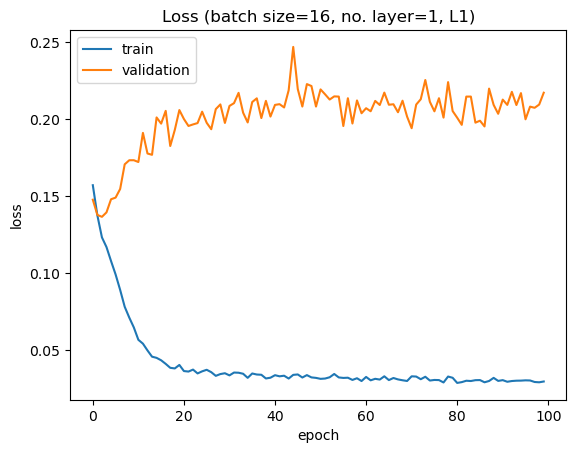

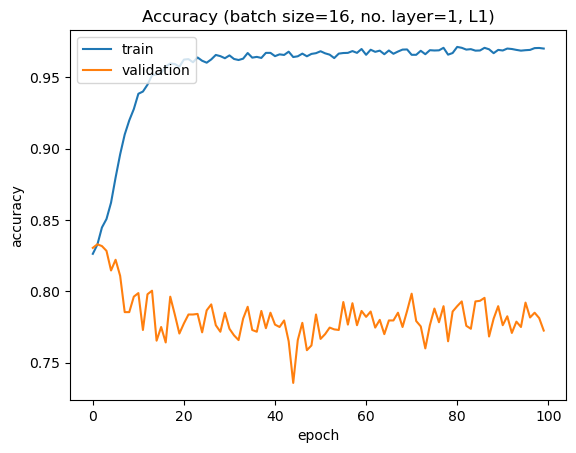

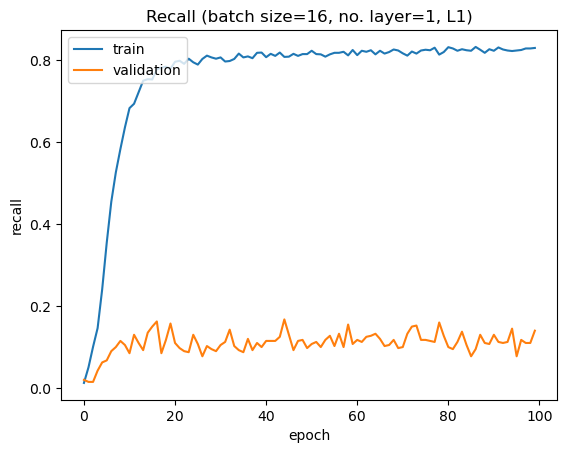

In [37]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [38]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.03
Training Accuracy: 0.97
Training Recall: 0.83


Validation Loss: 0.217
Validation Accuracy: 0.772
Validation Recall: 0.14


### batch size = 32, number of layer = 1

In [39]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.1673 - accuracy: 0.8285 - recall_7: 0.0050 - val_loss: 0.1659 - val_accuracy: 0.8333 - val_recall_7: 0.0000e+00 - 1s/epoch - 4ms/step
Epoch 2/100
300/300 - 1s - loss: 0.1568 - accuracy: 0.8277 - recall_7: 0.0194 - val_loss: 0.1509 - val_accuracy: 0.8313 - val_recall_7: 0.0025 - 543ms/epoch - 2ms/step
Epoch 3/100
300/300 - 1s - loss: 0.1366 - accuracy: 0.8364 - recall_7: 0.0719 - val_loss: 0.1414 - val_accuracy: 0.8292 - val_recall_7: 0.0000e+00 - 524ms/epoch - 2ms/step
Epoch 4/100
300/300 - 1s - loss: 0.1211 - accuracy: 0.8468 - recall_7: 0.1281 - val_loss: 0.1420 - val_accuracy: 0.8175 - val_recall_7: 0.0400 - 566ms/epoch - 2ms/step
Epoch 5/100
300/300 - 1s - loss: 0.1095 - accuracy: 0.8628 - recall_7: 0.2319 - val_loss: 0.1471 - val_accuracy: 0.8200 - val_recall_7: 0.0500 - 526ms/epoch - 2ms/step
Epoch 6/100
300/300 - 1s - loss: 0.0968 - accuracy: 0.8803 - recall_7: 0.3619 - val_loss: 0.1564 - val_accuracy: 0.8050 - val_recall_7: 0.0550 - 556ms/epoc

Epoch 50/100
300/300 - 1s - loss: 0.0238 - accuracy: 0.9751 - recall_7: 0.8619 - val_loss: 0.2178 - val_accuracy: 0.7663 - val_recall_7: 0.1200 - 531ms/epoch - 2ms/step
Epoch 51/100
300/300 - 1s - loss: 0.0269 - accuracy: 0.9711 - recall_7: 0.8500 - val_loss: 0.2185 - val_accuracy: 0.7658 - val_recall_7: 0.1000 - 563ms/epoch - 2ms/step
Epoch 52/100
300/300 - 1s - loss: 0.0235 - accuracy: 0.9759 - recall_7: 0.8631 - val_loss: 0.2104 - val_accuracy: 0.7775 - val_recall_7: 0.1050 - 537ms/epoch - 2ms/step
Epoch 53/100
300/300 - 1s - loss: 0.0219 - accuracy: 0.9781 - recall_7: 0.8737 - val_loss: 0.2172 - val_accuracy: 0.7663 - val_recall_7: 0.1100 - 540ms/epoch - 2ms/step
Epoch 54/100
300/300 - 1s - loss: 0.0236 - accuracy: 0.9755 - recall_7: 0.8656 - val_loss: 0.2229 - val_accuracy: 0.7638 - val_recall_7: 0.1175 - 556ms/epoch - 2ms/step
Epoch 55/100
300/300 - 1s - loss: 0.0255 - accuracy: 0.9732 - recall_7: 0.8581 - val_loss: 0.2192 - val_accuracy: 0.7675 - val_recall_7: 0.1275 - 566ms/epo

Epoch 99/100
300/300 - 1s - loss: 0.0234 - accuracy: 0.9756 - recall_7: 0.8625 - val_loss: 0.1997 - val_accuracy: 0.7942 - val_recall_7: 0.0900 - 545ms/epoch - 2ms/step
Epoch 100/100
300/300 - 1s - loss: 0.0240 - accuracy: 0.9748 - recall_7: 0.8631 - val_loss: 0.2104 - val_accuracy: 0.7775 - val_recall_7: 0.1100 - 539ms/epoch - 2ms/step


#### Predict

In [40]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

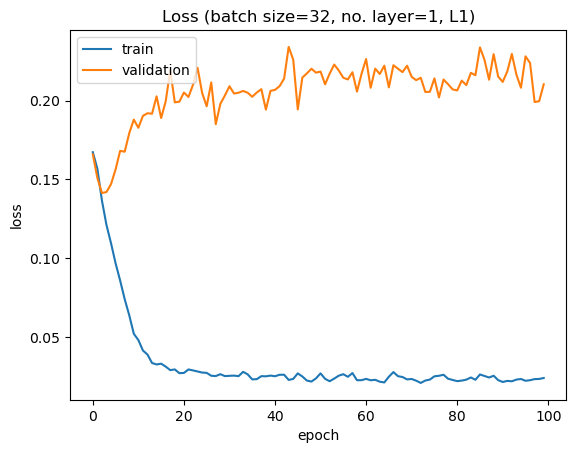

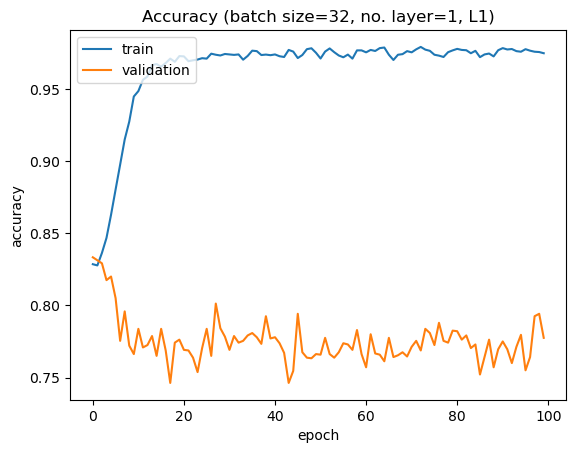

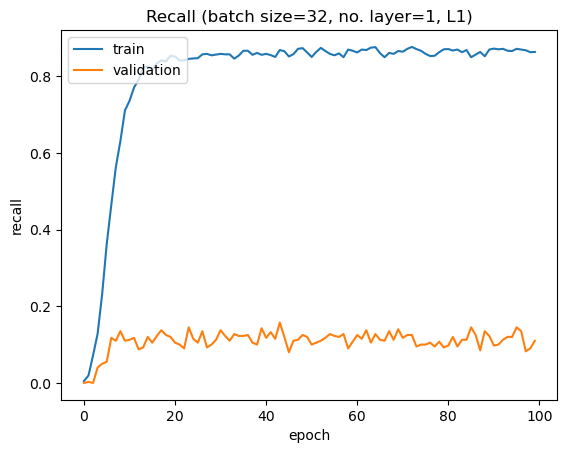

In [41]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [42]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.024
Training Accuracy: 0.975
Training Recall: 0.863


Validation Loss: 0.21
Validation Accuracy: 0.777
Validation Recall: 0.11


### batch size = 64, number of layer = 1

In [43]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.1669 - accuracy: 0.8302 - recall_8: 0.0044 - val_loss: 0.1651 - val_accuracy: 0.8325 - val_recall_8: 0.0000e+00 - 1s/epoch - 8ms/step
Epoch 2/100
150/150 - 0s - loss: 0.1616 - accuracy: 0.8310 - recall_8: 0.0219 - val_loss: 0.1641 - val_accuracy: 0.8317 - val_recall_8: 0.0050 - 325ms/epoch - 2ms/step
Epoch 3/100
150/150 - 0s - loss: 0.1544 - accuracy: 0.8354 - recall_8: 0.0731 - val_loss: 0.1624 - val_accuracy: 0.8338 - val_recall_8: 0.0200 - 329ms/epoch - 2ms/step
Epoch 4/100
150/150 - 0s - loss: 0.1436 - accuracy: 0.8478 - recall_8: 0.1431 - val_loss: 0.1627 - val_accuracy: 0.8229 - val_recall_8: 0.0400 - 311ms/epoch - 2ms/step
Epoch 5/100
150/150 - 0s - loss: 0.1325 - accuracy: 0.8578 - recall_8: 0.2037 - val_loss: 0.1652 - val_accuracy: 0.8129 - val_recall_8: 0.0400 - 313ms/epoch - 2ms/step
Epoch 6/100
150/150 - 0s - loss: 0.1227 - accuracy: 0.8677 - recall_8: 0.2619 - val_loss: 0.1661 - val_accuracy: 0.8087 - val_recall_8: 0.0700 - 320ms/epoch - 

Epoch 50/100
150/150 - 0s - loss: 0.0494 - accuracy: 0.9501 - recall_8: 0.7094 - val_loss: 0.1865 - val_accuracy: 0.8021 - val_recall_8: 0.0900 - 342ms/epoch - 2ms/step
Epoch 51/100
150/150 - 0s - loss: 0.0478 - accuracy: 0.9524 - recall_8: 0.7163 - val_loss: 0.1914 - val_accuracy: 0.7979 - val_recall_8: 0.0850 - 330ms/epoch - 2ms/step
Epoch 52/100
150/150 - 0s - loss: 0.0490 - accuracy: 0.9504 - recall_8: 0.7138 - val_loss: 0.1906 - val_accuracy: 0.7979 - val_recall_8: 0.0775 - 327ms/epoch - 2ms/step
Epoch 53/100
150/150 - 0s - loss: 0.0490 - accuracy: 0.9504 - recall_8: 0.7138 - val_loss: 0.1997 - val_accuracy: 0.7854 - val_recall_8: 0.1050 - 339ms/epoch - 2ms/step
Epoch 54/100
150/150 - 0s - loss: 0.0489 - accuracy: 0.9507 - recall_8: 0.7144 - val_loss: 0.1922 - val_accuracy: 0.7942 - val_recall_8: 0.0925 - 331ms/epoch - 2ms/step
Epoch 55/100
150/150 - 0s - loss: 0.0475 - accuracy: 0.9520 - recall_8: 0.7175 - val_loss: 0.1932 - val_accuracy: 0.7929 - val_recall_8: 0.0825 - 340ms/epo

Epoch 99/100
150/150 - 0s - loss: 0.0525 - accuracy: 0.9460 - recall_8: 0.7019 - val_loss: 0.2045 - val_accuracy: 0.7833 - val_recall_8: 0.1175 - 339ms/epoch - 2ms/step
Epoch 100/100
150/150 - 0s - loss: 0.0487 - accuracy: 0.9502 - recall_8: 0.7138 - val_loss: 0.1902 - val_accuracy: 0.8008 - val_recall_8: 0.1000 - 331ms/epoch - 2ms/step


#### Predict

In [44]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

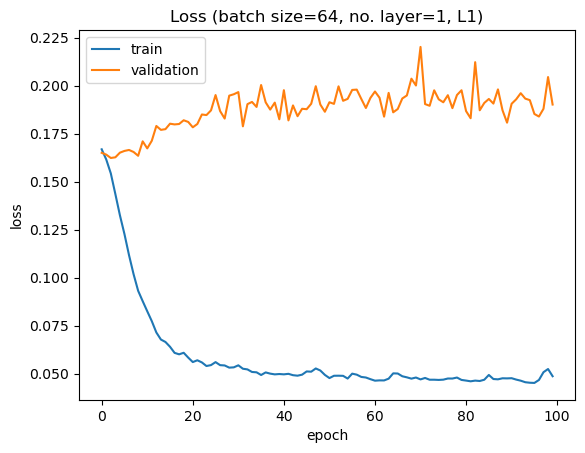

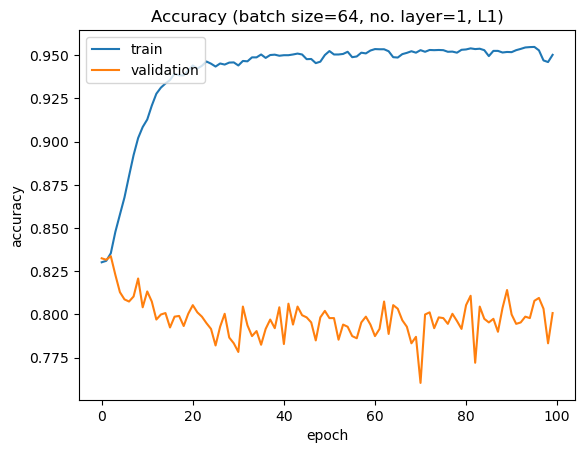

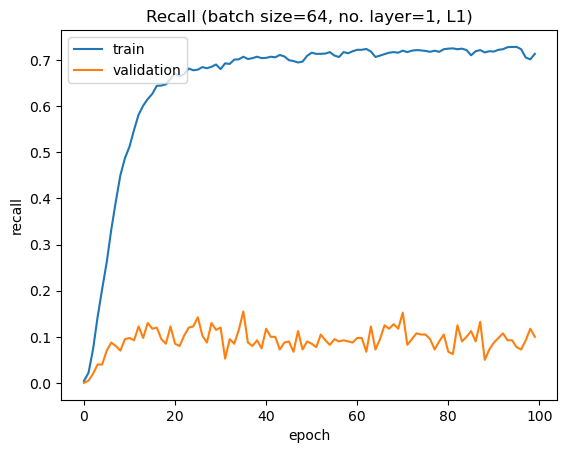

In [45]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [46]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.049
Training Accuracy: 0.95
Training Recall: 0.714


Validation Loss: 0.19
Validation Accuracy: 0.801
Validation Recall: 0.1


### batch size = 16, number of layer = 2

In [47]:
def create_shared_network(input_shape):
    model = keras.Sequential([
        
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1\\resnet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1\\resnet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [48]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1675 - accuracy: 0.8320 - recall_9: 0.0000e+00 - val_loss: 0.1641 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1668 - accuracy: 0.8332 - recall_9: 6.2500e-04 - val_loss: 0.1635 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 941ms/epoch - 2ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8332 - recall_9: 6.2500e-04 - val_loss: 0.1657 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 908ms/epoch - 2ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1668 - accuracy: 0.8332 - recall_9: 0.0000e+00 - val_loss: 0.1659 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 924ms/epoch - 2ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8332 - recall_9: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 936ms/epoch - 2ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333

Epoch 48/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 916ms/epoch - 2ms/step
Epoch 49/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 904ms/epoch - 2ms/step
Epoch 50/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 932ms/epoch - 2ms/step
Epoch 51/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 888ms/epoch - 1ms/step
Epoch 52/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 907ms/epoch - 2ms/step
Epoch 53/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1666 - val_accurac

Epoch 95/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 966ms/epoch - 2ms/step
Epoch 96/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 928ms/epoch - 2ms/step
Epoch 97/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 933ms/epoch - 2ms/step
Epoch 98/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 930ms/epoch - 2ms/step
Epoch 99/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 921ms/epoch - 2ms/step
Epoch 100/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accura

#### Predict

In [49]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

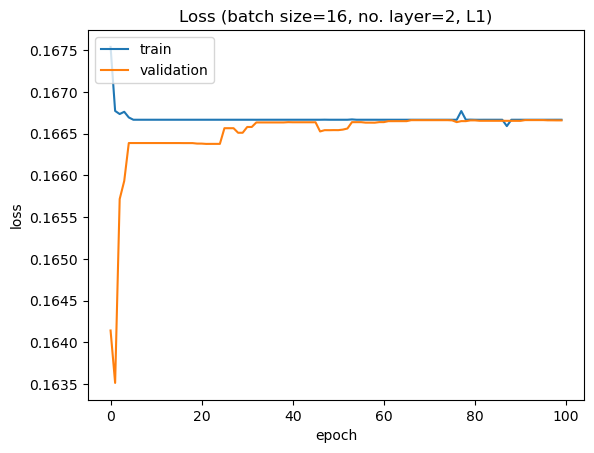

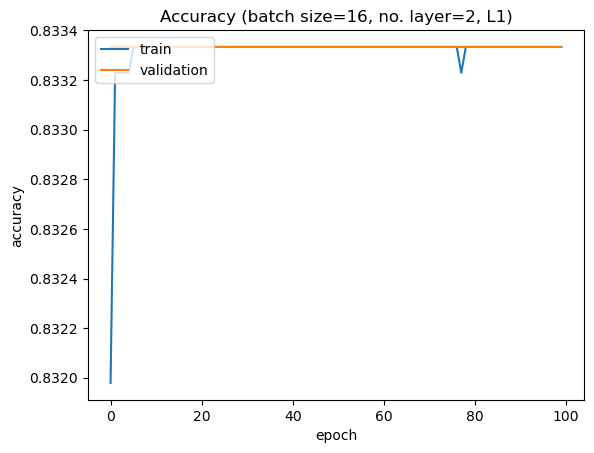

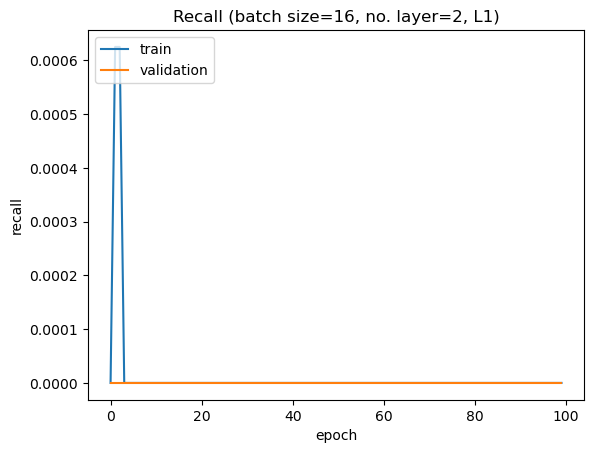

In [50]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [51]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [52]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 2s - loss: 0.1675 - accuracy: 0.8304 - recall_10: 0.0056 - val_loss: 0.1630 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 2s/epoch - 6ms/step
Epoch 2/100
300/300 - 1s - loss: 0.1666 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1628 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 640ms/epoch - 2ms/step
Epoch 3/100
300/300 - 1s - loss: 0.1668 - accuracy: 0.8330 - recall_10: 0.0000e+00 - val_loss: 0.1635 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 611ms/epoch - 2ms/step
Epoch 4/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8332 - recall_10: 0.0000e+00 - val_loss: 0.1646 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 638ms/epoch - 2ms/step
Epoch 5/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1646 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 612ms/epoch - 2ms/step
Epoch 6/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1637 - val_accuracy:

Epoch 47/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 637ms/epoch - 2ms/step
Epoch 48/100
300/300 - 1s - loss: 0.1666 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 609ms/epoch - 2ms/step
Epoch 49/100
300/300 - 1s - loss: 0.1666 - accuracy: 0.8334 - recall_10: 6.2500e-04 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 616ms/epoch - 2ms/step
Epoch 50/100
300/300 - 1s - loss: 0.1668 - accuracy: 0.8332 - recall_10: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 674ms/epoch - 2ms/step
Epoch 51/100
300/300 - 1s - loss: 0.1666 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 620ms/epoch - 2ms/step
Epoch 52/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1664 - 

Epoch 93/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 585ms/epoch - 2ms/step
Epoch 94/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 586ms/epoch - 2ms/step
Epoch 95/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 589ms/epoch - 2ms/step
Epoch 96/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 591ms/epoch - 2ms/step
Epoch 97/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 613ms/epoch - 2ms/step
Epoch 98/100
300/300 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - 

#### Predict

In [53]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

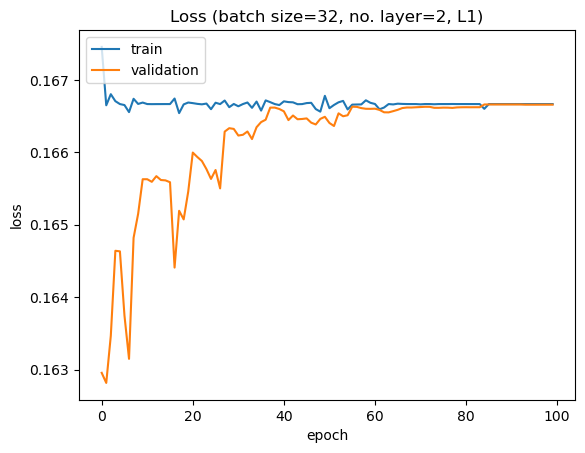

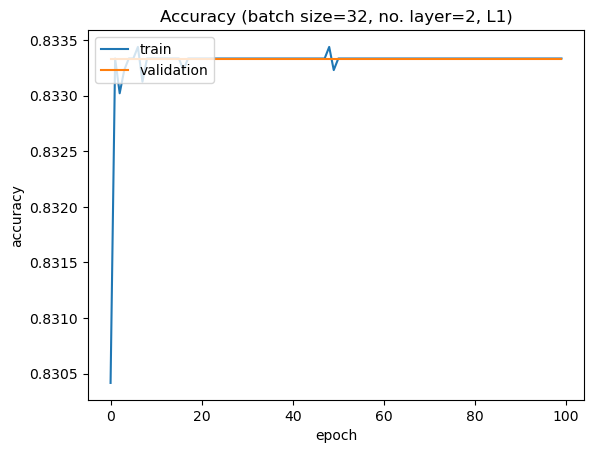

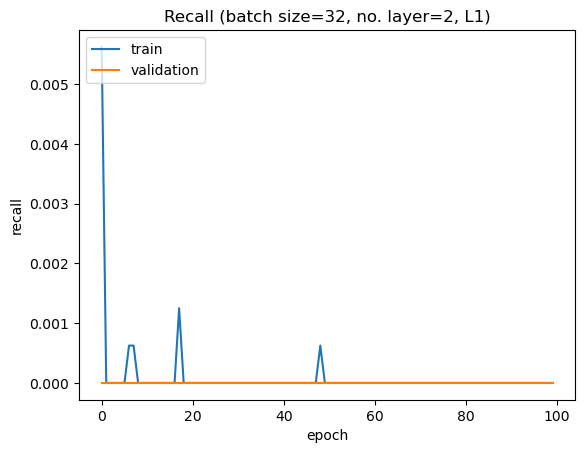

In [54]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [55]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [56]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.1746 - accuracy: 0.8227 - recall_11: 0.0206 - val_loss: 0.1648 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 1s/epoch - 8ms/step
Epoch 2/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8332 - recall_11: 0.0000e+00 - val_loss: 0.1648 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 320ms/epoch - 2ms/step
Epoch 3/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8329 - recall_11: 0.0000e+00 - val_loss: 0.1647 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 343ms/epoch - 2ms/step
Epoch 4/100
150/150 - 0s - loss: 0.1669 - accuracy: 0.8329 - recall_11: 6.2500e-04 - val_loss: 0.1641 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 376ms/epoch - 3ms/step
Epoch 5/100
150/150 - 0s - loss: 0.1668 - accuracy: 0.8330 - recall_11: 0.0000e+00 - val_loss: 0.1656 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 386ms/epoch - 3ms/step
Epoch 6/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1656 - val_accuracy:

Epoch 47/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 373ms/epoch - 2ms/step
Epoch 48/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 366ms/epoch - 2ms/step
Epoch 49/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 367ms/epoch - 2ms/step
Epoch 50/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 363ms/epoch - 2ms/step
Epoch 51/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 370ms/epoch - 2ms/step
Epoch 52/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1665 - 

Epoch 93/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 381ms/epoch - 3ms/step
Epoch 94/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 370ms/epoch - 2ms/step
Epoch 95/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 366ms/epoch - 2ms/step
Epoch 96/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 396ms/epoch - 3ms/step
Epoch 97/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 372ms/epoch - 2ms/step
Epoch 98/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - 

#### Predict

In [57]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

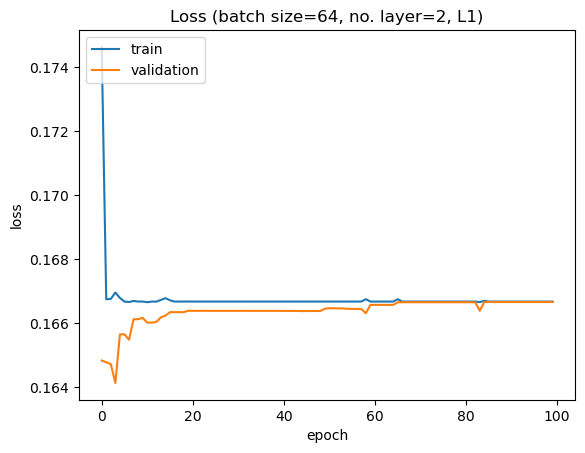

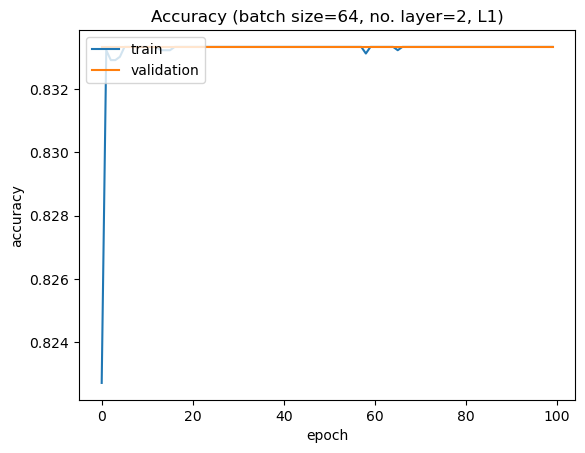

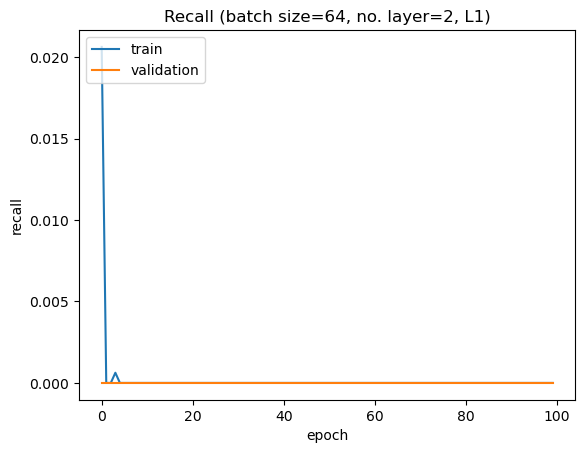

In [58]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [59]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


## densenet

In [60]:
# left_train = np.load('vgg_train_left.npy')
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

left_train = np.load('densenet_train_left.npy')
right_train = np.load('densenet_train_right.npy')
left_test = np.load('densenet_test_left.npy')
right_test = np.load('densenet_test_right.npy')

In [61]:
path = ".\COMP90086_2023_TLLdataset\\train\\left"
dir_list = os.listdir(path)
train_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\train\\right"
dir_list = os.listdir(path)
train_right_images_list = dir_list

left_array_dict = {}
for i in range(len(train_left_images_list)):
    left_array_dict[train_left_images_list[i][:3]] = left_train[i]
    
right_array_dict = {}
for i in range(len(train_right_images_list)):
    right_array_dict[train_right_images_list[i][:3]] = right_train[i]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [62]:
# input_shape = (512,)
# input_shape = (2048,)
input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1\\densenet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1\\densenet_{}_1_{}.png".format(batch_size, metric)) 
    plt.show()

In [63]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1623 - accuracy: 0.8278 - recall_12: 0.0137 - val_loss: 0.1594 - val_accuracy: 0.8275 - val_recall_12: 0.0050 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1425 - accuracy: 0.8327 - recall_12: 0.1019 - val_loss: 0.1450 - val_accuracy: 0.8254 - val_recall_12: 0.0650 - 820ms/epoch - 1ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1175 - accuracy: 0.8552 - recall_12: 0.2194 - val_loss: 0.1404 - val_accuracy: 0.8250 - val_recall_12: 0.0375 - 864ms/epoch - 1ms/step
Epoch 4/100
600/600 - 1s - loss: 0.0991 - accuracy: 0.8800 - recall_12: 0.3500 - val_loss: 0.1472 - val_accuracy: 0.8029 - val_recall_12: 0.1450 - 846ms/epoch - 1ms/step
Epoch 5/100
600/600 - 1s - loss: 0.0871 - accuracy: 0.8971 - recall_12: 0.4556 - val_loss: 0.1500 - val_accuracy: 0.8087 - val_recall_12: 0.1150 - 822ms/epoch - 1ms/step
Epoch 6/100
600/600 - 1s - loss: 0.0751 - accuracy: 0.9139 - recall_12: 0.5450 - val_loss: 0.1538 - val_accuracy: 0.8042 - val_recall_12: 0.1275 - 864ms/

Epoch 49/100
600/600 - 1s - loss: 0.0305 - accuracy: 0.9684 - recall_12: 0.8213 - val_loss: 0.1959 - val_accuracy: 0.7908 - val_recall_12: 0.1925 - 840ms/epoch - 1ms/step
Epoch 50/100
600/600 - 1s - loss: 0.0298 - accuracy: 0.9695 - recall_12: 0.8250 - val_loss: 0.2054 - val_accuracy: 0.7804 - val_recall_12: 0.1950 - 910ms/epoch - 2ms/step
Epoch 51/100
600/600 - 1s - loss: 0.0294 - accuracy: 0.9703 - recall_12: 0.8294 - val_loss: 0.1971 - val_accuracy: 0.7917 - val_recall_12: 0.1575 - 879ms/epoch - 1ms/step
Epoch 52/100
600/600 - 1s - loss: 0.0303 - accuracy: 0.9685 - recall_12: 0.8231 - val_loss: 0.1928 - val_accuracy: 0.7971 - val_recall_12: 0.1450 - 860ms/epoch - 1ms/step
Epoch 53/100
600/600 - 1s - loss: 0.0303 - accuracy: 0.9691 - recall_12: 0.8225 - val_loss: 0.1892 - val_accuracy: 0.8017 - val_recall_12: 0.1725 - 885ms/epoch - 1ms/step
Epoch 54/100
600/600 - 1s - loss: 0.0295 - accuracy: 0.9700 - recall_12: 0.8300 - val_loss: 0.1922 - val_accuracy: 0.7958 - val_recall_12: 0.1500

Epoch 97/100
600/600 - 1s - loss: 0.0280 - accuracy: 0.9714 - recall_12: 0.8375 - val_loss: 0.2022 - val_accuracy: 0.7900 - val_recall_12: 0.1300 - 828ms/epoch - 1ms/step
Epoch 98/100
600/600 - 1s - loss: 0.0284 - accuracy: 0.9711 - recall_12: 0.8356 - val_loss: 0.2007 - val_accuracy: 0.7912 - val_recall_12: 0.1275 - 820ms/epoch - 1ms/step
Epoch 99/100
600/600 - 1s - loss: 0.0289 - accuracy: 0.9701 - recall_12: 0.8313 - val_loss: 0.2065 - val_accuracy: 0.7862 - val_recall_12: 0.1600 - 833ms/epoch - 1ms/step
Epoch 100/100
600/600 - 1s - loss: 0.0287 - accuracy: 0.9706 - recall_12: 0.8344 - val_loss: 0.2029 - val_accuracy: 0.7896 - val_recall_12: 0.1275 - 825ms/epoch - 1ms/step


#### Predict

In [64]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

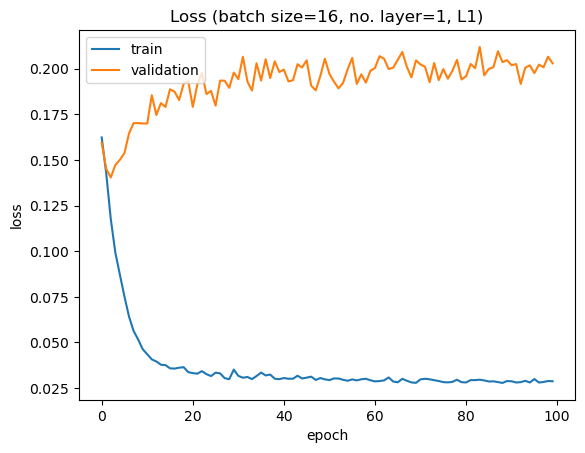

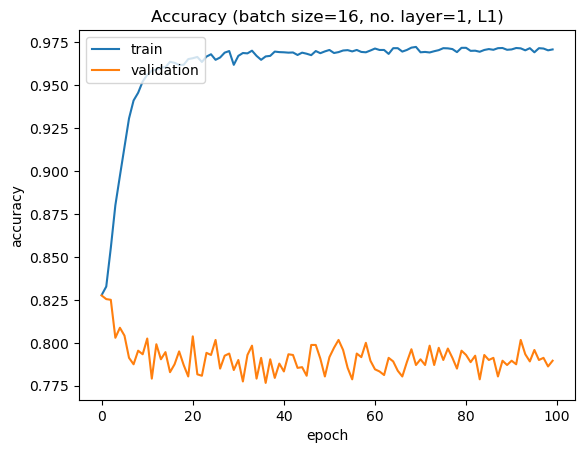

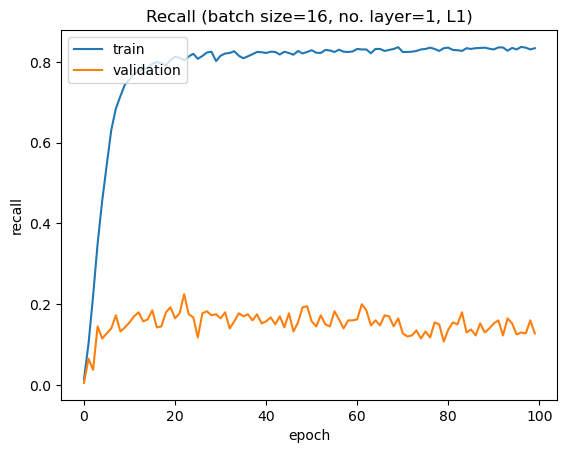

In [65]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [66]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.029
Training Accuracy: 0.971
Training Recall: 0.834


Validation Loss: 0.203
Validation Accuracy: 0.79
Validation Recall: 0.127


### batch size = 32, number of layer = 1

In [67]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.1651 - accuracy: 0.8274 - recall_13: 0.0113 - val_loss: 0.1623 - val_accuracy: 0.8213 - val_recall_13: 0.0150 - 1s/epoch - 4ms/step
Epoch 2/100
300/300 - 0s - loss: 0.1474 - accuracy: 0.8363 - recall_13: 0.0944 - val_loss: 0.1570 - val_accuracy: 0.8313 - val_recall_13: 0.0100 - 438ms/epoch - 1ms/step
Epoch 3/100
300/300 - 0s - loss: 0.1269 - accuracy: 0.8549 - recall_13: 0.2150 - val_loss: 0.1522 - val_accuracy: 0.8171 - val_recall_13: 0.0600 - 423ms/epoch - 1ms/step
Epoch 4/100
300/300 - 0s - loss: 0.1069 - accuracy: 0.8800 - recall_13: 0.3462 - val_loss: 0.1545 - val_accuracy: 0.8150 - val_recall_13: 0.0625 - 412ms/epoch - 1ms/step
Epoch 5/100
300/300 - 0s - loss: 0.0928 - accuracy: 0.8971 - recall_13: 0.4356 - val_loss: 0.1544 - val_accuracy: 0.8175 - val_recall_13: 0.0625 - 424ms/epoch - 1ms/step
Epoch 6/100
300/300 - 0s - loss: 0.0809 - accuracy: 0.9112 - recall_13: 0.5119 - val_loss: 0.1575 - val_accuracy: 0.8096 - val_recall_13: 0.0950 - 428ms/

Epoch 49/100
300/300 - 0s - loss: 0.0319 - accuracy: 0.9681 - recall_13: 0.8131 - val_loss: 0.2036 - val_accuracy: 0.7783 - val_recall_13: 0.1625 - 400ms/epoch - 1ms/step
Epoch 50/100
300/300 - 0s - loss: 0.0322 - accuracy: 0.9678 - recall_13: 0.8112 - val_loss: 0.1922 - val_accuracy: 0.7942 - val_recall_13: 0.1250 - 417ms/epoch - 1ms/step
Epoch 51/100
300/300 - 0s - loss: 0.0328 - accuracy: 0.9669 - recall_13: 0.8081 - val_loss: 0.1915 - val_accuracy: 0.7971 - val_recall_13: 0.1325 - 423ms/epoch - 1ms/step
Epoch 52/100
300/300 - 0s - loss: 0.0347 - accuracy: 0.9639 - recall_13: 0.8012 - val_loss: 0.2057 - val_accuracy: 0.7771 - val_recall_13: 0.1925 - 421ms/epoch - 1ms/step
Epoch 53/100
300/300 - 0s - loss: 0.0353 - accuracy: 0.9636 - recall_13: 0.7962 - val_loss: 0.2044 - val_accuracy: 0.7817 - val_recall_13: 0.1700 - 412ms/epoch - 1ms/step
Epoch 54/100
300/300 - 0s - loss: 0.0336 - accuracy: 0.9655 - recall_13: 0.8044 - val_loss: 0.1991 - val_accuracy: 0.7871 - val_recall_13: 0.1525

Epoch 97/100
300/300 - 0s - loss: 0.0345 - accuracy: 0.9643 - recall_13: 0.8000 - val_loss: 0.2051 - val_accuracy: 0.7862 - val_recall_13: 0.1575 - 424ms/epoch - 1ms/step
Epoch 98/100
300/300 - 0s - loss: 0.0340 - accuracy: 0.9648 - recall_13: 0.8050 - val_loss: 0.1945 - val_accuracy: 0.7983 - val_recall_13: 0.1400 - 407ms/epoch - 1ms/step
Epoch 99/100
300/300 - 0s - loss: 0.0313 - accuracy: 0.9685 - recall_13: 0.8156 - val_loss: 0.2044 - val_accuracy: 0.7846 - val_recall_13: 0.1550 - 425ms/epoch - 1ms/step
Epoch 100/100
300/300 - 0s - loss: 0.0314 - accuracy: 0.9685 - recall_13: 0.8150 - val_loss: 0.2092 - val_accuracy: 0.7796 - val_recall_13: 0.1650 - 410ms/epoch - 1ms/step


#### Predict

In [68]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

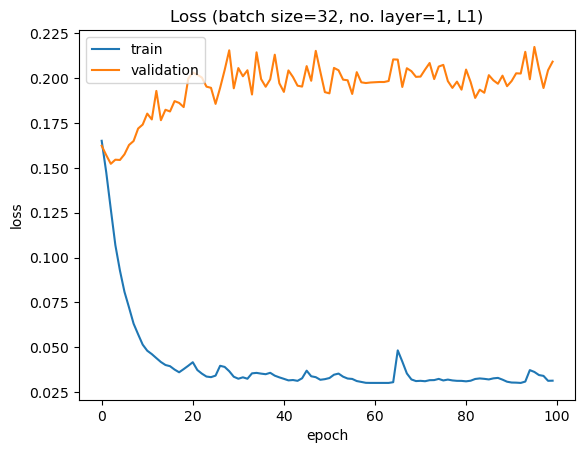

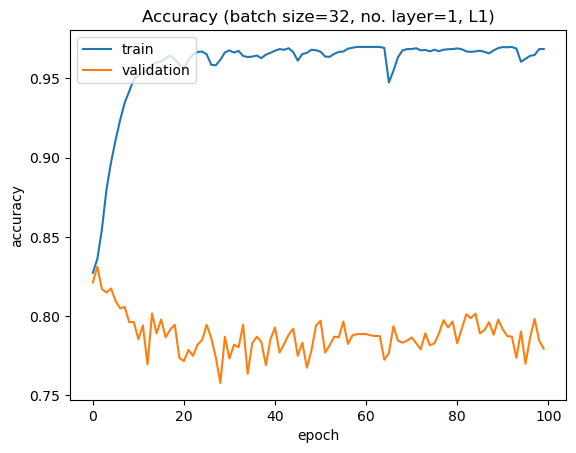

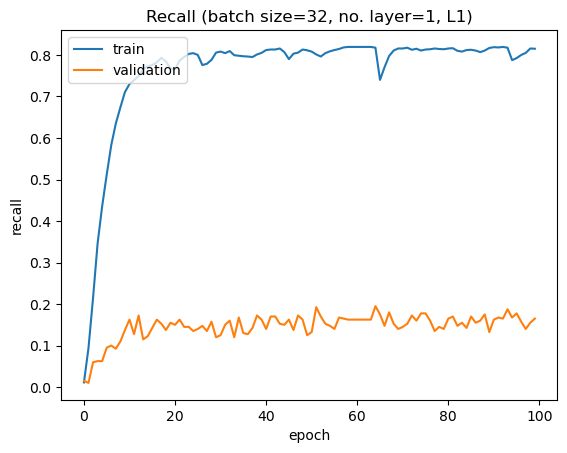

In [69]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [70]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.031
Training Accuracy: 0.969
Training Recall: 0.815


Validation Loss: 0.209
Validation Accuracy: 0.78
Validation Recall: 0.165


### batch size = 64, number of layer = 1

In [71]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.1713 - accuracy: 0.8271 - recall_14: 0.0056 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_14: 0.0000e+00 - 1s/epoch - 7ms/step
Epoch 2/100
150/150 - 0s - loss: 0.1663 - accuracy: 0.8333 - recall_14: 0.0000e+00 - val_loss: 0.1662 - val_accuracy: 0.8333 - val_recall_14: 0.0000e+00 - 241ms/epoch - 2ms/step
Epoch 3/100
150/150 - 0s - loss: 0.1635 - accuracy: 0.8327 - recall_14: 0.0069 - val_loss: 0.1649 - val_accuracy: 0.8296 - val_recall_14: 0.0025 - 232ms/epoch - 2ms/step
Epoch 4/100
150/150 - 0s - loss: 0.1539 - accuracy: 0.8317 - recall_14: 0.0569 - val_loss: 0.1566 - val_accuracy: 0.8288 - val_recall_14: 0.0175 - 269ms/epoch - 2ms/step
Epoch 5/100
150/150 - 0s - loss: 0.1333 - accuracy: 0.8461 - recall_14: 0.1587 - val_loss: 0.1536 - val_accuracy: 0.8192 - val_recall_14: 0.0750 - 258ms/epoch - 2ms/step
Epoch 6/100
150/150 - 0s - loss: 0.1104 - accuracy: 0.8748 - recall_14: 0.3056 - val_loss: 0.1500 - val_accuracy: 0.8196 - val_recall_14: 0.0

Epoch 49/100
150/150 - 0s - loss: 0.0309 - accuracy: 0.9670 - recall_14: 0.8263 - val_loss: 0.1990 - val_accuracy: 0.7833 - val_recall_14: 0.1700 - 255ms/epoch - 2ms/step
Epoch 50/100
150/150 - 0s - loss: 0.0263 - accuracy: 0.9732 - recall_14: 0.8487 - val_loss: 0.2085 - val_accuracy: 0.7704 - val_recall_14: 0.1925 - 228ms/epoch - 2ms/step
Epoch 51/100
150/150 - 0s - loss: 0.0241 - accuracy: 0.9756 - recall_14: 0.8594 - val_loss: 0.2055 - val_accuracy: 0.7733 - val_recall_14: 0.1900 - 239ms/epoch - 2ms/step
Epoch 52/100
150/150 - 0s - loss: 0.0232 - accuracy: 0.9769 - recall_14: 0.8637 - val_loss: 0.2113 - val_accuracy: 0.7692 - val_recall_14: 0.1925 - 265ms/epoch - 2ms/step
Epoch 53/100
150/150 - 0s - loss: 0.0225 - accuracy: 0.9776 - recall_14: 0.8656 - val_loss: 0.2037 - val_accuracy: 0.7771 - val_recall_14: 0.1850 - 273ms/epoch - 2ms/step
Epoch 54/100
150/150 - 0s - loss: 0.0224 - accuracy: 0.9776 - recall_14: 0.8656 - val_loss: 0.2037 - val_accuracy: 0.7783 - val_recall_14: 0.1850

Epoch 97/100
150/150 - 0s - loss: 0.0223 - accuracy: 0.9775 - recall_14: 0.8675 - val_loss: 0.2198 - val_accuracy: 0.7663 - val_recall_14: 0.1825 - 274ms/epoch - 2ms/step
Epoch 98/100
150/150 - 0s - loss: 0.0217 - accuracy: 0.9784 - recall_14: 0.8712 - val_loss: 0.2111 - val_accuracy: 0.7696 - val_recall_14: 0.1525 - 249ms/epoch - 2ms/step
Epoch 99/100
150/150 - 0s - loss: 0.0215 - accuracy: 0.9785 - recall_14: 0.8712 - val_loss: 0.2149 - val_accuracy: 0.7650 - val_recall_14: 0.1675 - 249ms/epoch - 2ms/step
Epoch 100/100
150/150 - 0s - loss: 0.0214 - accuracy: 0.9786 - recall_14: 0.8719 - val_loss: 0.2126 - val_accuracy: 0.7700 - val_recall_14: 0.1575 - 290ms/epoch - 2ms/step


#### Predict

In [72]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

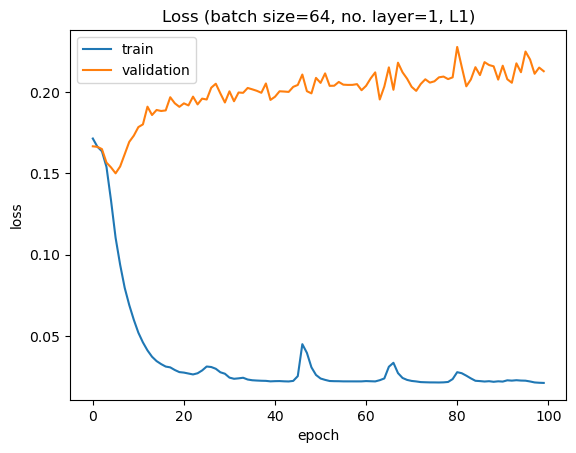

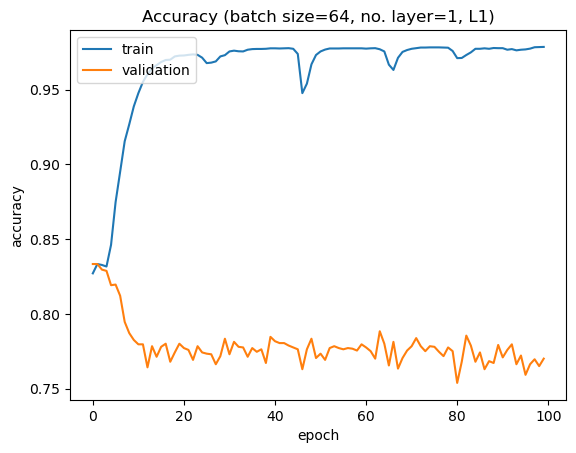

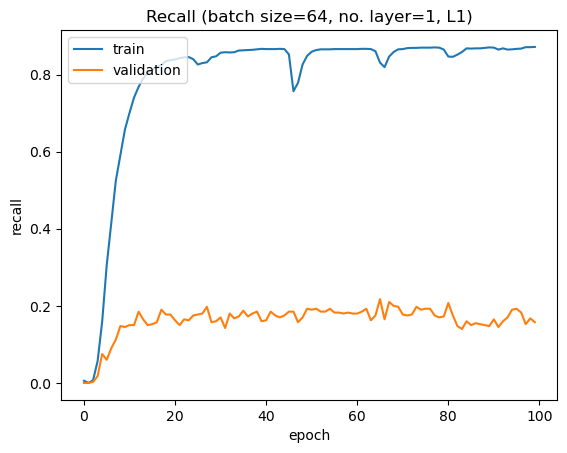

In [73]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [74]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.021
Training Accuracy: 0.979
Training Recall: 0.872


Validation Loss: 0.213
Validation Accuracy: 0.77
Validation Recall: 0.157


### batch size = 16, number of layer = 2

In [75]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1\\densenet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1\\densenet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [76]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1682 - accuracy: 0.8306 - recall_15: 0.0044 - val_loss: 0.1643 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1668 - accuracy: 0.8332 - recall_15: 0.0000e+00 - val_loss: 0.1642 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 789ms/epoch - 1ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1635 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 820ms/epoch - 1ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1629 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 809ms/epoch - 1ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1632 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 760ms/epoch - 1ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1646 - val_accuracy:

Epoch 47/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 776ms/epoch - 1ms/step
Epoch 48/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 795ms/epoch - 1ms/step
Epoch 49/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 828ms/epoch - 1ms/step
Epoch 50/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 812ms/epoch - 1ms/step
Epoch 51/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 828ms/epoch - 1ms/step
Epoch 52/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - 

Epoch 93/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 841ms/epoch - 1ms/step
Epoch 94/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 822ms/epoch - 1ms/step
Epoch 95/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 837ms/epoch - 1ms/step
Epoch 96/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 823ms/epoch - 1ms/step
Epoch 97/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 836ms/epoch - 1ms/step
Epoch 98/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1667 - 

#### Predict

In [77]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

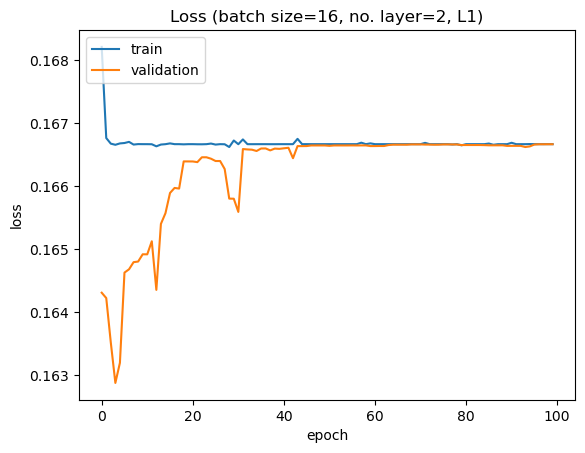

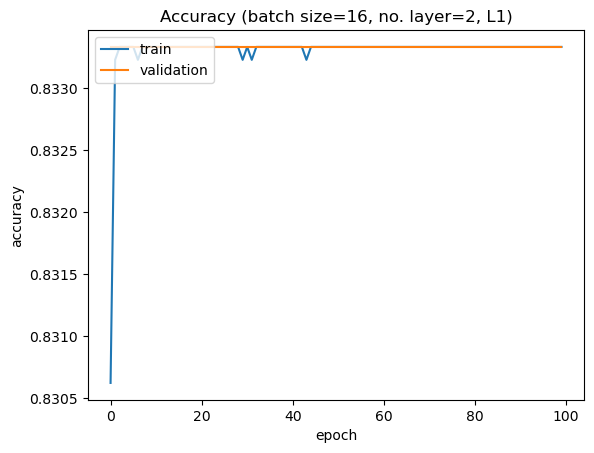

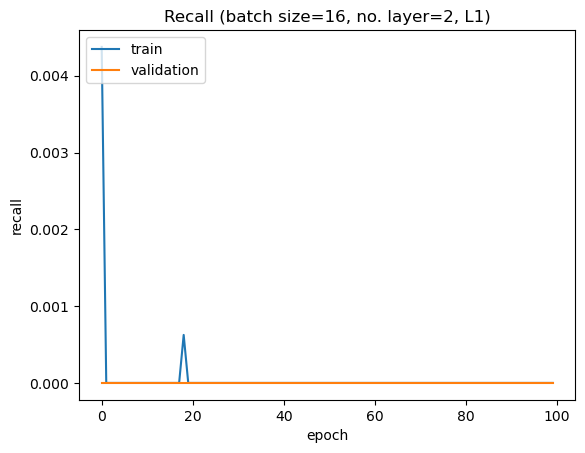

In [78]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [79]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [80]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.1691 - accuracy: 0.8259 - recall_16: 0.0125 - val_loss: 0.1608 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 1s/epoch - 4ms/step
Epoch 2/100
300/300 - 0s - loss: 0.1672 - accuracy: 0.8325 - recall_16: 0.0000e+00 - val_loss: 0.1611 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 438ms/epoch - 1ms/step
Epoch 3/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8332 - recall_16: 0.0000e+00 - val_loss: 0.1621 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 436ms/epoch - 1ms/step
Epoch 4/100
300/300 - 0s - loss: 0.1667 - accuracy: 0.8332 - recall_16: 0.0000e+00 - val_loss: 0.1625 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 441ms/epoch - 1ms/step
Epoch 5/100
300/300 - 0s - loss: 0.1666 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1636 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 461ms/epoch - 2ms/step
Epoch 6/100
300/300 - 0s - loss: 0.1666 - accuracy: 0.8328 - recall_16: 0.0031 - val_loss: 0.1641 - val_accuracy: 0.8

Epoch 47/100
300/300 - 0s - loss: 0.1389 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 432ms/epoch - 1ms/step
Epoch 48/100
300/300 - 0s - loss: 0.1391 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 463ms/epoch - 2ms/step
Epoch 49/100
300/300 - 0s - loss: 0.1389 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 426ms/epoch - 1ms/step
Epoch 50/100
300/300 - 0s - loss: 0.1389 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1387 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 454ms/epoch - 2ms/step
Epoch 51/100
300/300 - 0s - loss: 0.1389 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1383 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 416ms/epoch - 1ms/step
Epoch 52/100
300/300 - 0s - loss: 0.1388 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1389 - 

Epoch 93/100
300/300 - 0s - loss: 0.1389 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 424ms/epoch - 1ms/step
Epoch 94/100
300/300 - 0s - loss: 0.1389 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 437ms/epoch - 1ms/step
Epoch 95/100
300/300 - 0s - loss: 0.1389 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 420ms/epoch - 1ms/step
Epoch 96/100
300/300 - 0s - loss: 0.1389 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 452ms/epoch - 2ms/step
Epoch 97/100
300/300 - 0s - loss: 0.1389 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 439ms/epoch - 1ms/step
Epoch 98/100
300/300 - 0s - loss: 0.1389 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1389 - 

#### Predict

In [81]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

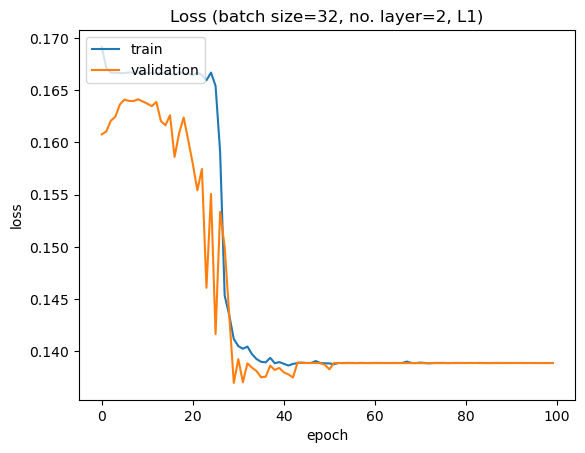

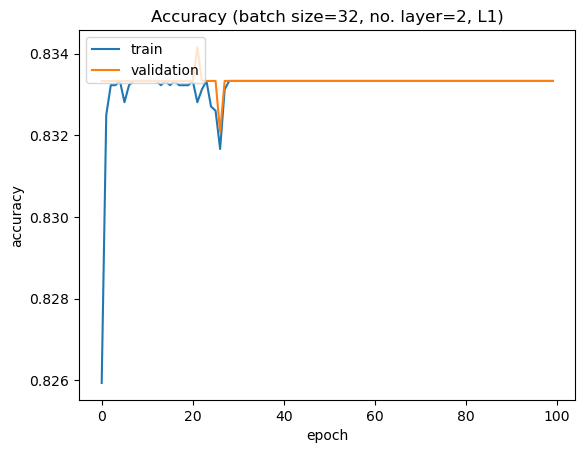

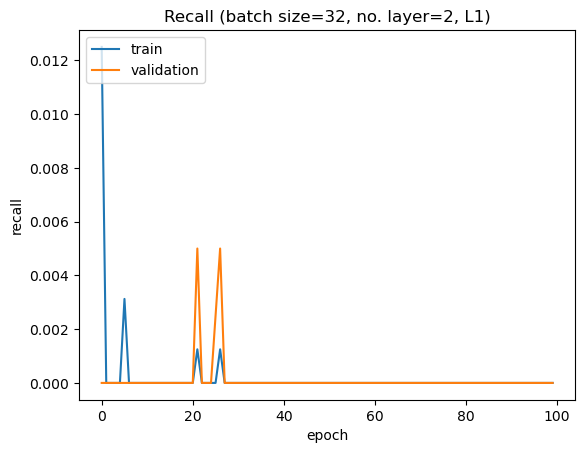

In [82]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [83]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.139
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.139
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [84]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.1826 - accuracy: 0.8076 - recall_17: 0.0562 - val_loss: 0.1574 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 7ms/step
Epoch 2/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8326 - recall_17: 0.0012 - val_loss: 0.1575 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 263ms/epoch - 2ms/step
Epoch 3/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8310 - recall_17: 0.0037 - val_loss: 0.1564 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 240ms/epoch - 2ms/step
Epoch 4/100
150/150 - 0s - loss: 0.1669 - accuracy: 0.8318 - recall_17: 0.0012 - val_loss: 0.1571 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 262ms/epoch - 2ms/step
Epoch 5/100
150/150 - 0s - loss: 0.1669 - accuracy: 0.8326 - recall_17: 0.0000e+00 - val_loss: 0.1592 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 256ms/epoch - 2ms/step
Epoch 6/100
150/150 - 0s - loss: 0.1667 - accuracy: 0.8331 - recall_17: 0.0000e+00 - val_loss: 0.1592 - val_accuracy: 0.8333 - va

Epoch 48/100
150/150 - 0s - loss: 0.1366 - accuracy: 0.8332 - recall_17: 0.0000e+00 - val_loss: 0.1359 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 266ms/epoch - 2ms/step
Epoch 49/100
150/150 - 0s - loss: 0.1362 - accuracy: 0.8333 - recall_17: 0.0081 - val_loss: 0.1354 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 261ms/epoch - 2ms/step
Epoch 50/100
150/150 - 0s - loss: 0.1363 - accuracy: 0.8331 - recall_17: 0.0025 - val_loss: 0.1365 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 293ms/epoch - 2ms/step
Epoch 51/100
150/150 - 0s - loss: 0.1366 - accuracy: 0.8330 - recall_17: 0.0025 - val_loss: 0.1357 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 279ms/epoch - 2ms/step
Epoch 52/100
150/150 - 0s - loss: 0.1363 - accuracy: 0.8335 - recall_17: 0.0025 - val_loss: 0.1357 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 261ms/epoch - 2ms/step
Epoch 53/100
150/150 - 0s - loss: 0.1364 - accuracy: 0.8331 - recall_17: 0.0031 - val_loss: 0.1358 - val_accuracy: 0.8333

Epoch 95/100
150/150 - 0s - loss: 0.1348 - accuracy: 0.8339 - recall_17: 0.0125 - val_loss: 0.1362 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 269ms/epoch - 2ms/step
Epoch 96/100
150/150 - 0s - loss: 0.1351 - accuracy: 0.8334 - recall_17: 0.0100 - val_loss: 0.1354 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 258ms/epoch - 2ms/step
Epoch 97/100
150/150 - 0s - loss: 0.1348 - accuracy: 0.8331 - recall_17: 0.0088 - val_loss: 0.1360 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 288ms/epoch - 2ms/step
Epoch 98/100
150/150 - 0s - loss: 0.1347 - accuracy: 0.8332 - recall_17: 0.0094 - val_loss: 0.1351 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 252ms/epoch - 2ms/step
Epoch 99/100
150/150 - 0s - loss: 0.1350 - accuracy: 0.8332 - recall_17: 0.0050 - val_loss: 0.1355 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 270ms/epoch - 2ms/step
Epoch 100/100
150/150 - 0s - loss: 0.1350 - accuracy: 0.8328 - recall_17: 0.0031 - val_loss: 0.1360 - val_accuracy: 0.8333 - 

#### Predict

In [85]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

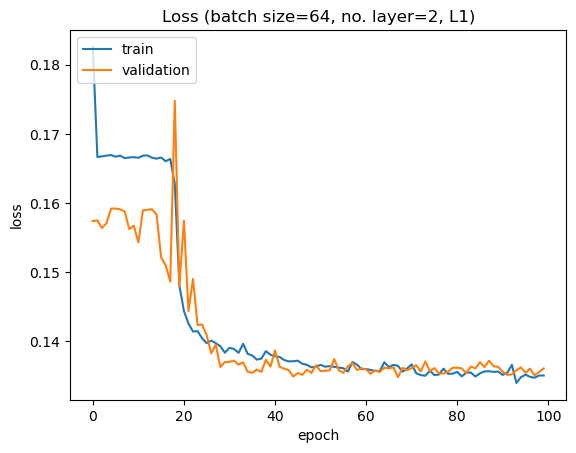

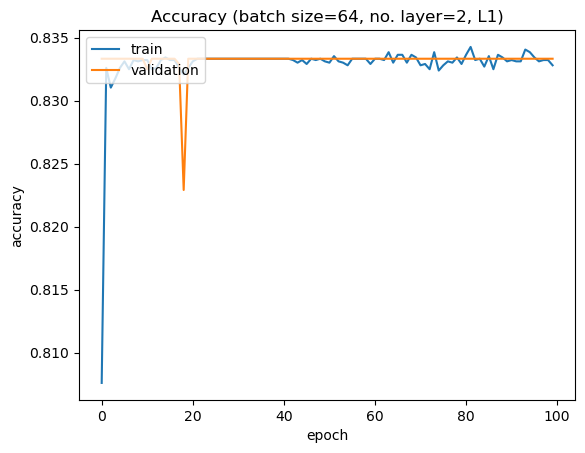

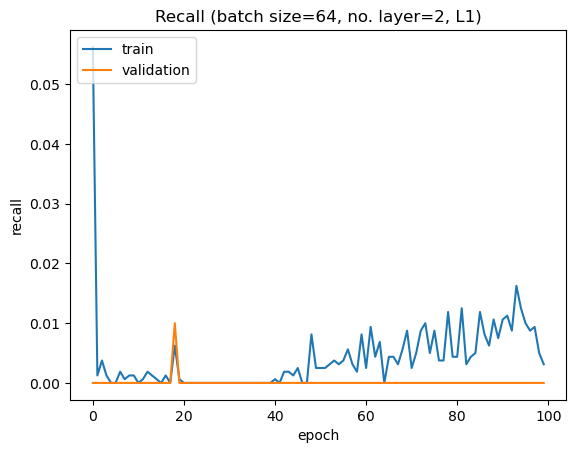

In [86]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [87]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.135
Training Accuracy: 0.833
Training Recall: 0.003


Validation Loss: 0.136
Validation Accuracy: 0.833
Validation Recall: 0.0


# L2 Distance

## vgg

In [88]:
left_train = np.load('vgg_train_left.npy')
right_train = np.load('vgg_train_right.npy')
left_test = np.load('vgg_test_left.npy')
right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [89]:
path = ".\COMP90086_2023_TLLdataset\\train\\left"
dir_list = os.listdir(path)
train_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\train\\right"
dir_list = os.listdir(path)
train_right_images_list = dir_list

left_array_dict = {}
for i in range(len(train_left_images_list)):
    left_array_dict[train_left_images_list[i][:3]] = left_train[i]
    
right_array_dict = {}
for i in range(len(train_right_images_list)):
    right_array_dict[train_right_images_list[i][:3]] = right_train[i]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [90]:
input_shape = (512,)
# input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model

# Reference:
# https://keras.io/examples/vision/siamese_contrastive/?fbclid=IwAR0d0p7eAw2zZDUiyaPhkt-ZQuDQ32U7rRIHxv4ErsSn9yVkBFbfzBC42fQ
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_network(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    shared_network = create_shared_network(input_shape)
    left_features = shared_network(left_input)
    right_features = shared_network(right_input)

#     distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([left_features, right_features])
#     normal_layer = tf.keras.layers.BatchNormalization()(distance)
#     similarity_score = Dense(1, activation='sigmoid')(distance)
    
    distance = Lambda(euclidean_distance)([left_features, right_features])
    normal_layer = tf.keras.layers.BatchNormalization()(distance)
    similarity_score = layers.Dense(1, activation="sigmoid")(normal_layer)

    siamese_net = Model(inputs=[left_input, right_input], outputs=1-similarity_score)
    return siamese_net
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2\\vgg_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2\\vgg_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [91]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1903 - accuracy: 0.7291 - recall_18: 0.4050 - val_loss: 0.1408 - val_accuracy: 0.8358 - val_recall_18: 0.1400 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1252 - accuracy: 0.8440 - recall_18: 0.1525 - val_loss: 0.1226 - val_accuracy: 0.8375 - val_recall_18: 0.0875 - 759ms/epoch - 1ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1075 - accuracy: 0.8539 - recall_18: 0.2219 - val_loss: 0.1224 - val_accuracy: 0.8358 - val_recall_18: 0.1450 - 807ms/epoch - 1ms/step
Epoch 4/100
600/600 - 1s - loss: 0.0967 - accuracy: 0.8709 - recall_18: 0.3638 - val_loss: 0.1276 - val_accuracy: 0.8321 - val_recall_18: 0.2200 - 770ms/epoch - 1ms/step
Epoch 5/100
600/600 - 1s - loss: 0.0845 - accuracy: 0.8908 - recall_18: 0.4950 - val_loss: 0.1323 - val_accuracy: 0.8258 - val_recall_18: 0.2675 - 789ms/epoch - 1ms/step
Epoch 6/100
600/600 - 1s - loss: 0.0753 - accuracy: 0.9025 - recall_18: 0.5744 - val_loss: 0.1382 - val_accuracy: 0.8154 - val_recall_18: 0.3050 - 796ms/

Epoch 49/100
600/600 - 1s - loss: 0.0220 - accuracy: 0.9728 - recall_18: 0.9112 - val_loss: 0.1735 - val_accuracy: 0.8017 - val_recall_18: 0.2700 - 793ms/epoch - 1ms/step
Epoch 50/100
600/600 - 1s - loss: 0.0236 - accuracy: 0.9711 - recall_18: 0.8981 - val_loss: 0.1729 - val_accuracy: 0.8046 - val_recall_18: 0.2925 - 756ms/epoch - 1ms/step
Epoch 51/100
600/600 - 1s - loss: 0.0230 - accuracy: 0.9707 - recall_18: 0.9081 - val_loss: 0.1741 - val_accuracy: 0.7992 - val_recall_18: 0.2700 - 778ms/epoch - 1ms/step
Epoch 52/100
600/600 - 1s - loss: 0.0240 - accuracy: 0.9715 - recall_18: 0.9025 - val_loss: 0.1831 - val_accuracy: 0.7904 - val_recall_18: 0.3025 - 791ms/epoch - 1ms/step
Epoch 53/100
600/600 - 1s - loss: 0.0244 - accuracy: 0.9702 - recall_18: 0.9056 - val_loss: 0.1829 - val_accuracy: 0.7950 - val_recall_18: 0.3200 - 777ms/epoch - 1ms/step
Epoch 54/100
600/600 - 1s - loss: 0.0212 - accuracy: 0.9739 - recall_18: 0.9094 - val_loss: 0.1819 - val_accuracy: 0.7929 - val_recall_18: 0.3050

Epoch 97/100
600/600 - 1s - loss: 0.0176 - accuracy: 0.9793 - recall_18: 0.9319 - val_loss: 0.1901 - val_accuracy: 0.7833 - val_recall_18: 0.3025 - 863ms/epoch - 1ms/step
Epoch 98/100
600/600 - 1s - loss: 0.0195 - accuracy: 0.9754 - recall_18: 0.9156 - val_loss: 0.1888 - val_accuracy: 0.7896 - val_recall_18: 0.3025 - 875ms/epoch - 1ms/step
Epoch 99/100
600/600 - 1s - loss: 0.0180 - accuracy: 0.9789 - recall_18: 0.9287 - val_loss: 0.1872 - val_accuracy: 0.7937 - val_recall_18: 0.3000 - 822ms/epoch - 1ms/step
Epoch 100/100
600/600 - 1s - loss: 0.0186 - accuracy: 0.9768 - recall_18: 0.9225 - val_loss: 0.1878 - val_accuracy: 0.7896 - val_recall_18: 0.3000 - 813ms/epoch - 1ms/step


#### Predict

In [92]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

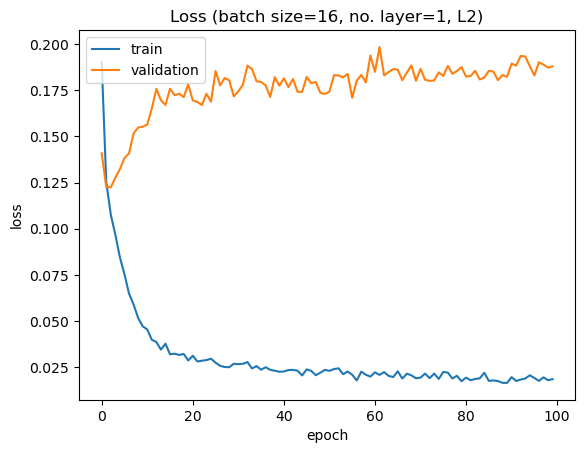

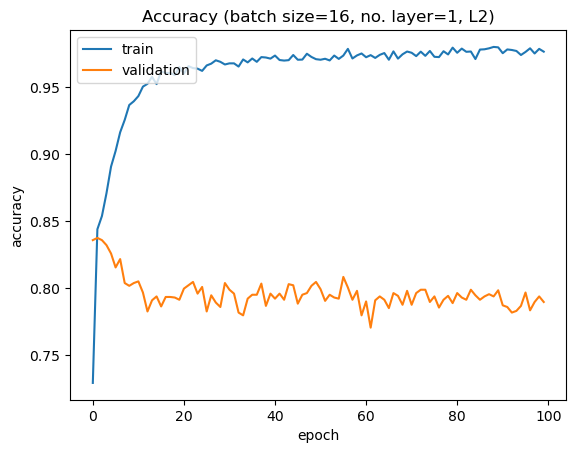

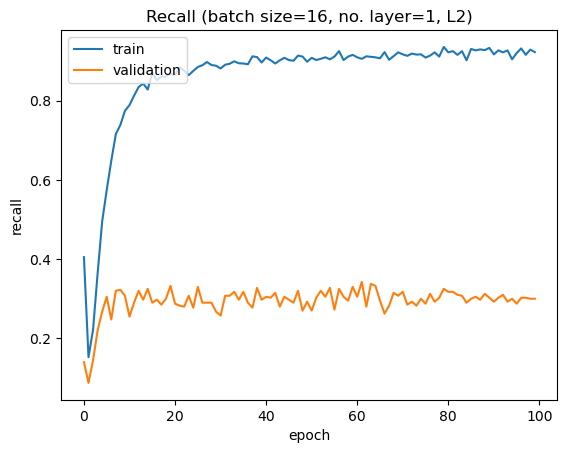

In [93]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [94]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.019
Training Accuracy: 0.977
Training Recall: 0.923


Validation Loss: 0.188
Validation Accuracy: 0.79
Validation Recall: 0.3


### batch size = 32, number of layer = 1

In [95]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 1s - loss: 0.2443 - accuracy: 0.6354 - recall_19: 0.2044 - val_loss: 0.1988 - val_accuracy: 0.7654 - val_recall_19: 0.0800 - 1s/epoch - 5ms/step
Epoch 2/100
300/300 - 0s - loss: 0.1854 - accuracy: 0.7802 - recall_19: 0.0794 - val_loss: 0.1678 - val_accuracy: 0.8054 - val_recall_19: 0.0375 - 459ms/epoch - 2ms/step
Epoch 3/100
300/300 - 0s - loss: 0.1580 - accuracy: 0.8199 - recall_19: 0.0150 - val_loss: 0.1544 - val_accuracy: 0.8221 - val_recall_19: 0.0075 - 452ms/epoch - 2ms/step
Epoch 4/100
300/300 - 0s - loss: 0.1433 - accuracy: 0.8332 - recall_19: 0.0012 - val_loss: 0.1445 - val_accuracy: 0.8329 - val_recall_19: 0.0000e+00 - 460ms/epoch - 2ms/step
Epoch 5/100
300/300 - 0s - loss: 0.1389 - accuracy: 0.8333 - recall_19: 0.0000e+00 - val_loss: 0.1439 - val_accuracy: 0.8333 - val_recall_19: 0.0000e+00 - 496ms/epoch - 2ms/step
Epoch 6/100
300/300 - 0s - loss: 0.1373 - accuracy: 0.8333 - recall_19: 0.0000e+00 - val_loss: 0.1441 - val_accuracy: 0.8333 - val_recall_19:

Epoch 49/100
300/300 - 1s - loss: 0.1139 - accuracy: 0.8576 - recall_19: 0.2581 - val_loss: 0.2108 - val_accuracy: 0.7396 - val_recall_19: 0.0525 - 573ms/epoch - 2ms/step
Epoch 50/100
300/300 - 1s - loss: 0.1138 - accuracy: 0.8577 - recall_19: 0.2694 - val_loss: 0.2174 - val_accuracy: 0.7296 - val_recall_19: 0.0575 - 538ms/epoch - 2ms/step
Epoch 51/100
300/300 - 1s - loss: 0.1135 - accuracy: 0.8582 - recall_19: 0.2775 - val_loss: 0.2174 - val_accuracy: 0.7287 - val_recall_19: 0.0650 - 521ms/epoch - 2ms/step
Epoch 52/100
300/300 - 1s - loss: 0.1141 - accuracy: 0.8570 - recall_19: 0.2769 - val_loss: 0.2114 - val_accuracy: 0.7337 - val_recall_19: 0.0500 - 547ms/epoch - 2ms/step
Epoch 53/100
300/300 - 1s - loss: 0.1124 - accuracy: 0.8606 - recall_19: 0.2781 - val_loss: 0.2246 - val_accuracy: 0.7204 - val_recall_19: 0.0675 - 556ms/epoch - 2ms/step
Epoch 54/100
300/300 - 1s - loss: 0.1113 - accuracy: 0.8640 - recall_19: 0.3113 - val_loss: 0.2235 - val_accuracy: 0.7242 - val_recall_19: 0.0600

Epoch 97/100
300/300 - 1s - loss: 0.0996 - accuracy: 0.8833 - recall_19: 0.4431 - val_loss: 0.2685 - val_accuracy: 0.6925 - val_recall_19: 0.0825 - 504ms/epoch - 2ms/step
Epoch 98/100
300/300 - 0s - loss: 0.0998 - accuracy: 0.8822 - recall_19: 0.4306 - val_loss: 0.2531 - val_accuracy: 0.7054 - val_recall_19: 0.0675 - 450ms/epoch - 1ms/step
Epoch 99/100
300/300 - 0s - loss: 0.0991 - accuracy: 0.8836 - recall_19: 0.4525 - val_loss: 0.2621 - val_accuracy: 0.6988 - val_recall_19: 0.0825 - 460ms/epoch - 2ms/step
Epoch 100/100
300/300 - 0s - loss: 0.0992 - accuracy: 0.8834 - recall_19: 0.4431 - val_loss: 0.2656 - val_accuracy: 0.6913 - val_recall_19: 0.0775 - 438ms/epoch - 1ms/step


#### Predict

In [96]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

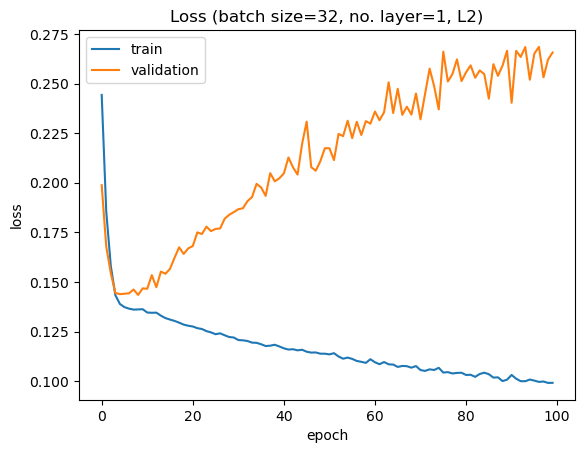

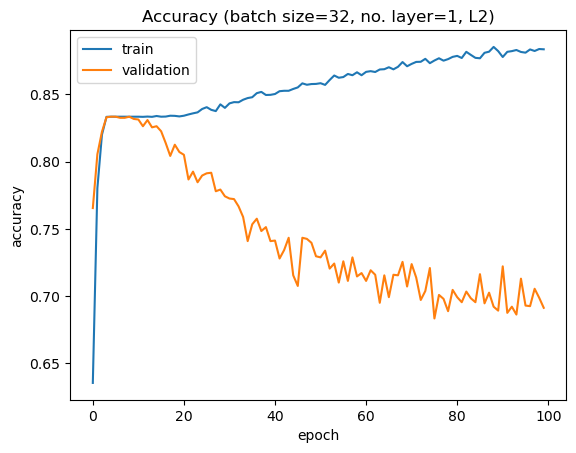

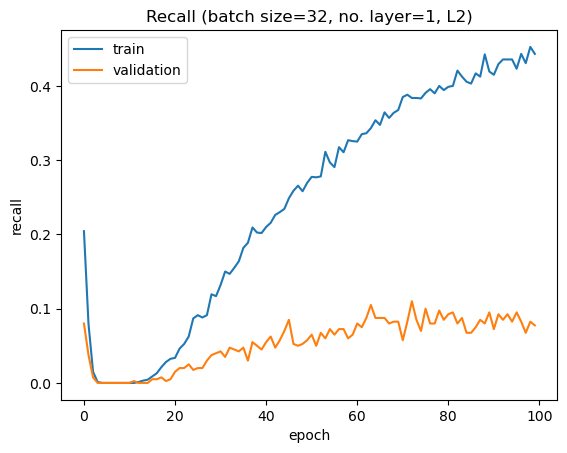

In [97]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [98]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.099
Training Accuracy: 0.883
Training Recall: 0.443


Validation Loss: 0.266
Validation Accuracy: 0.691
Validation Recall: 0.078


### batch size = 64, number of layer = 1

In [99]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.2308 - accuracy: 0.6041 - recall_20: 0.6625 - val_loss: 0.1388 - val_accuracy: 0.8308 - val_recall_20: 0.1725 - 1s/epoch - 8ms/step
Epoch 2/100
150/150 - 0s - loss: 0.1809 - accuracy: 0.7540 - recall_20: 0.6581 - val_loss: 0.1543 - val_accuracy: 0.8087 - val_recall_20: 0.3450 - 243ms/epoch - 2ms/step
Epoch 3/100
150/150 - 0s - loss: 0.1457 - accuracy: 0.8343 - recall_20: 0.6075 - val_loss: 0.1539 - val_accuracy: 0.7975 - val_recall_20: 0.3525 - 244ms/epoch - 2ms/step
Epoch 4/100
150/150 - 0s - loss: 0.1171 - accuracy: 0.8815 - recall_20: 0.6156 - val_loss: 0.1510 - val_accuracy: 0.7967 - val_recall_20: 0.3600 - 255ms/epoch - 2ms/step
Epoch 5/100
150/150 - 0s - loss: 0.0948 - accuracy: 0.9055 - recall_20: 0.6675 - val_loss: 0.1500 - val_accuracy: 0.7950 - val_recall_20: 0.3625 - 248ms/epoch - 2ms/step
Epoch 6/100
150/150 - 0s - loss: 0.0766 - accuracy: 0.9261 - recall_20: 0.7156 - val_loss: 0.1377 - val_accuracy: 0.8150 - val_recall_20: 0.2325 - 253ms/

Epoch 49/100
150/150 - 0s - loss: 0.0022 - accuracy: 0.9981 - recall_20: 0.9925 - val_loss: 0.1921 - val_accuracy: 0.7817 - val_recall_20: 0.3125 - 302ms/epoch - 2ms/step
Epoch 50/100
150/150 - 0s - loss: 0.0038 - accuracy: 0.9962 - recall_20: 0.9912 - val_loss: 0.1973 - val_accuracy: 0.7733 - val_recall_20: 0.3025 - 306ms/epoch - 2ms/step
Epoch 51/100
150/150 - 0s - loss: 0.0041 - accuracy: 0.9955 - recall_20: 0.9856 - val_loss: 0.1854 - val_accuracy: 0.7879 - val_recall_20: 0.2525 - 307ms/epoch - 2ms/step
Epoch 52/100
150/150 - 0s - loss: 0.0035 - accuracy: 0.9967 - recall_20: 0.9887 - val_loss: 0.1834 - val_accuracy: 0.7904 - val_recall_20: 0.2550 - 299ms/epoch - 2ms/step
Epoch 53/100
150/150 - 0s - loss: 0.0043 - accuracy: 0.9956 - recall_20: 0.9887 - val_loss: 0.1964 - val_accuracy: 0.7758 - val_recall_20: 0.3025 - 279ms/epoch - 2ms/step
Epoch 54/100
150/150 - 0s - loss: 0.0041 - accuracy: 0.9955 - recall_20: 0.9825 - val_loss: 0.1826 - val_accuracy: 0.7871 - val_recall_20: 0.2350

Epoch 97/100
150/150 - 0s - loss: 0.0039 - accuracy: 0.9953 - recall_20: 0.9869 - val_loss: 0.1938 - val_accuracy: 0.7842 - val_recall_20: 0.2800 - 266ms/epoch - 2ms/step
Epoch 98/100
150/150 - 0s - loss: 0.0046 - accuracy: 0.9936 - recall_20: 0.9812 - val_loss: 0.1872 - val_accuracy: 0.7933 - val_recall_20: 0.2950 - 246ms/epoch - 2ms/step
Epoch 99/100
150/150 - 0s - loss: 0.0027 - accuracy: 0.9973 - recall_20: 0.9931 - val_loss: 0.1966 - val_accuracy: 0.7825 - val_recall_20: 0.3075 - 254ms/epoch - 2ms/step
Epoch 100/100
150/150 - 0s - loss: 0.0022 - accuracy: 0.9979 - recall_20: 0.9931 - val_loss: 0.1902 - val_accuracy: 0.7921 - val_recall_20: 0.2525 - 227ms/epoch - 2ms/step


#### Predict

In [100]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

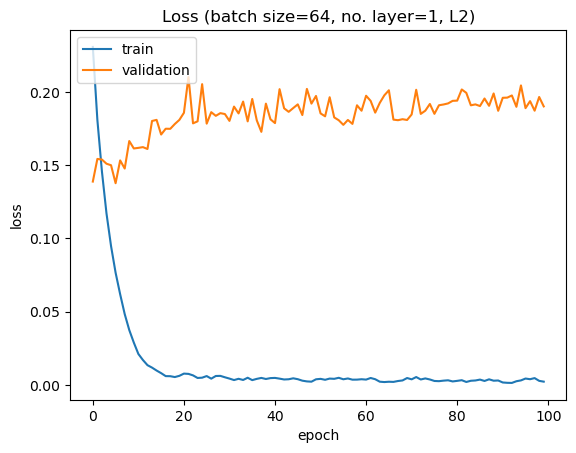

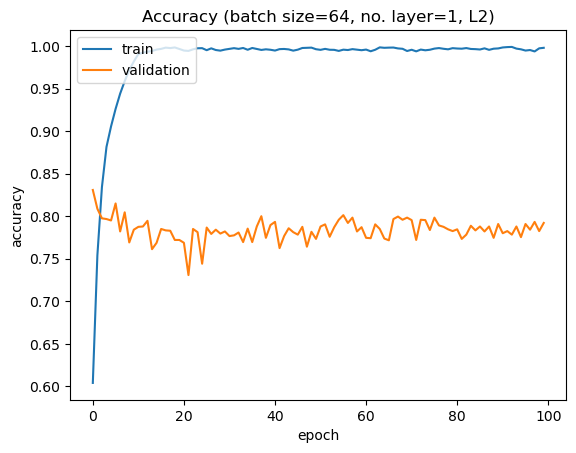

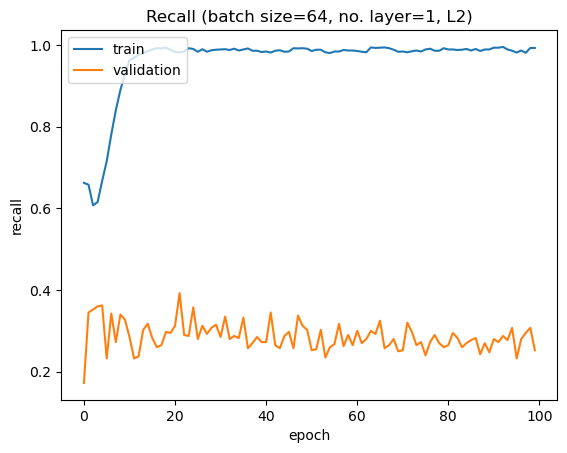

In [101]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [102]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.002
Training Accuracy: 0.998
Training Recall: 0.993


Validation Loss: 0.19
Validation Accuracy: 0.792
Validation Recall: 0.252


### batch size = 16, number of layer = 2

In [103]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),
        
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model

def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2\\vgg_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2\\vgg_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [104]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2272 - accuracy: 0.6704 - recall_21: 0.2294 - val_loss: 0.1441 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1489 - accuracy: 0.8296 - recall_21: 0.0069 - val_loss: 0.1415 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 839ms/epoch - 1ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1402 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1399 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 851ms/epoch - 1ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1391 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1393 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 885ms/epoch - 1ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1390 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 836ms/epoch - 1ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8

Epoch 47/100
600/600 - 1s - loss: 0.1321 - accuracy: 0.8332 - recall_21: 0.0000e+00 - val_loss: 0.1356 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 814ms/epoch - 1ms/step
Epoch 48/100
600/600 - 1s - loss: 0.1322 - accuracy: 0.8331 - recall_21: 0.0000e+00 - val_loss: 0.1312 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 835ms/epoch - 1ms/step
Epoch 49/100
600/600 - 1s - loss: 0.1315 - accuracy: 0.8334 - recall_21: 6.2500e-04 - val_loss: 0.1322 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 789ms/epoch - 1ms/step
Epoch 50/100
600/600 - 1s - loss: 0.1312 - accuracy: 0.8333 - recall_21: 6.2500e-04 - val_loss: 0.1318 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 815ms/epoch - 1ms/step
Epoch 51/100
600/600 - 1s - loss: 0.1307 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1323 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 840ms/epoch - 1ms/step
Epoch 52/100
600/600 - 1s - loss: 0.1304 - accuracy: 0.8333 - recall_21: 0.0012 - val_loss: 0.1338 - val_

Epoch 95/100
600/600 - 1s - loss: 0.1233 - accuracy: 0.8331 - recall_21: 0.0475 - val_loss: 0.1367 - val_accuracy: 0.8150 - val_recall_21: 0.1075 - 891ms/epoch - 1ms/step
Epoch 96/100
600/600 - 1s - loss: 0.1225 - accuracy: 0.8340 - recall_21: 0.0694 - val_loss: 0.1356 - val_accuracy: 0.8154 - val_recall_21: 0.0925 - 932ms/epoch - 2ms/step
Epoch 97/100
600/600 - 1s - loss: 0.1235 - accuracy: 0.8322 - recall_21: 0.0500 - val_loss: 0.1385 - val_accuracy: 0.8112 - val_recall_21: 0.1100 - 820ms/epoch - 1ms/step
Epoch 98/100
600/600 - 1s - loss: 0.1220 - accuracy: 0.8325 - recall_21: 0.0700 - val_loss: 0.1370 - val_accuracy: 0.8138 - val_recall_21: 0.1175 - 888ms/epoch - 1ms/step
Epoch 99/100
600/600 - 1s - loss: 0.1223 - accuracy: 0.8345 - recall_21: 0.0637 - val_loss: 0.1376 - val_accuracy: 0.8117 - val_recall_21: 0.1175 - 927ms/epoch - 2ms/step
Epoch 100/100
600/600 - 1s - loss: 0.1230 - accuracy: 0.8348 - recall_21: 0.0587 - val_loss: 0.1375 - val_accuracy: 0.8121 - val_recall_21: 0.097

#### Predict

In [105]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

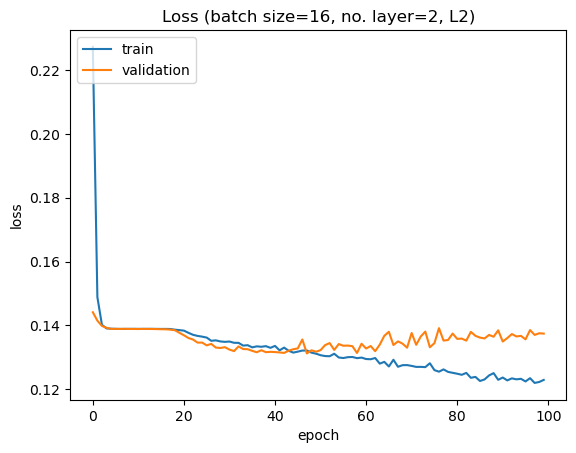

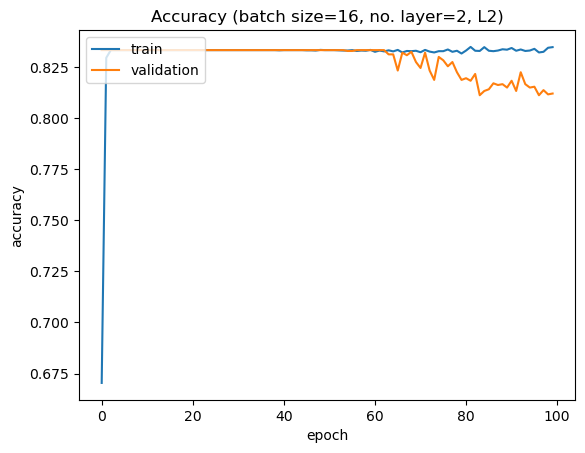

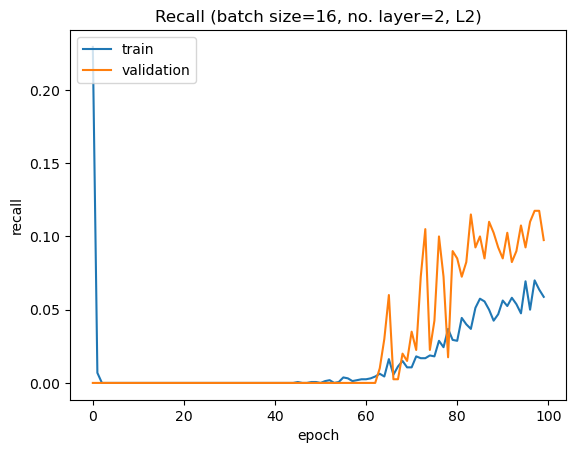

In [106]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [107]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.123
Training Accuracy: 0.835
Training Recall: 0.059


Validation Loss: 0.137
Validation Accuracy: 0.812
Validation Recall: 0.097


### batch size = 32, number of layer = 2

In [108]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 2s - loss: 0.2395 - accuracy: 0.6151 - recall_22: 0.3106 - val_loss: 0.1406 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 2s/epoch - 7ms/step
Epoch 2/100
300/300 - 1s - loss: 0.1842 - accuracy: 0.7775 - recall_22: 0.0725 - val_loss: 0.1398 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 538ms/epoch - 2ms/step
Epoch 3/100
300/300 - 1s - loss: 0.1574 - accuracy: 0.8305 - recall_22: 0.0025 - val_loss: 0.1395 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 563ms/epoch - 2ms/step
Epoch 4/100
300/300 - 1s - loss: 0.1446 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1397 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 579ms/epoch - 2ms/step
Epoch 5/100
300/300 - 1s - loss: 0.1404 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1396 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 545ms/epoch - 2ms/step
Epoch 6/100
300/300 - 1s - loss: 0.1393 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1393 - val_accuracy: 0.8333 

Epoch 47/100
300/300 - 1s - loss: 0.1349 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1348 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 550ms/epoch - 2ms/step
Epoch 48/100
300/300 - 1s - loss: 0.1348 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1346 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 528ms/epoch - 2ms/step
Epoch 49/100
300/300 - 1s - loss: 0.1348 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1350 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 504ms/epoch - 2ms/step
Epoch 50/100
300/300 - 1s - loss: 0.1351 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1348 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 513ms/epoch - 2ms/step
Epoch 51/100
300/300 - 1s - loss: 0.1345 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1346 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 557ms/epoch - 2ms/step
Epoch 52/100
300/300 - 1s - loss: 0.1346 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1344 - 

Epoch 93/100
300/300 - 1s - loss: 0.1304 - accuracy: 0.8335 - recall_22: 0.0025 - val_loss: 0.1362 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 612ms/epoch - 2ms/step
Epoch 94/100
300/300 - 1s - loss: 0.1307 - accuracy: 0.8330 - recall_22: 0.0019 - val_loss: 0.1373 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 606ms/epoch - 2ms/step
Epoch 95/100
300/300 - 1s - loss: 0.1301 - accuracy: 0.8330 - recall_22: 0.0012 - val_loss: 0.1382 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 639ms/epoch - 2ms/step
Epoch 96/100
300/300 - 1s - loss: 0.1309 - accuracy: 0.8327 - recall_22: 0.0012 - val_loss: 0.1346 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 604ms/epoch - 2ms/step
Epoch 97/100
300/300 - 1s - loss: 0.1302 - accuracy: 0.8329 - recall_22: 0.0025 - val_loss: 0.1356 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 554ms/epoch - 2ms/step
Epoch 98/100
300/300 - 1s - loss: 0.1302 - accuracy: 0.8333 - recall_22: 0.0031 - val_loss: 0.1352 - val_accuracy: 0.8333 - v

#### Predict

In [109]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

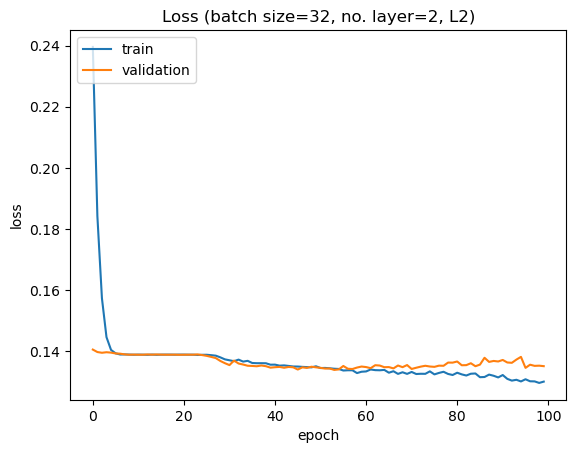

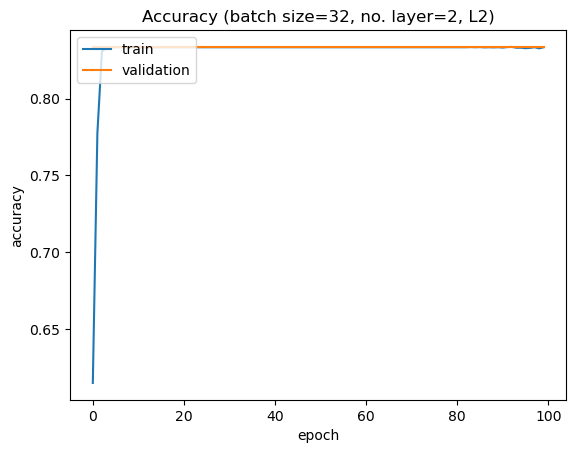

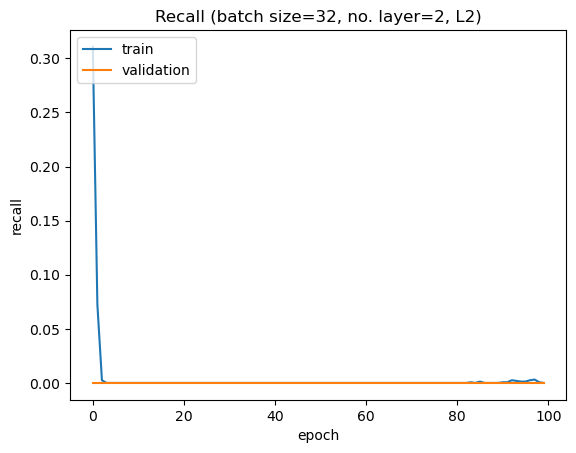

In [110]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [111]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.13
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.135
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [112]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 2s - loss: 0.2463 - accuracy: 0.5499 - recall_23: 0.4606 - val_loss: 0.3572 - val_accuracy: 0.2113 - val_recall_23: 0.9725 - 2s/epoch - 10ms/step
Epoch 2/100
150/150 - 0s - loss: 0.2128 - accuracy: 0.6955 - recall_23: 0.2500 - val_loss: 0.3080 - val_accuracy: 0.2404 - val_recall_23: 0.9625 - 295ms/epoch - 2ms/step
Epoch 3/100
150/150 - 0s - loss: 0.1901 - accuracy: 0.8040 - recall_23: 0.0694 - val_loss: 0.2473 - val_accuracy: 0.5088 - val_recall_23: 0.7225 - 304ms/epoch - 2ms/step
Epoch 4/100
150/150 - 0s - loss: 0.1701 - accuracy: 0.8316 - recall_23: 0.0094 - val_loss: 0.2014 - val_accuracy: 0.7496 - val_recall_23: 0.3300 - 313ms/epoch - 2ms/step
Epoch 5/100
150/150 - 0s - loss: 0.1553 - accuracy: 0.8334 - recall_23: 6.2500e-04 - val_loss: 0.1649 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 324ms/epoch - 2ms/step
Epoch 6/100
150/150 - 0s - loss: 0.1456 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1492 - val_accuracy: 0.8333 - val_recall_23: 0.

Epoch 49/100
150/150 - 0s - loss: 0.1190 - accuracy: 0.8418 - recall_23: 0.1187 - val_loss: 0.1439 - val_accuracy: 0.7958 - val_recall_23: 0.2450 - 310ms/epoch - 2ms/step
Epoch 50/100
150/150 - 0s - loss: 0.1198 - accuracy: 0.8402 - recall_23: 0.1144 - val_loss: 0.1404 - val_accuracy: 0.8112 - val_recall_23: 0.2200 - 289ms/epoch - 2ms/step
Epoch 51/100
150/150 - 0s - loss: 0.1178 - accuracy: 0.8394 - recall_23: 0.1106 - val_loss: 0.1406 - val_accuracy: 0.7979 - val_recall_23: 0.2075 - 340ms/epoch - 2ms/step
Epoch 52/100
150/150 - 0s - loss: 0.1176 - accuracy: 0.8428 - recall_23: 0.1338 - val_loss: 0.1449 - val_accuracy: 0.7900 - val_recall_23: 0.2550 - 329ms/epoch - 2ms/step
Epoch 53/100
150/150 - 0s - loss: 0.1196 - accuracy: 0.8386 - recall_23: 0.1163 - val_loss: 0.1404 - val_accuracy: 0.8079 - val_recall_23: 0.1975 - 363ms/epoch - 2ms/step
Epoch 54/100
150/150 - 0s - loss: 0.1173 - accuracy: 0.8410 - recall_23: 0.1262 - val_loss: 0.1395 - val_accuracy: 0.8100 - val_recall_23: 0.1975

Epoch 97/100
150/150 - 0s - loss: 0.0989 - accuracy: 0.8639 - recall_23: 0.3856 - val_loss: 0.1555 - val_accuracy: 0.7738 - val_recall_23: 0.3475 - 307ms/epoch - 2ms/step
Epoch 98/100
150/150 - 0s - loss: 0.0997 - accuracy: 0.8624 - recall_23: 0.3537 - val_loss: 0.1532 - val_accuracy: 0.7742 - val_recall_23: 0.3250 - 316ms/epoch - 2ms/step
Epoch 99/100
150/150 - 0s - loss: 0.1038 - accuracy: 0.8585 - recall_23: 0.3288 - val_loss: 0.1481 - val_accuracy: 0.7896 - val_recall_23: 0.3200 - 285ms/epoch - 2ms/step
Epoch 100/100
150/150 - 0s - loss: 0.1007 - accuracy: 0.8595 - recall_23: 0.3575 - val_loss: 0.1466 - val_accuracy: 0.7908 - val_recall_23: 0.3075 - 300ms/epoch - 2ms/step


#### Predict

In [113]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

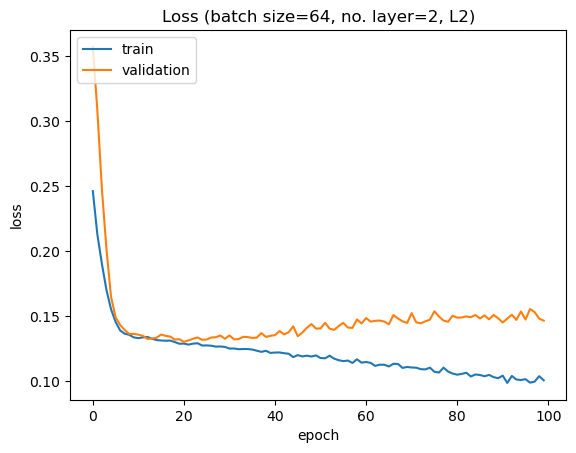

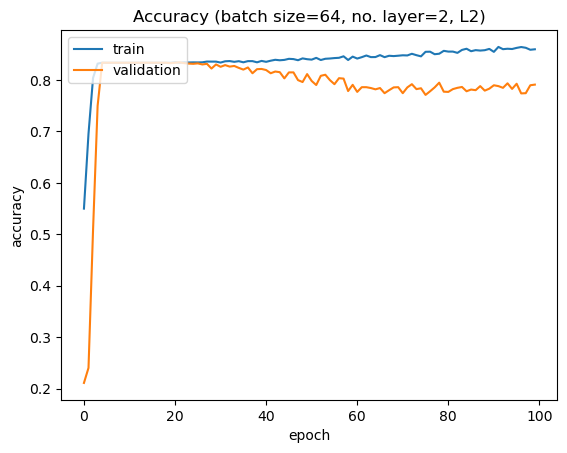

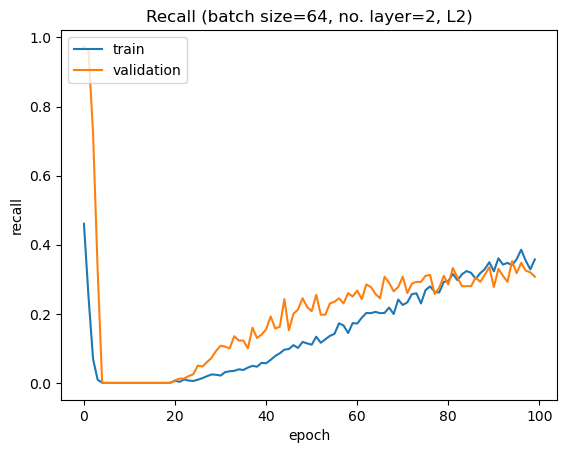

In [114]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [115]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.101
Training Accuracy: 0.859
Training Recall: 0.357


Validation Loss: 0.147
Validation Accuracy: 0.791
Validation Recall: 0.308


## resnet

In [116]:
# left_train = np.load('vgg_train_left.npy')
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

left_train = np.load('resnet_train_left.npy')
right_train = np.load('resnet_train_right.npy')
left_test = np.load('resnet_test_left.npy')
right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [117]:
path = ".\COMP90086_2023_TLLdataset\\train\\left"
dir_list = os.listdir(path)
train_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\train\\right"
dir_list = os.listdir(path)
train_right_images_list = dir_list

left_array_dict = {}
for i in range(len(train_left_images_list)):
    left_array_dict[train_left_images_list[i][:3]] = left_train[i]
    
right_array_dict = {}
for i in range(len(train_right_images_list)):
    right_array_dict[train_right_images_list[i][:3]] = right_train[i]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [118]:
# input_shape = (512,)
input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2\\resnet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2\\resnet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [119]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2306 - accuracy: 0.6821 - recall_24: 0.1706 - val_loss: 0.1742 - val_accuracy: 0.7825 - val_recall_24: 0.0550 - 2s/epoch - 4ms/step
Epoch 2/100
600/600 - 2s - loss: 0.1487 - accuracy: 0.8241 - recall_24: 0.0150 - val_loss: 0.1408 - val_accuracy: 0.8325 - val_recall_24: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 3/100
600/600 - 2s - loss: 0.1394 - accuracy: 0.8333 - recall_24: 0.0000e+00 - val_loss: 0.1396 - val_accuracy: 0.8333 - val_recall_24: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 4/100
600/600 - 2s - loss: 0.1387 - accuracy: 0.8333 - recall_24: 0.0000e+00 - val_loss: 0.1398 - val_accuracy: 0.8333 - val_recall_24: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 5/100
600/600 - 2s - loss: 0.1386 - accuracy: 0.8333 - recall_24: 0.0000e+00 - val_loss: 0.1403 - val_accuracy: 0.8333 - val_recall_24: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 6/100
600/600 - 2s - loss: 0.1387 - accuracy: 0.8333 - recall_24: 0.0000e+00 - val_loss: 0.1398 - val_accuracy: 0.8333 - val_recall

Epoch 50/100
600/600 - 2s - loss: 0.1070 - accuracy: 0.8598 - recall_24: 0.2919 - val_loss: 0.2274 - val_accuracy: 0.7138 - val_recall_24: 0.0825 - 2s/epoch - 3ms/step
Epoch 51/100
600/600 - 2s - loss: 0.1083 - accuracy: 0.8586 - recall_24: 0.3100 - val_loss: 0.2228 - val_accuracy: 0.7200 - val_recall_24: 0.0900 - 2s/epoch - 3ms/step
Epoch 52/100
600/600 - 2s - loss: 0.1068 - accuracy: 0.8575 - recall_24: 0.3069 - val_loss: 0.2146 - val_accuracy: 0.7367 - val_recall_24: 0.0575 - 2s/epoch - 3ms/step
Epoch 53/100
600/600 - 2s - loss: 0.1069 - accuracy: 0.8620 - recall_24: 0.3244 - val_loss: 0.2240 - val_accuracy: 0.7192 - val_recall_24: 0.0750 - 2s/epoch - 3ms/step
Epoch 54/100
600/600 - 1s - loss: 0.1068 - accuracy: 0.8579 - recall_24: 0.3113 - val_loss: 0.2273 - val_accuracy: 0.7096 - val_recall_24: 0.0775 - 1s/epoch - 2ms/step
Epoch 55/100
600/600 - 2s - loss: 0.1072 - accuracy: 0.8584 - recall_24: 0.3088 - val_loss: 0.2356 - val_accuracy: 0.6958 - val_recall_24: 0.0800 - 2s/epoch - 3

Epoch 99/100
600/600 - 2s - loss: 0.0904 - accuracy: 0.8876 - recall_24: 0.4925 - val_loss: 0.2833 - val_accuracy: 0.6658 - val_recall_24: 0.1050 - 2s/epoch - 3ms/step
Epoch 100/100
600/600 - 1s - loss: 0.0891 - accuracy: 0.8901 - recall_24: 0.5069 - val_loss: 0.2653 - val_accuracy: 0.6913 - val_recall_24: 0.0950 - 1s/epoch - 2ms/step


#### Predict

In [120]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

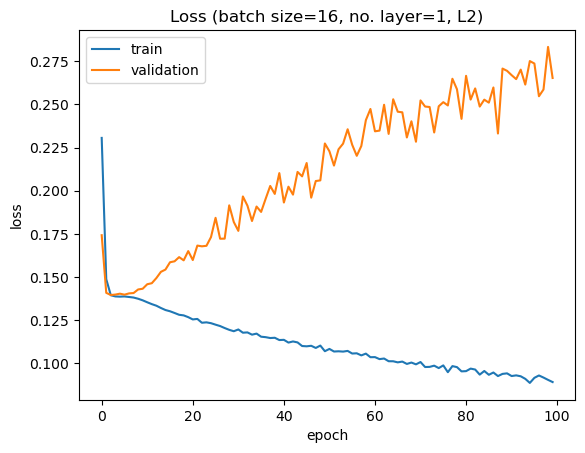

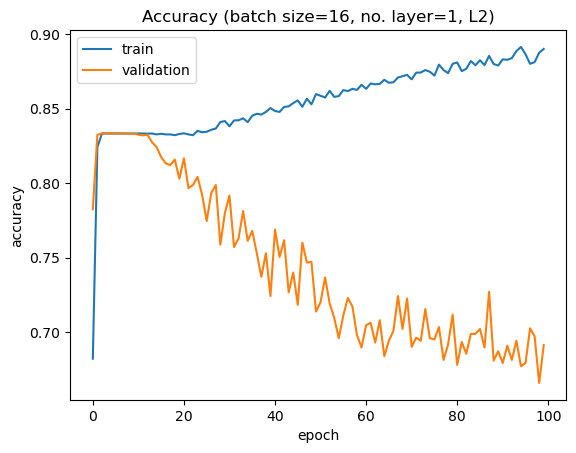

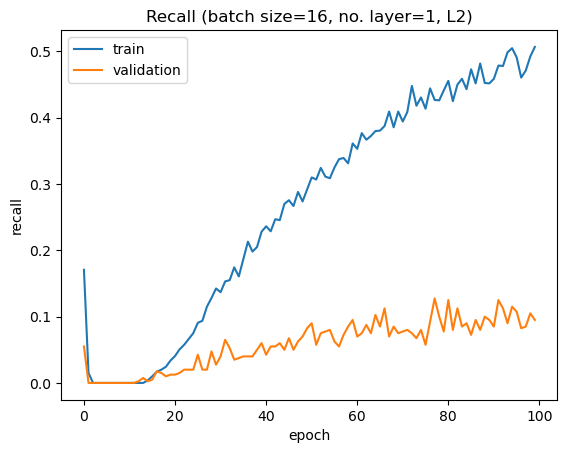

In [121]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [122]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.089
Training Accuracy: 0.89
Training Recall: 0.507


Validation Loss: 0.265
Validation Accuracy: 0.691
Validation Recall: 0.095


### batch size = 32, number of layer = 1

In [123]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 2s - loss: 0.2435 - accuracy: 0.6031 - recall_25: 0.5875 - val_loss: 0.1590 - val_accuracy: 0.7758 - val_recall_25: 0.3400 - 2s/epoch - 6ms/step
Epoch 2/100
300/300 - 1s - loss: 0.1512 - accuracy: 0.7992 - recall_25: 0.3956 - val_loss: 0.1436 - val_accuracy: 0.8188 - val_recall_25: 0.1675 - 781ms/epoch - 3ms/step
Epoch 3/100
300/300 - 1s - loss: 0.1208 - accuracy: 0.8474 - recall_25: 0.2300 - val_loss: 0.1360 - val_accuracy: 0.8254 - val_recall_25: 0.0850 - 769ms/epoch - 3ms/step
Epoch 4/100
300/300 - 1s - loss: 0.1075 - accuracy: 0.8650 - recall_25: 0.2756 - val_loss: 0.1332 - val_accuracy: 0.8254 - val_recall_25: 0.0775 - 800ms/epoch - 3ms/step
Epoch 5/100
300/300 - 1s - loss: 0.0958 - accuracy: 0.8767 - recall_25: 0.3644 - val_loss: 0.1447 - val_accuracy: 0.8029 - val_recall_25: 0.1575 - 802ms/epoch - 3ms/step
Epoch 6/100
300/300 - 1s - loss: 0.0826 - accuracy: 0.9013 - recall_25: 0.5188 - val_loss: 0.1421 - val_accuracy: 0.8171 - val_recall_25: 0.1000 - 761ms/

Epoch 49/100
300/300 - 1s - loss: 0.0120 - accuracy: 0.9855 - recall_25: 0.9513 - val_loss: 0.1919 - val_accuracy: 0.7829 - val_recall_25: 0.1775 - 808ms/epoch - 3ms/step
Epoch 50/100
300/300 - 1s - loss: 0.0128 - accuracy: 0.9844 - recall_25: 0.9481 - val_loss: 0.1868 - val_accuracy: 0.7908 - val_recall_25: 0.1775 - 845ms/epoch - 3ms/step
Epoch 51/100
300/300 - 1s - loss: 0.0097 - accuracy: 0.9894 - recall_25: 0.9613 - val_loss: 0.1947 - val_accuracy: 0.7738 - val_recall_25: 0.2200 - 826ms/epoch - 3ms/step
Epoch 52/100
300/300 - 1s - loss: 0.0114 - accuracy: 0.9861 - recall_25: 0.9481 - val_loss: 0.1871 - val_accuracy: 0.7875 - val_recall_25: 0.2025 - 753ms/epoch - 3ms/step
Epoch 53/100
300/300 - 1s - loss: 0.0092 - accuracy: 0.9892 - recall_25: 0.9569 - val_loss: 0.1924 - val_accuracy: 0.7796 - val_recall_25: 0.2025 - 752ms/epoch - 3ms/step
Epoch 54/100
300/300 - 1s - loss: 0.0112 - accuracy: 0.9861 - recall_25: 0.9444 - val_loss: 0.1994 - val_accuracy: 0.7729 - val_recall_25: 0.2225

Epoch 97/100
300/300 - 1s - loss: 0.0081 - accuracy: 0.9903 - recall_25: 0.9694 - val_loss: 0.1874 - val_accuracy: 0.7929 - val_recall_25: 0.2175 - 919ms/epoch - 3ms/step
Epoch 98/100
300/300 - 1s - loss: 0.0061 - accuracy: 0.9930 - recall_25: 0.9700 - val_loss: 0.1962 - val_accuracy: 0.7833 - val_recall_25: 0.2475 - 862ms/epoch - 3ms/step
Epoch 99/100
300/300 - 1s - loss: 0.0085 - accuracy: 0.9900 - recall_25: 0.9650 - val_loss: 0.1905 - val_accuracy: 0.7908 - val_recall_25: 0.2050 - 846ms/epoch - 3ms/step
Epoch 100/100
300/300 - 1s - loss: 0.0101 - accuracy: 0.9873 - recall_25: 0.9550 - val_loss: 0.1952 - val_accuracy: 0.7875 - val_recall_25: 0.2100 - 841ms/epoch - 3ms/step


#### Predict

In [124]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

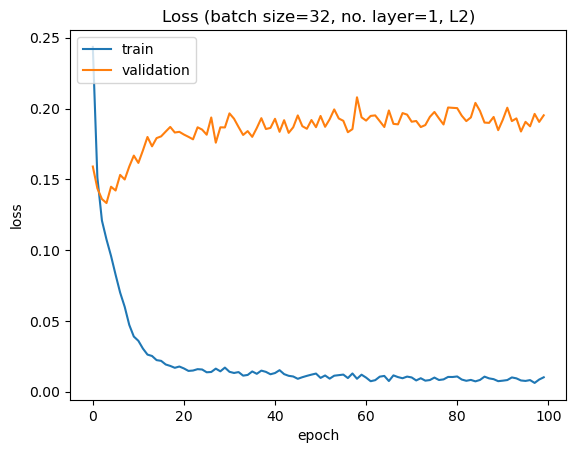

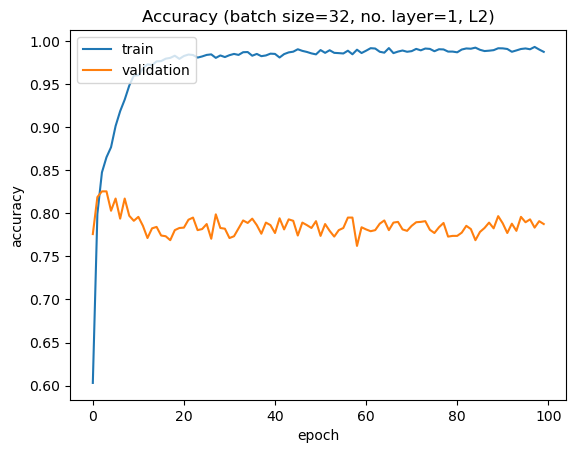

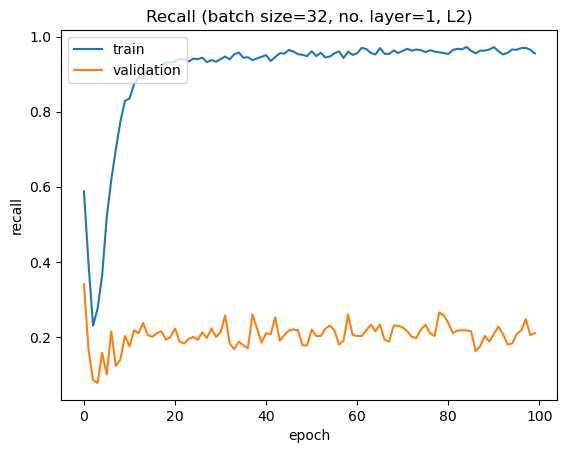

In [125]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [126]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.01
Training Accuracy: 0.987
Training Recall: 0.955


Validation Loss: 0.195
Validation Accuracy: 0.788
Validation Recall: 0.21


### batch size = 64, number of layer = 1

In [127]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 2s - loss: 0.2351 - accuracy: 0.5869 - recall_26: 0.6394 - val_loss: 0.1473 - val_accuracy: 0.8138 - val_recall_26: 0.1800 - 2s/epoch - 13ms/step
Epoch 2/100
150/150 - 0s - loss: 0.1887 - accuracy: 0.7358 - recall_26: 0.5750 - val_loss: 0.1673 - val_accuracy: 0.7846 - val_recall_26: 0.2475 - 494ms/epoch - 3ms/step
Epoch 3/100
150/150 - 0s - loss: 0.1555 - accuracy: 0.8179 - recall_26: 0.5125 - val_loss: 0.1503 - val_accuracy: 0.8067 - val_recall_26: 0.1650 - 478ms/epoch - 3ms/step
Epoch 4/100
150/150 - 1s - loss: 0.1280 - accuracy: 0.8651 - recall_26: 0.5006 - val_loss: 0.1641 - val_accuracy: 0.7817 - val_recall_26: 0.2950 - 520ms/epoch - 3ms/step
Epoch 5/100
150/150 - 0s - loss: 0.1046 - accuracy: 0.8926 - recall_26: 0.5481 - val_loss: 0.1524 - val_accuracy: 0.7996 - val_recall_26: 0.1925 - 491ms/epoch - 3ms/step
Epoch 6/100
150/150 - 0s - loss: 0.0850 - accuracy: 0.9128 - recall_26: 0.6194 - val_loss: 0.1622 - val_accuracy: 0.7717 - val_recall_26: 0.2075 - 487ms

Epoch 49/100
150/150 - 1s - loss: 0.0067 - accuracy: 0.9919 - recall_26: 0.9750 - val_loss: 0.1836 - val_accuracy: 0.7892 - val_recall_26: 0.2050 - 601ms/epoch - 4ms/step
Epoch 50/100
150/150 - 1s - loss: 0.0050 - accuracy: 0.9946 - recall_26: 0.9812 - val_loss: 0.1929 - val_accuracy: 0.7783 - val_recall_26: 0.2175 - 620ms/epoch - 4ms/step
Epoch 51/100
150/150 - 1s - loss: 0.0048 - accuracy: 0.9948 - recall_26: 0.9812 - val_loss: 0.1942 - val_accuracy: 0.7763 - val_recall_26: 0.2200 - 581ms/epoch - 4ms/step
Epoch 52/100
150/150 - 1s - loss: 0.0052 - accuracy: 0.9948 - recall_26: 0.9844 - val_loss: 0.1929 - val_accuracy: 0.7729 - val_recall_26: 0.2100 - 576ms/epoch - 4ms/step
Epoch 53/100
150/150 - 1s - loss: 0.0050 - accuracy: 0.9939 - recall_26: 0.9812 - val_loss: 0.1878 - val_accuracy: 0.7862 - val_recall_26: 0.2075 - 567ms/epoch - 4ms/step
Epoch 54/100
150/150 - 1s - loss: 0.0048 - accuracy: 0.9947 - recall_26: 0.9819 - val_loss: 0.1936 - val_accuracy: 0.7779 - val_recall_26: 0.2125

Epoch 97/100
150/150 - 1s - loss: 0.0062 - accuracy: 0.9924 - recall_26: 0.9737 - val_loss: 0.1852 - val_accuracy: 0.7962 - val_recall_26: 0.1975 - 569ms/epoch - 4ms/step
Epoch 98/100
150/150 - 1s - loss: 0.0046 - accuracy: 0.9941 - recall_26: 0.9787 - val_loss: 0.1818 - val_accuracy: 0.8021 - val_recall_26: 0.1600 - 561ms/epoch - 4ms/step
Epoch 99/100
150/150 - 1s - loss: 0.0050 - accuracy: 0.9936 - recall_26: 0.9850 - val_loss: 0.1818 - val_accuracy: 0.7992 - val_recall_26: 0.1900 - 544ms/epoch - 4ms/step
Epoch 100/100
150/150 - 1s - loss: 0.0031 - accuracy: 0.9965 - recall_26: 0.9862 - val_loss: 0.1804 - val_accuracy: 0.8050 - val_recall_26: 0.1900 - 544ms/epoch - 4ms/step


#### Predict

In [128]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

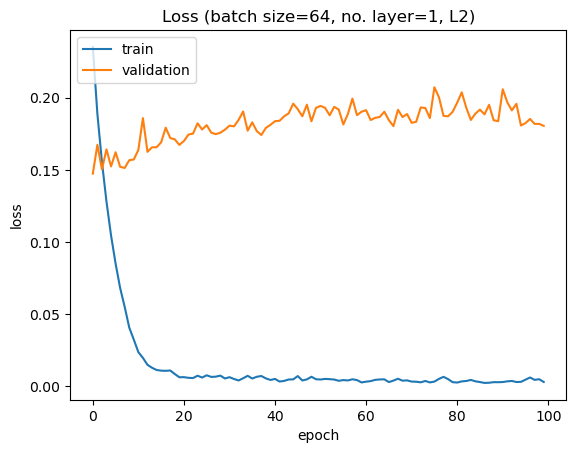

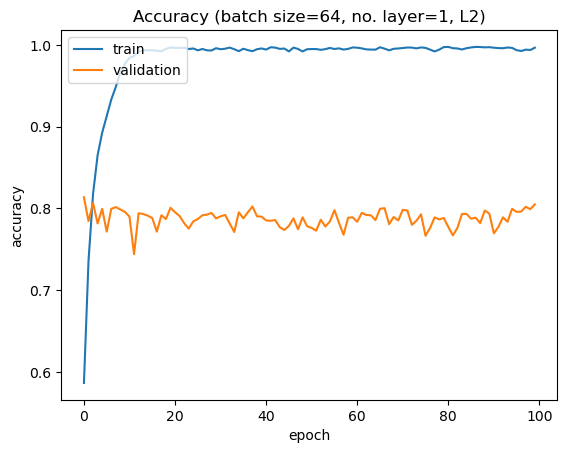

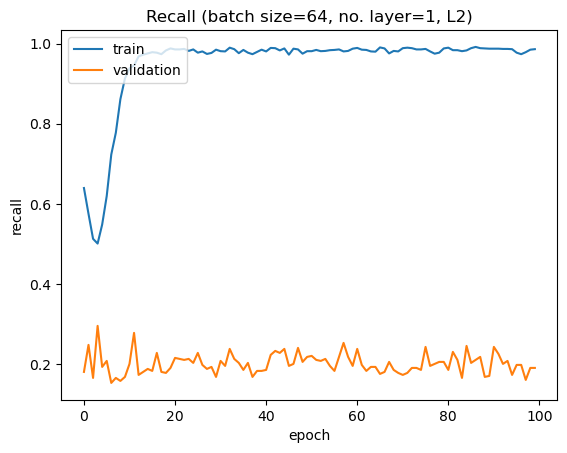

In [129]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [130]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.003
Training Accuracy: 0.996
Training Recall: 0.986


Validation Loss: 0.18
Validation Accuracy: 0.805
Validation Recall: 0.19


### batch size = 16, number of layer = 2

In [131]:
def create_shared_network(input_shape):
    model = keras.Sequential([
        
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2\\resnet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2\\resnet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [132]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 3s - loss: 0.2274 - accuracy: 0.6734 - recall_27: 0.2362 - val_loss: 0.1460 - val_accuracy: 0.8329 - val_recall_27: 0.0000e+00 - 3s/epoch - 5ms/step
Epoch 2/100
600/600 - 2s - loss: 0.1468 - accuracy: 0.8295 - recall_27: 0.0063 - val_loss: 0.1432 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 3/100
600/600 - 2s - loss: 0.1396 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1409 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1390 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1397 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1390 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1391 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_re

Epoch 48/100
600/600 - 1s - loss: 0.1334 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1380 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 49/100
600/600 - 2s - loss: 0.1331 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1376 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 50/100
600/600 - 1s - loss: 0.1329 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1382 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 51/100
600/600 - 1s - loss: 0.1330 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 52/100
600/600 - 1s - loss: 0.1325 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1387 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 53/100
600/600 - 2s - loss: 0.1331 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1384 - val_accuracy: 0

Epoch 95/100
600/600 - 2s - loss: 0.1306 - accuracy: 0.8330 - recall_27: 0.0012 - val_loss: 0.1422 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 96/100
600/600 - 2s - loss: 0.1299 - accuracy: 0.8334 - recall_27: 0.0012 - val_loss: 0.1436 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 97/100
600/600 - 2s - loss: 0.1306 - accuracy: 0.8330 - recall_27: 6.2500e-04 - val_loss: 0.1426 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 98/100
600/600 - 2s - loss: 0.1300 - accuracy: 0.8332 - recall_27: 0.0012 - val_loss: 0.1446 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 99/100
600/600 - 2s - loss: 0.1285 - accuracy: 0.8333 - recall_27: 0.0012 - val_loss: 0.1447 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 100/100
600/600 - 2s - loss: 0.1289 - accuracy: 0.8326 - recall_27: 0.0019 - val_loss: 0.1445 - val_accuracy: 0.8333 - val_recall_

#### Predict

In [133]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

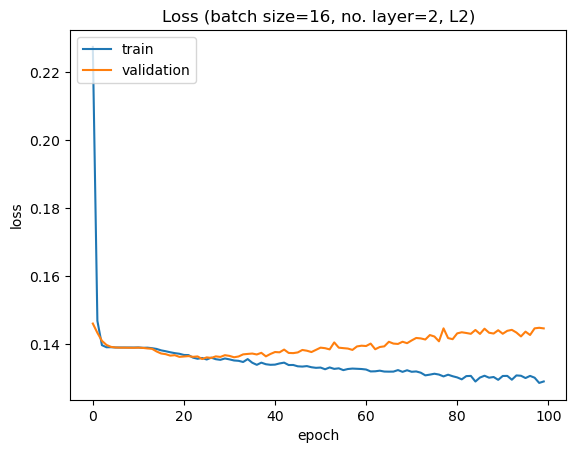

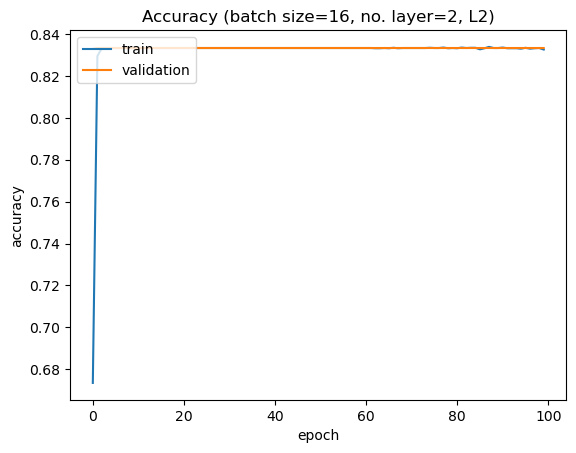

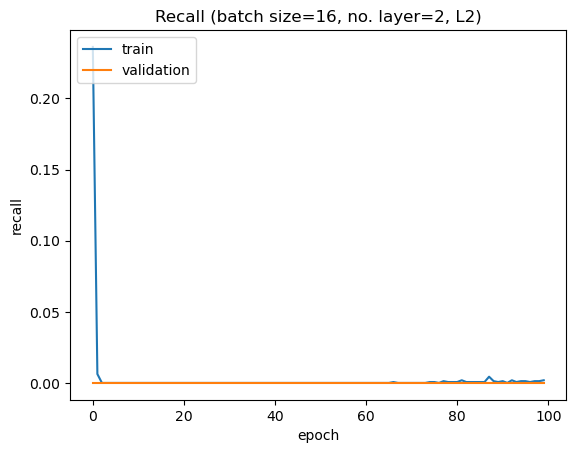

In [134]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [135]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.129
Training Accuracy: 0.833
Training Recall: 0.002


Validation Loss: 0.145
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [136]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 3s - loss: 0.2509 - accuracy: 0.6198 - recall_28: 0.2869 - val_loss: 0.1473 - val_accuracy: 0.8258 - val_recall_28: 0.0075 - 3s/epoch - 8ms/step
Epoch 2/100
300/300 - 1s - loss: 0.1827 - accuracy: 0.7619 - recall_28: 0.1013 - val_loss: 0.1410 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 874ms/epoch - 3ms/step
Epoch 3/100
300/300 - 1s - loss: 0.1537 - accuracy: 0.8256 - recall_28: 0.0137 - val_loss: 0.1398 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 931ms/epoch - 3ms/step
Epoch 4/100
300/300 - 1s - loss: 0.1433 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1396 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 965ms/epoch - 3ms/step
Epoch 5/100
300/300 - 1s - loss: 0.1400 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1395 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 941ms/epoch - 3ms/step
Epoch 6/100
300/300 - 1s - loss: 0.1392 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1393 - val_accuracy: 0.8333 - va

300/300 - 1s - loss: 0.1357 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1360 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 921ms/epoch - 3ms/step
Epoch 48/100
300/300 - 1s - loss: 0.1355 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1366 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 969ms/epoch - 3ms/step
Epoch 49/100
300/300 - 1s - loss: 0.1358 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1364 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 921ms/epoch - 3ms/step
Epoch 50/100
300/300 - 1s - loss: 0.1353 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1360 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 939ms/epoch - 3ms/step
Epoch 51/100
300/300 - 1s - loss: 0.1352 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1363 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 944ms/epoch - 3ms/step
Epoch 52/100
300/300 - 1s - loss: 0.1349 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1365 - val_accuracy:

Epoch 93/100
300/300 - 1s - loss: 0.1308 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1430 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 830ms/epoch - 3ms/step
Epoch 94/100
300/300 - 1s - loss: 0.1320 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1415 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 830ms/epoch - 3ms/step
Epoch 95/100
300/300 - 1s - loss: 0.1309 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1429 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 931ms/epoch - 3ms/step
Epoch 96/100
300/300 - 1s - loss: 0.1306 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1422 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 930ms/epoch - 3ms/step
Epoch 97/100
300/300 - 1s - loss: 0.1313 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1430 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 805ms/epoch - 3ms/step
Epoch 98/100
300/300 - 1s - loss: 0.1309 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1435 - 

#### Predict

In [137]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

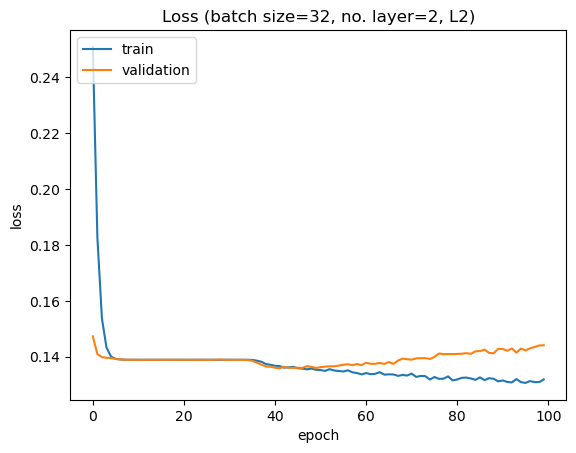

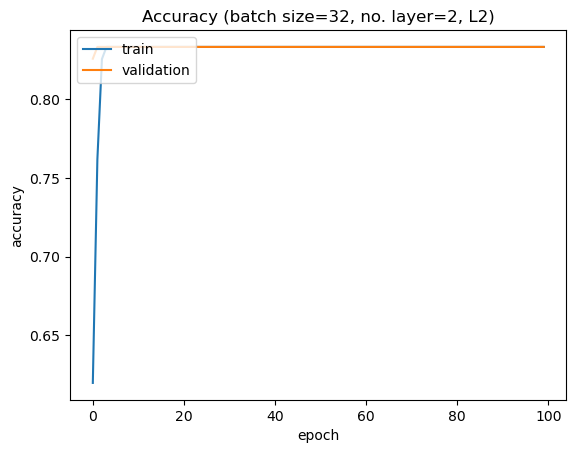

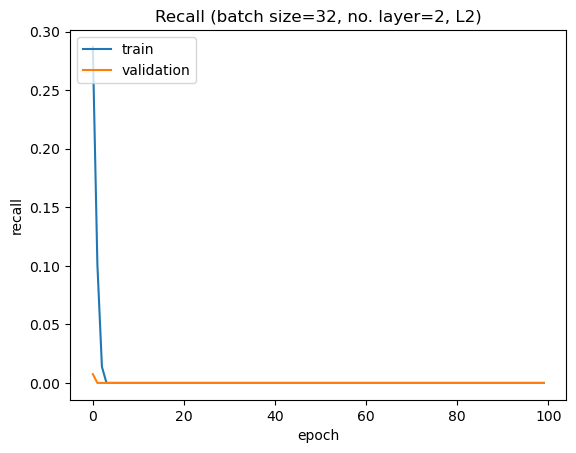

In [138]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [139]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.132
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.144
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [140]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 2s - loss: 0.2444 - accuracy: 0.5985 - recall_29: 0.3113 - val_loss: 0.1757 - val_accuracy: 0.8217 - val_recall_29: 0.0075 - 2s/epoch - 11ms/step
Epoch 2/100
150/150 - 0s - loss: 0.2142 - accuracy: 0.7228 - recall_29: 0.1488 - val_loss: 0.1645 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 429ms/epoch - 3ms/step
Epoch 3/100
150/150 - 0s - loss: 0.1945 - accuracy: 0.8056 - recall_29: 0.0262 - val_loss: 0.1557 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 465ms/epoch - 3ms/step
Epoch 4/100
150/150 - 1s - loss: 0.1763 - accuracy: 0.8308 - recall_29: 0.0063 - val_loss: 0.1463 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 501ms/epoch - 3ms/step
Epoch 5/100
150/150 - 1s - loss: 0.1614 - accuracy: 0.8331 - recall_29: 0.0000e+00 - val_loss: 0.1417 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 520ms/epoch - 3ms/step
Epoch 6/100
150/150 - 1s - loss: 0.1509 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1398 - val_accuracy: 0.8333 - val_r

Epoch 47/100
150/150 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 532ms/epoch - 4ms/step
Epoch 48/100
150/150 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 561ms/epoch - 4ms/step
Epoch 49/100
150/150 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 564ms/epoch - 4ms/step
Epoch 50/100
150/150 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 512ms/epoch - 3ms/step
Epoch 51/100
150/150 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 502ms/epoch - 3ms/step
Epoch 52/100
150/150 - 0s - loss: 0.1389 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1389 - 

Epoch 93/100
150/150 - 1s - loss: 0.1375 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1406 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 517ms/epoch - 3ms/step
Epoch 94/100
150/150 - 1s - loss: 0.1385 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1410 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 518ms/epoch - 3ms/step
Epoch 95/100
150/150 - 1s - loss: 0.1380 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1407 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 537ms/epoch - 4ms/step
Epoch 96/100
150/150 - 1s - loss: 0.1381 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1408 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 530ms/epoch - 4ms/step
Epoch 97/100
150/150 - 0s - loss: 0.1382 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1407 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 492ms/epoch - 3ms/step
Epoch 98/100
150/150 - 0s - loss: 0.1383 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1407 - 

#### Predict

In [141]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

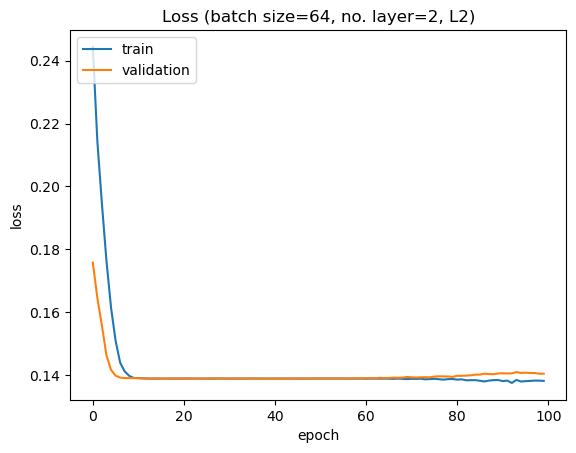

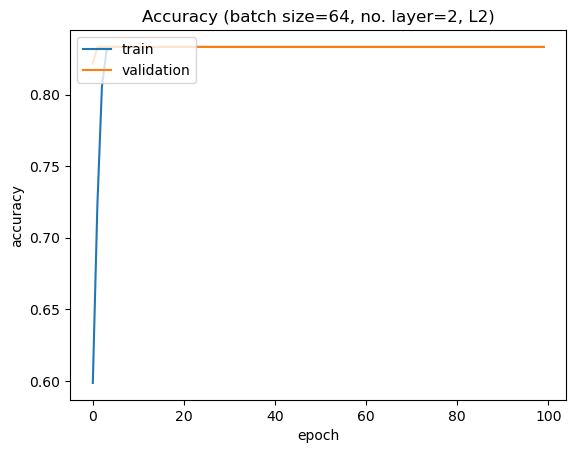

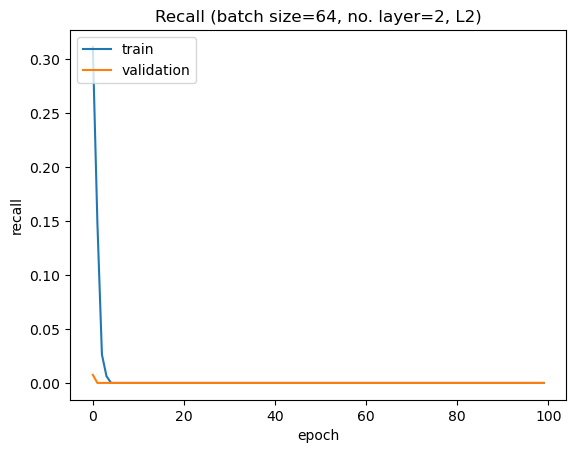

In [142]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [143]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.138
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.14
Validation Accuracy: 0.833
Validation Recall: 0.0


## densenet

In [144]:
# left_train = np.load('vgg_train_left.npy')
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

left_train = np.load('densenet_train_left.npy')
right_train = np.load('densenet_train_right.npy')
left_test = np.load('densenet_test_left.npy')
right_test = np.load('densenet_test_right.npy')

In [145]:
path = ".\COMP90086_2023_TLLdataset\\train\\left"
dir_list = os.listdir(path)
train_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\train\\right"
dir_list = os.listdir(path)
train_right_images_list = dir_list

left_array_dict = {}
for i in range(len(train_left_images_list)):
    left_array_dict[train_left_images_list[i][:3]] = left_train[i]
    
right_array_dict = {}
for i in range(len(train_right_images_list)):
    right_array_dict[train_right_images_list[i][:3]] = right_train[i]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [146]:
# input_shape = (512,)
# input_shape = (2048,)
input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2\\densenet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2\\densenet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [147]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2140 - accuracy: 0.7118 - recall_30: 0.1256 - val_loss: 0.1781 - val_accuracy: 0.8133 - val_recall_30: 0.0150 - 2s/epoch - 4ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1558 - accuracy: 0.8325 - recall_30: 0.0012 - val_loss: 0.1462 - val_accuracy: 0.8325 - val_recall_30: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1401 - accuracy: 0.8333 - recall_30: 0.0000e+00 - val_loss: 0.1418 - val_accuracy: 0.8333 - val_recall_30: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1383 - accuracy: 0.8333 - recall_30: 0.0000e+00 - val_loss: 0.1418 - val_accuracy: 0.8333 - val_recall_30: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1378 - accuracy: 0.8333 - recall_30: 0.0000e+00 - val_loss: 0.1428 - val_accuracy: 0.8333 - val_recall_30: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1371 - accuracy: 0.8333 - recall_30: 0.0000e+00 - val_loss: 0.1443 - val_accuracy: 0.8333 - val_recall

Epoch 50/100
600/600 - 1s - loss: 0.1061 - accuracy: 0.8699 - recall_30: 0.3519 - val_loss: 0.2426 - val_accuracy: 0.6983 - val_recall_30: 0.0800 - 1s/epoch - 2ms/step
Epoch 51/100
600/600 - 1s - loss: 0.1083 - accuracy: 0.8634 - recall_30: 0.3262 - val_loss: 0.2446 - val_accuracy: 0.6958 - val_recall_30: 0.0725 - 1s/epoch - 2ms/step
Epoch 52/100
600/600 - 1s - loss: 0.1072 - accuracy: 0.8658 - recall_30: 0.3425 - val_loss: 0.2382 - val_accuracy: 0.7079 - val_recall_30: 0.0725 - 1s/epoch - 2ms/step
Epoch 53/100
600/600 - 1s - loss: 0.1083 - accuracy: 0.8636 - recall_30: 0.3375 - val_loss: 0.2480 - val_accuracy: 0.6946 - val_recall_30: 0.0825 - 1s/epoch - 2ms/step
Epoch 54/100
600/600 - 1s - loss: 0.1055 - accuracy: 0.8698 - recall_30: 0.3581 - val_loss: 0.2526 - val_accuracy: 0.6913 - val_recall_30: 0.0975 - 1s/epoch - 2ms/step
Epoch 55/100
600/600 - 1s - loss: 0.1055 - accuracy: 0.8705 - recall_30: 0.3656 - val_loss: 0.2564 - val_accuracy: 0.6829 - val_recall_30: 0.0775 - 1s/epoch - 2

Epoch 99/100
600/600 - 1s - loss: 0.0923 - accuracy: 0.8902 - recall_30: 0.4831 - val_loss: 0.2793 - val_accuracy: 0.6800 - val_recall_30: 0.1075 - 1s/epoch - 2ms/step
Epoch 100/100
600/600 - 1s - loss: 0.0929 - accuracy: 0.8894 - recall_30: 0.4850 - val_loss: 0.2776 - val_accuracy: 0.6837 - val_recall_30: 0.1000 - 1s/epoch - 2ms/step


#### Predict

In [148]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

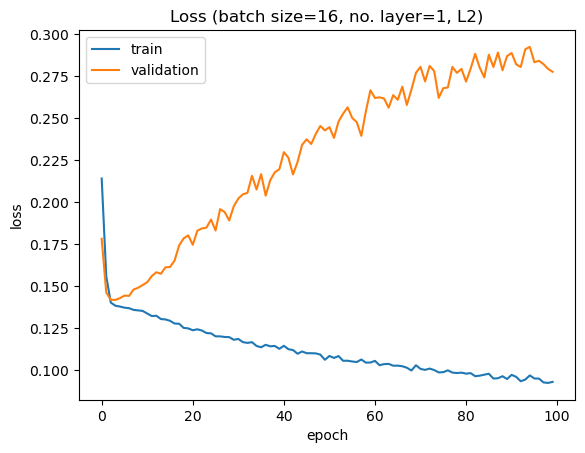

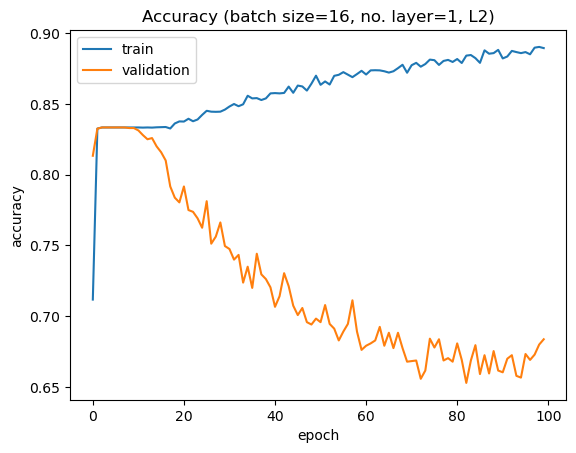

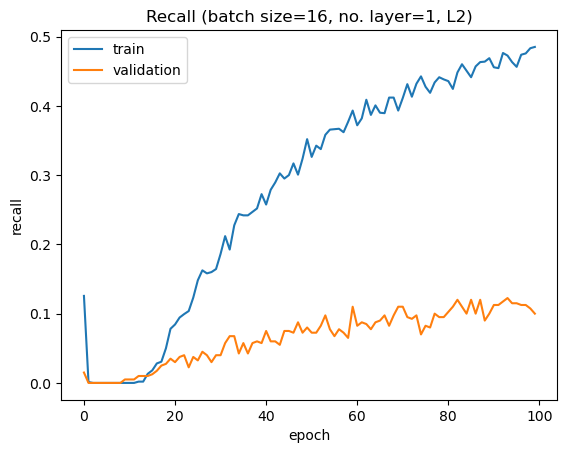

In [149]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [150]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.093
Training Accuracy: 0.889
Training Recall: 0.485


Validation Loss: 0.278
Validation Accuracy: 0.684
Validation Recall: 0.1


### batch size = 32, number of layer = 1

In [151]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 2s - loss: 0.2205 - accuracy: 0.8146 - recall_31: 0.1850 - val_loss: 0.1617 - val_accuracy: 0.8317 - val_recall_31: 0.1750 - 2s/epoch - 5ms/step
Epoch 2/100
300/300 - 1s - loss: 0.1526 - accuracy: 0.8462 - recall_31: 0.4544 - val_loss: 0.1337 - val_accuracy: 0.8325 - val_recall_31: 0.2600 - 630ms/epoch - 2ms/step
Epoch 3/100
300/300 - 1s - loss: 0.1100 - accuracy: 0.8758 - recall_31: 0.4744 - val_loss: 0.1330 - val_accuracy: 0.8283 - val_recall_31: 0.3000 - 707ms/epoch - 2ms/step
Epoch 4/100
300/300 - 1s - loss: 0.0876 - accuracy: 0.8969 - recall_31: 0.5406 - val_loss: 0.1286 - val_accuracy: 0.8304 - val_recall_31: 0.2800 - 669ms/epoch - 2ms/step
Epoch 5/100
300/300 - 1s - loss: 0.0735 - accuracy: 0.9103 - recall_31: 0.6231 - val_loss: 0.1315 - val_accuracy: 0.8325 - val_recall_31: 0.2850 - 679ms/epoch - 2ms/step
Epoch 6/100
300/300 - 1s - loss: 0.0601 - accuracy: 0.9291 - recall_31: 0.6906 - val_loss: 0.1390 - val_accuracy: 0.8167 - val_recall_31: 0.3300 - 664ms/

Epoch 49/100
300/300 - 1s - loss: 0.0100 - accuracy: 0.9889 - recall_31: 0.9575 - val_loss: 0.1880 - val_accuracy: 0.7858 - val_recall_31: 0.3075 - 769ms/epoch - 3ms/step
Epoch 50/100
300/300 - 1s - loss: 0.0094 - accuracy: 0.9896 - recall_31: 0.9594 - val_loss: 0.1822 - val_accuracy: 0.7962 - val_recall_31: 0.3050 - 696ms/epoch - 2ms/step
Epoch 51/100
300/300 - 1s - loss: 0.0109 - accuracy: 0.9871 - recall_31: 0.9475 - val_loss: 0.1870 - val_accuracy: 0.7896 - val_recall_31: 0.3375 - 696ms/epoch - 2ms/step
Epoch 52/100
300/300 - 1s - loss: 0.0130 - accuracy: 0.9844 - recall_31: 0.9413 - val_loss: 0.1909 - val_accuracy: 0.7883 - val_recall_31: 0.3500 - 703ms/epoch - 2ms/step
Epoch 53/100
300/300 - 1s - loss: 0.0101 - accuracy: 0.9880 - recall_31: 0.9544 - val_loss: 0.1930 - val_accuracy: 0.7783 - val_recall_31: 0.3275 - 711ms/epoch - 2ms/step
Epoch 54/100
300/300 - 1s - loss: 0.0111 - accuracy: 0.9872 - recall_31: 0.9494 - val_loss: 0.1948 - val_accuracy: 0.7788 - val_recall_31: 0.3300

Epoch 97/100
300/300 - 1s - loss: 0.0100 - accuracy: 0.9879 - recall_31: 0.9538 - val_loss: 0.1838 - val_accuracy: 0.7942 - val_recall_31: 0.3125 - 737ms/epoch - 2ms/step
Epoch 98/100
300/300 - 1s - loss: 0.0111 - accuracy: 0.9865 - recall_31: 0.9525 - val_loss: 0.1828 - val_accuracy: 0.7954 - val_recall_31: 0.2950 - 740ms/epoch - 2ms/step
Epoch 99/100
300/300 - 1s - loss: 0.0089 - accuracy: 0.9898 - recall_31: 0.9556 - val_loss: 0.1924 - val_accuracy: 0.7846 - val_recall_31: 0.3350 - 687ms/epoch - 2ms/step
Epoch 100/100
300/300 - 1s - loss: 0.0097 - accuracy: 0.9891 - recall_31: 0.9619 - val_loss: 0.1880 - val_accuracy: 0.7925 - val_recall_31: 0.2875 - 670ms/epoch - 2ms/step


#### Predict

In [152]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

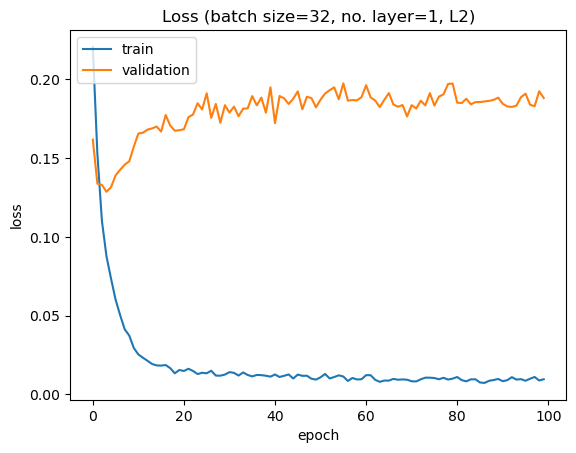

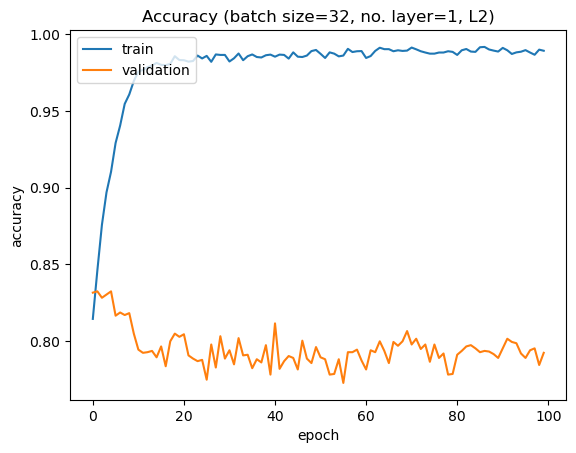

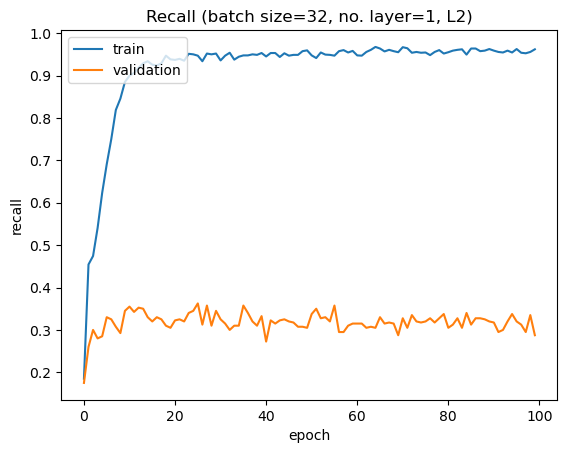

In [153]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [154]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.01
Training Accuracy: 0.989
Training Recall: 0.962


Validation Loss: 0.188
Validation Accuracy: 0.793
Validation Recall: 0.287


### batch size = 64, number of layer = 1

In [155]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 1s - loss: 0.2279 - accuracy: 0.6143 - recall_32: 0.6431 - val_loss: 0.1384 - val_accuracy: 0.8325 - val_recall_32: 0.1950 - 1s/epoch - 9ms/step
Epoch 2/100
150/150 - 0s - loss: 0.1801 - accuracy: 0.7703 - recall_32: 0.6463 - val_loss: 0.1521 - val_accuracy: 0.8100 - val_recall_32: 0.3475 - 346ms/epoch - 2ms/step
Epoch 3/100
150/150 - 0s - loss: 0.1433 - accuracy: 0.8497 - recall_32: 0.6494 - val_loss: 0.1468 - val_accuracy: 0.8158 - val_recall_32: 0.3800 - 304ms/epoch - 2ms/step
Epoch 4/100
150/150 - 0s - loss: 0.1131 - accuracy: 0.8859 - recall_32: 0.6500 - val_loss: 0.1410 - val_accuracy: 0.8196 - val_recall_32: 0.3650 - 308ms/epoch - 2ms/step
Epoch 5/100
150/150 - 0s - loss: 0.0898 - accuracy: 0.9144 - recall_32: 0.7069 - val_loss: 0.1417 - val_accuracy: 0.8096 - val_recall_32: 0.3600 - 329ms/epoch - 2ms/step
Epoch 6/100
150/150 - 0s - loss: 0.0717 - accuracy: 0.9343 - recall_32: 0.7538 - val_loss: 0.1435 - val_accuracy: 0.8029 - val_recall_32: 0.3475 - 336ms/

Epoch 49/100
150/150 - 0s - loss: 0.0037 - accuracy: 0.9966 - recall_32: 0.9894 - val_loss: 0.1827 - val_accuracy: 0.7879 - val_recall_32: 0.3625 - 332ms/epoch - 2ms/step
Epoch 50/100
150/150 - 0s - loss: 0.0043 - accuracy: 0.9961 - recall_32: 0.9869 - val_loss: 0.1798 - val_accuracy: 0.7925 - val_recall_32: 0.3250 - 363ms/epoch - 2ms/step
Epoch 51/100
150/150 - 0s - loss: 0.0048 - accuracy: 0.9952 - recall_32: 0.9862 - val_loss: 0.1665 - val_accuracy: 0.8117 - val_recall_32: 0.2700 - 357ms/epoch - 2ms/step
Epoch 52/100
150/150 - 0s - loss: 0.0042 - accuracy: 0.9947 - recall_32: 0.9856 - val_loss: 0.1801 - val_accuracy: 0.7921 - val_recall_32: 0.3275 - 351ms/epoch - 2ms/step
Epoch 53/100
150/150 - 0s - loss: 0.0030 - accuracy: 0.9970 - recall_32: 0.9875 - val_loss: 0.1757 - val_accuracy: 0.7996 - val_recall_32: 0.3025 - 380ms/epoch - 3ms/step
Epoch 54/100
150/150 - 0s - loss: 0.0029 - accuracy: 0.9969 - recall_32: 0.9912 - val_loss: 0.1867 - val_accuracy: 0.7862 - val_recall_32: 0.3475

Epoch 97/100
150/150 - 0s - loss: 0.0039 - accuracy: 0.9947 - recall_32: 0.9825 - val_loss: 0.1925 - val_accuracy: 0.7871 - val_recall_32: 0.3275 - 391ms/epoch - 3ms/step
Epoch 98/100
150/150 - 0s - loss: 0.0039 - accuracy: 0.9952 - recall_32: 0.9837 - val_loss: 0.1913 - val_accuracy: 0.7862 - val_recall_32: 0.3300 - 369ms/epoch - 2ms/step
Epoch 99/100
150/150 - 0s - loss: 0.0024 - accuracy: 0.9973 - recall_32: 0.9912 - val_loss: 0.1790 - val_accuracy: 0.7979 - val_recall_32: 0.3000 - 374ms/epoch - 2ms/step
Epoch 100/100
150/150 - 0s - loss: 0.0025 - accuracy: 0.9970 - recall_32: 0.9912 - val_loss: 0.1816 - val_accuracy: 0.8008 - val_recall_32: 0.3100 - 379ms/epoch - 3ms/step


#### Predict

In [156]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

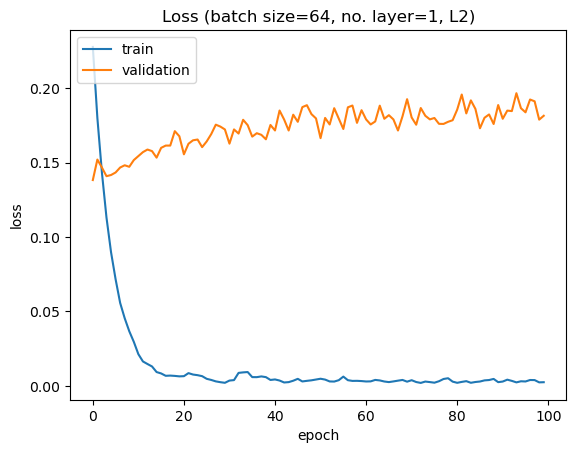

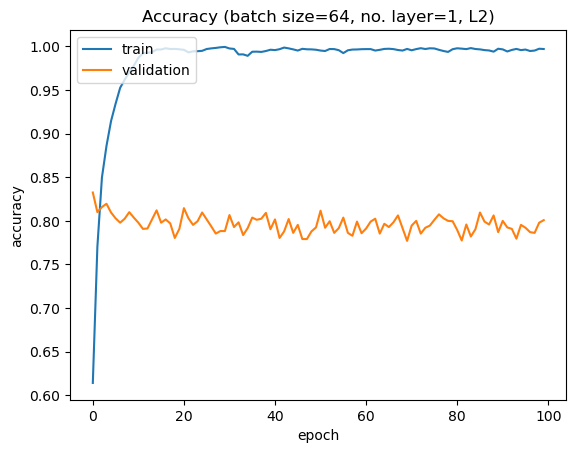

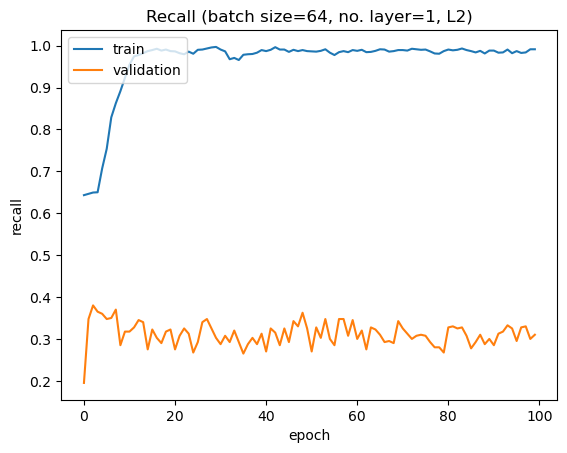

In [157]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [158]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.002
Training Accuracy: 0.997
Training Recall: 0.991


Validation Loss: 0.182
Validation Accuracy: 0.801
Validation Recall: 0.31


### batch size = 16, number of layer = 2

In [159]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2\\densenet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2\\densenet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [160]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2097 - accuracy: 0.7005 - recall_33: 0.2156 - val_loss: 0.2323 - val_accuracy: 0.5729 - val_recall_33: 0.5850 - 2s/epoch - 4ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1505 - accuracy: 0.8334 - recall_33: 6.2500e-04 - val_loss: 0.1470 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1386 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1362 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1370 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1350 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1367 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1343 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 968ms/epoch - 2ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1361 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1338 - val_accuracy: 0.8333 - val

Epoch 48/100
600/600 - 1s - loss: 0.1285 - accuracy: 0.8330 - recall_33: 0.0088 - val_loss: 0.1330 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 49/100
600/600 - 1s - loss: 0.1283 - accuracy: 0.8335 - recall_33: 0.0113 - val_loss: 0.1326 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 50/100
600/600 - 1s - loss: 0.1265 - accuracy: 0.8344 - recall_33: 0.0125 - val_loss: 0.1327 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 984ms/epoch - 2ms/step
Epoch 51/100
600/600 - 1s - loss: 0.1268 - accuracy: 0.8348 - recall_33: 0.0213 - val_loss: 0.1320 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 52/100
600/600 - 1s - loss: 0.1275 - accuracy: 0.8343 - recall_33: 0.0125 - val_loss: 0.1322 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 53/100
600/600 - 1s - loss: 0.1271 - accuracy: 0.8335 - recall_33: 0.0100 - val_loss: 0.1331 - val_accuracy: 0.8333 - val_recall_33

Epoch 97/100
600/600 - 1s - loss: 0.1247 - accuracy: 0.8330 - recall_33: 0.0375 - val_loss: 0.1400 - val_accuracy: 0.8183 - val_recall_33: 0.0950 - 1s/epoch - 2ms/step
Epoch 98/100
600/600 - 1s - loss: 0.1233 - accuracy: 0.8356 - recall_33: 0.0519 - val_loss: 0.1422 - val_accuracy: 0.8167 - val_recall_33: 0.1000 - 1s/epoch - 2ms/step
Epoch 99/100
600/600 - 1s - loss: 0.1226 - accuracy: 0.8370 - recall_33: 0.0756 - val_loss: 0.1404 - val_accuracy: 0.8142 - val_recall_33: 0.0950 - 1s/epoch - 2ms/step
Epoch 100/100
600/600 - 1s - loss: 0.1241 - accuracy: 0.8351 - recall_33: 0.0494 - val_loss: 0.1422 - val_accuracy: 0.8179 - val_recall_33: 0.0925 - 1s/epoch - 2ms/step


#### Predict

In [161]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

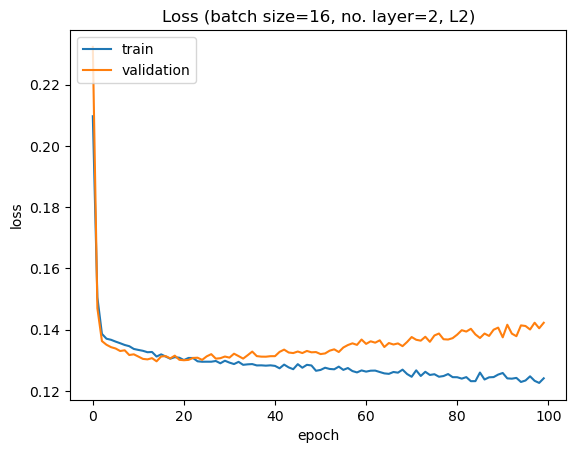

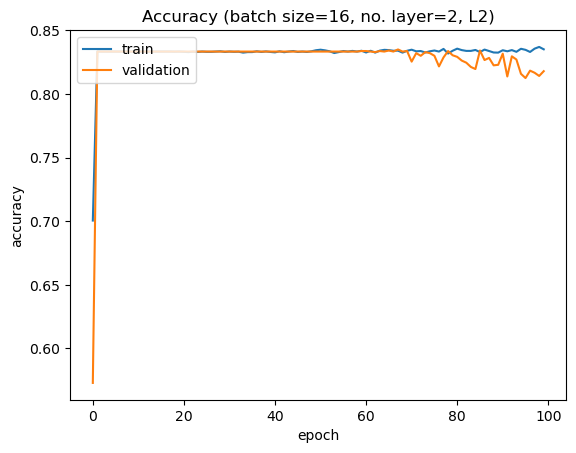

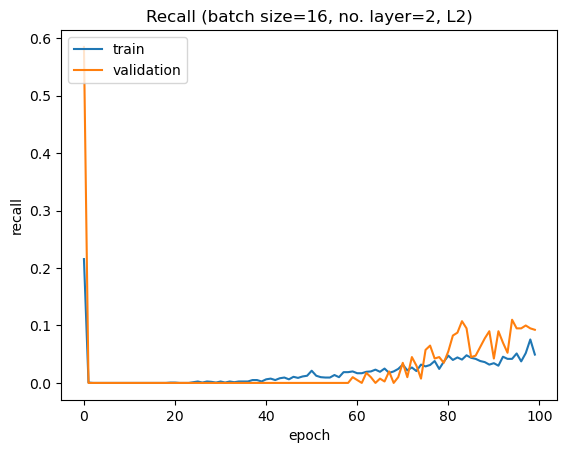

In [162]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [163]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.124
Training Accuracy: 0.835
Training Recall: 0.049


Validation Loss: 0.142
Validation Accuracy: 0.818
Validation Recall: 0.093


### batch size = 32, number of layer = 2

In [164]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
300/300 - 2s - loss: 0.2614 - accuracy: 0.6083 - recall_34: 0.3150 - val_loss: 0.1489 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 6ms/step
Epoch 2/100
300/300 - 1s - loss: 0.1828 - accuracy: 0.7564 - recall_34: 0.1156 - val_loss: 0.1478 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 565ms/epoch - 2ms/step
Epoch 3/100
300/300 - 1s - loss: 0.1513 - accuracy: 0.8282 - recall_34: 0.0056 - val_loss: 0.1441 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 555ms/epoch - 2ms/step
Epoch 4/100
300/300 - 1s - loss: 0.1418 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1431 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 544ms/epoch - 2ms/step
Epoch 5/100
300/300 - 1s - loss: 0.1400 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1414 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 507ms/epoch - 2ms/step
Epoch 6/100
300/300 - 1s - loss: 0.1393 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1402 - val_accuracy: 0.8333 

Epoch 47/100
300/300 - 1s - loss: 0.1319 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1309 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 610ms/epoch - 2ms/step
Epoch 48/100
300/300 - 1s - loss: 0.1307 - accuracy: 0.8333 - recall_34: 6.2500e-04 - val_loss: 0.1313 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 605ms/epoch - 2ms/step
Epoch 49/100
300/300 - 1s - loss: 0.1317 - accuracy: 0.8335 - recall_34: 0.0012 - val_loss: 0.1325 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 610ms/epoch - 2ms/step
Epoch 50/100
300/300 - 1s - loss: 0.1311 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1314 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 639ms/epoch - 2ms/step
Epoch 51/100
300/300 - 1s - loss: 0.1303 - accuracy: 0.8332 - recall_34: 0.0000e+00 - val_loss: 0.1311 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 557ms/epoch - 2ms/step
Epoch 52/100
300/300 - 1s - loss: 0.1306 - accuracy: 0.8331 - recall_34: 0.0000e+00 - val_loss: 0.1314 - val_

Epoch 94/100
300/300 - 1s - loss: 0.1258 - accuracy: 0.8342 - recall_34: 0.0206 - val_loss: 0.1385 - val_accuracy: 0.8300 - val_recall_34: 0.0275 - 660ms/epoch - 2ms/step
Epoch 95/100
300/300 - 1s - loss: 0.1260 - accuracy: 0.8344 - recall_34: 0.0281 - val_loss: 0.1374 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 620ms/epoch - 2ms/step
Epoch 96/100
300/300 - 1s - loss: 0.1262 - accuracy: 0.8338 - recall_34: 0.0306 - val_loss: 0.1364 - val_accuracy: 0.8308 - val_recall_34: 0.0225 - 565ms/epoch - 2ms/step
Epoch 97/100
300/300 - 1s - loss: 0.1264 - accuracy: 0.8336 - recall_34: 0.0175 - val_loss: 0.1359 - val_accuracy: 0.8333 - val_recall_34: 0.0025 - 550ms/epoch - 2ms/step
Epoch 98/100
300/300 - 1s - loss: 0.1259 - accuracy: 0.8338 - recall_34: 0.0281 - val_loss: 0.1376 - val_accuracy: 0.8338 - val_recall_34: 0.0300 - 651ms/epoch - 2ms/step
Epoch 99/100
300/300 - 1s - loss: 0.1263 - accuracy: 0.8340 - recall_34: 0.0288 - val_loss: 0.1380 - val_accuracy: 0.8279 - val_recall_34: 0.

#### Predict

In [165]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

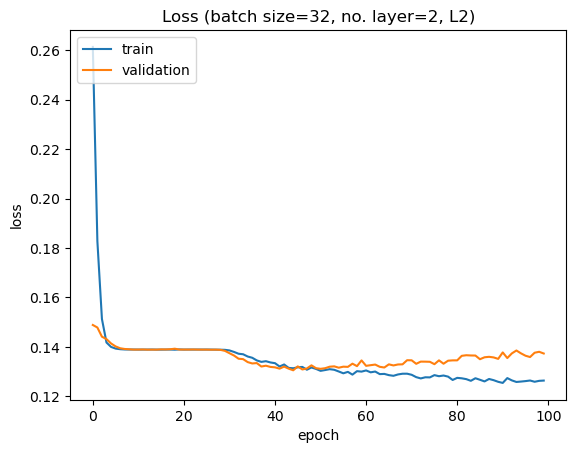

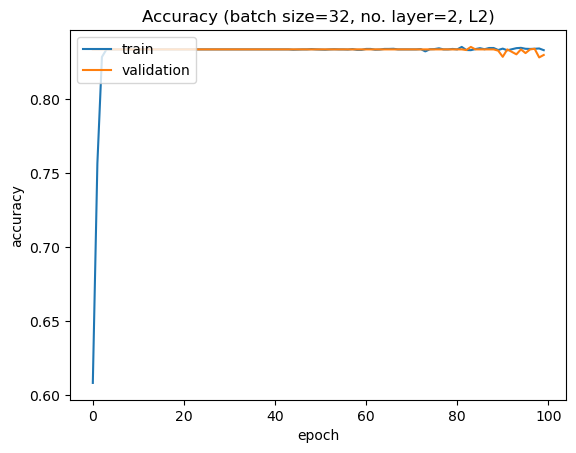

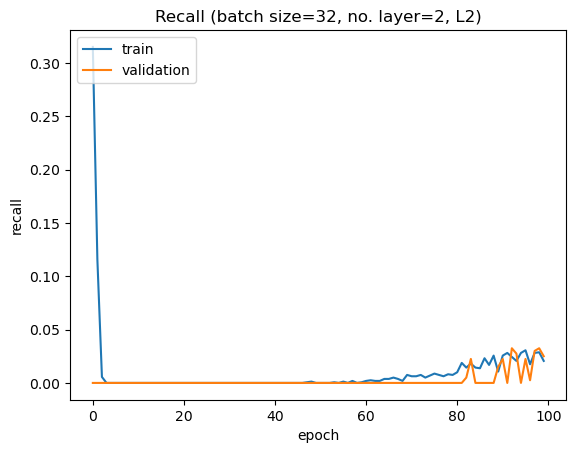

In [166]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [167]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.126
Training Accuracy: 0.833
Training Recall: 0.021


Validation Loss: 0.137
Validation Accuracy: 0.83
Validation Recall: 0.025


### batch size = 64, number of layer = 2

In [168]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
150/150 - 2s - loss: 0.2486 - accuracy: 0.5736 - recall_35: 0.3656 - val_loss: 0.1470 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 2s/epoch - 10ms/step
Epoch 2/100
150/150 - 0s - loss: 0.2151 - accuracy: 0.6992 - recall_35: 0.1912 - val_loss: 0.1419 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 412ms/epoch - 3ms/step
Epoch 3/100
150/150 - 0s - loss: 0.1916 - accuracy: 0.7812 - recall_35: 0.0763 - val_loss: 0.1415 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 379ms/epoch - 3ms/step
Epoch 4/100
150/150 - 0s - loss: 0.1749 - accuracy: 0.8152 - recall_35: 0.0312 - val_loss: 0.1404 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 379ms/epoch - 3ms/step
Epoch 5/100
150/150 - 0s - loss: 0.1613 - accuracy: 0.8310 - recall_35: 0.0031 - val_loss: 0.1397 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 395ms/epoch - 3ms/step
Epoch 6/100
150/150 - 0s - loss: 0.1520 - accuracy: 0.8325 - recall_35: 0.0000e+00 - val_loss: 0.1397 - val_accuracy: 0.8333 - val_r

Epoch 47/100
150/150 - 0s - loss: 0.1362 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1342 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 487ms/epoch - 3ms/step
Epoch 48/100
150/150 - 0s - loss: 0.1359 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1336 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 447ms/epoch - 3ms/step
Epoch 49/100
150/150 - 0s - loss: 0.1349 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1334 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 395ms/epoch - 3ms/step
Epoch 50/100
150/150 - 0s - loss: 0.1347 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1339 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 411ms/epoch - 3ms/step
Epoch 51/100
150/150 - 0s - loss: 0.1343 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1334 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 460ms/epoch - 3ms/step
Epoch 52/100
150/150 - 0s - loss: 0.1344 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1333 - 

Epoch 94/100
150/150 - 0s - loss: 0.1261 - accuracy: 0.8354 - recall_35: 0.0406 - val_loss: 0.1403 - val_accuracy: 0.8112 - val_recall_35: 0.1450 - 461ms/epoch - 3ms/step
Epoch 95/100
150/150 - 0s - loss: 0.1244 - accuracy: 0.8361 - recall_35: 0.0494 - val_loss: 0.1378 - val_accuracy: 0.8183 - val_recall_35: 0.1050 - 418ms/epoch - 3ms/step
Epoch 96/100
150/150 - 0s - loss: 0.1240 - accuracy: 0.8361 - recall_35: 0.0594 - val_loss: 0.1391 - val_accuracy: 0.8150 - val_recall_35: 0.1325 - 467ms/epoch - 3ms/step
Epoch 97/100
150/150 - 0s - loss: 0.1259 - accuracy: 0.8349 - recall_35: 0.0431 - val_loss: 0.1393 - val_accuracy: 0.8150 - val_recall_35: 0.1325 - 460ms/epoch - 3ms/step
Epoch 98/100
150/150 - 0s - loss: 0.1242 - accuracy: 0.8371 - recall_35: 0.0619 - val_loss: 0.1440 - val_accuracy: 0.8075 - val_recall_35: 0.1650 - 449ms/epoch - 3ms/step
Epoch 99/100
150/150 - 0s - loss: 0.1243 - accuracy: 0.8352 - recall_35: 0.0475 - val_loss: 0.1393 - val_accuracy: 0.8150 - val_recall_35: 0.1450

#### Predict

In [169]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

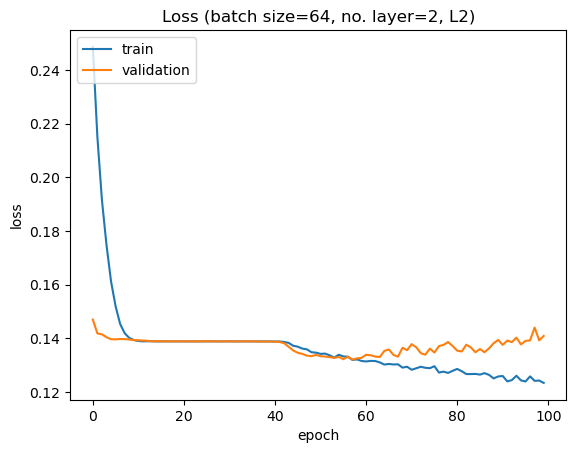

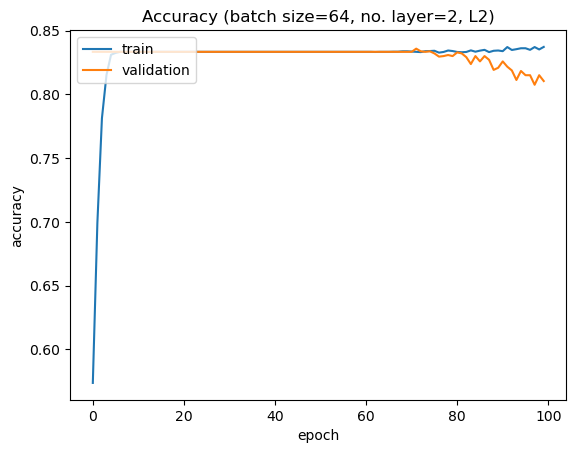

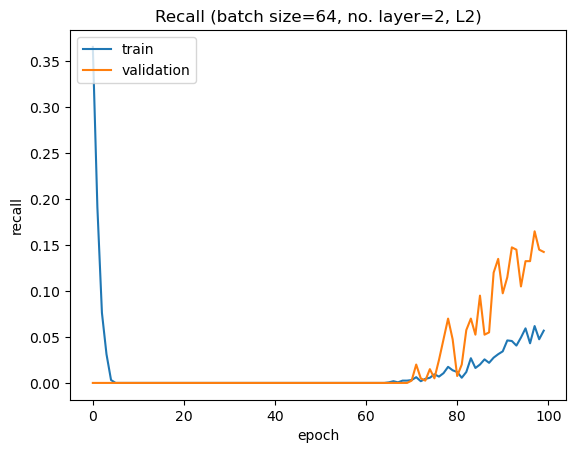

In [170]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [171]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.123
Training Accuracy: 0.837
Training Recall: 0.057


Validation Loss: 0.141
Validation Accuracy: 0.81
Validation Recall: 0.142
